In [17]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science','ieee', "no-latex", "vibrant"])

ars_path = "/home/boittier/AdjustReference-System/"
sys.path.insert(1, ars_path)
from ARS import *

def get_FDCM_data(path, csv_name):
    
    subdirs = [x for x in os.listdir(path) if 
               os.path.isdir(os.path.join(path, x)) and not x.startswith(".")]

    if "slices" in subdirs:
        subdirs.remove("slices")
        
    scan_points = []
    dihedrals = []
    closes = []
    mids = []
    fars = []
    totals = []
    paths = []
    rmsd_atoms = []
    rmsd_charges = []
    q_s = []
    
    tmp_dict = {}
    
    for x in subdirs:
        #  list files in the subdir
        files = os.listdir(os.path.join(path, x))
        local = [x for x in files if x.startswith("local")]

        #  read the charges in their local axes
        local_file = open(os.path.join(path, x, local[-1])).readlines()
        n_lines = int(local_file[0])
        charges = local_file[2:n_lines+2]
        charges = np.array([ [float(x.split()[1]),
                  float(x.split()[2]),
                  float(x.split()[3]),
                  float(x.split()[4])] for x in charges])
        
        for i, axis in enumerate(["x", "y", "z", "q"]):
            for c in range(n_lines):
                if f"{axis}_c{c}" not in tmp_dict.keys():
                    tmp_dict[f"{axis}_c{c}"] = []
                tmp_dict[f"{axis}_c{c}"].append(charges[c,i])
        
        scan_points.append(x)
        paths.append(os.path.join(path, x))
        #  read the ARS log file
        ars_lines = open(os.path.join(path, x, "ARS.log")).readlines()
        rmsd_atoms.append(float(ars_lines[0].split()[-1]))
        rmsd_charges.append(float(ars_lines[1].split()[-1]))
        dihedrals.append(x.split("_")[-1])
        #  read the analysis log file
        analysis_lines = open(os.path.join(path, x, "analysis.log")).readlines()
        
        totals.append(float(analysis_lines[-5].split()[-3]))
        closes.append(float(analysis_lines[-4].split()[-3]))
        mids.append(float(analysis_lines[-3].split()[-3]))
        fars.append(float(analysis_lines[-2].split()[-3]))
        
    df_dict = {"scan_point": scan_points, "dihedral": dihedrals, "close_range": closes, 
              "mid_range": mids, "far_range": fars, "total": totals,  
              "rmsd_atoms": rmsd_atoms, "rmsd_charges": rmsd_charges, "path": paths}
    df_dict.update(tmp_dict)
    df = pd.DataFrame(df_dict)
    df.to_csv("/home/boittier/FDCM/data_csv/"+csv_name, index=False)    
    df = df.sort_values("dihedral")
    
    return df    
    
def plot_fit_dataframe(df):
    plt.grid(which="both")
    plt.plot(df["dihedral"], df["total"], "-", label="Total")        
    plt.plot(df["dihedral"], df["close_range"], "-", label="1.20 < $r$ < 1.66") 
    plt.plot(df["dihedral"], df["mid_range"], "-", label="1.66 < $r$ < 2.20") 
    plt.plot(df["dihedral"], df["far_range"], "-", label="2.20 < $r$") 
    plt.legend()
    plt.ylabel("ESP Error (kcal mol$^{-1}$ $e^{-1}$)")
    plt.xlabel("$\Phi~(^{\circ})  $")
    plt.ylim(0, 10)
    plt.xlim(-180,180)
    
def plot_charge(c_number, df, prefix):
    #df = df[df["dihedral"] < 0]
    
    
    fig, ax = plt.subplots(3,1,  sharex=True)
    #df = df.drop(35)
    ax[0].scatter(df["dihedral"], df[f"x_c{c_number}"], s=0.5, c="red")
    ax[1].scatter(df["dihedral"], df[f"y_c{c_number}"], s=0.5, c="green")
    ax[2].scatter(df["dihedral"], df[f"z_c{c_number}"], s=0.5, c="blue")

    fit_x = fit_poly(df["dihedral"], df[f"x_c{c_number}"])
    ax[0].plot(df["dihedral"], fit_x["fitfunc"](df["dihedral"]), "--", c="k", linewidth=0.675)
    fit_y = fit_poly(df["dihedral"], df[f"y_c{c_number}"])
    ax[1].plot(df["dihedral"], fit_y["fitfunc"](df["dihedral"]), "--", c="k", linewidth=0.675)
    fit_z = fit_poly(df["dihedral"], df[f"z_c{c_number}"])
    ax[2].plot(df["dihedral"], fit_z["fitfunc"](df["dihedral"]), "--", c="k", linewidth=0.675)
    
    ax[0].plot(df["dihedral"], df[f"x_c{c_number}"], "--", c="red")
    ax[1].plot(df["dihedral"], df[f"y_c{c_number}"], "--", c="green")
    ax[2].plot(df["dihedral"], df[f"z_c{c_number}"], "--", c="blue")
    
    ax[0].set_ylabel("$e_x$")
    ax[1].set_ylabel("$e_y$")
    ax[2].set_ylabel("$e_z$")
    plt.xlabel('$\Phi$')
    
    fits_ = [fit_x, fit_y, fit_z]
    
    for i in range(3):
        plt.text(0.5, 0.5, f"$q_{{{c_number+1}}}$", 
                 rotation=0, verticalalignment="center", 
                 transform= ax[i].transAxes)
        
        covariance = fits_[i]["maxcov"]
        plt.text(1,1, "$\sigma_{X,Y}$ ="+"{:.3e}".format(covariance), 
                 rotation=0, verticalalignment="center", 
                 transform= ax[i].transAxes)
#     plt.savefig("../figs/charge_position_analysis/{0}-fbuta_sym_c{1}.pdf".
#                 format(prefix, c_number+1))
    
    #plt.xlim(-180,0)
    plt.show()
    
    return [fit_x["fitfunc"], fit_y["fitfunc"], fit_z["fitfunc"]]
    
import numpy, scipy.optimize

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * numpy.sin(w*t + p) + c
    
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess, maxfev=10000)
    A, w, p, c = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: A * numpy.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, 
            "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}

def fit_poly(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    
    def polyfunc(x,a,b,c,d): return a*x + b*x**2 + c*x**3 + d
    
    guess = [1,1,1,1]
    popt, pcov = scipy.optimize.curve_fit(polyfunc, tt, 
                                          yy, p0=guess, maxfev=10000)
    a,b,c,d = popt
    fitfunc = lambda x: a*x + b*x**2 + c*x**3 + d
    return {"a": a, "b": b, "c": c, "d": d, 
            "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}

    
    
    
    
    
    

_str_ = """%chk={name}.chk
%nproc=8
%mem=16GB
#p B3LYP/6-311++G** 

mol.pdb

0  1
C
C  1  r2
H  1  r3  2  a3
H  2  r4  1  a4  3  d4
H  1  r5  2  a5  3  d5
H  2  r6  1  a6  3  d6
H  6  r7  2  a7  1  d7
N  4  r8  2  a8  1  d8
O  2  r9  1  a9  3  d9
C  7  r10  6  a10  2  d10
H  1  r11  2  a11  3  d11
H  10  r12  7  a12  6  d12
Variables:
r2= 1.5188
r3= 1.0917
a3= 108.65
r4= 2.0537
a4=  90.73
d4= 236.87
r5= 1.0923
a5= 113.78
d5= 121.73
r6= 2.7850
a6= 153.20
d6= 281.31
r7= 1.7673
a7=  71.39
d7= 228.67
r8= 1.0061
a8=  35.39
d8= {d8} !180.09
r9= 1.2218
a9= 122.08
d9=  {d9} !56.92
r10= 1.0925
a10=  36.02
d10=  {d10} !67.05
r11= 1.0920
a11= 108.65
d11= 243.35
r12= 1.0901
a12= 109.18
d12= 118.57

"""
eq_d8 = 180.09
eq_d9 = 56.92
eq_d10 = 67.05

d8_values = np.arange(eq_d8, -180, -90)
d9_values = np.arange(eq_d9, -56.92, -90)
d10_values = np.arange(eq_d10, -67.05, -90)

print(d8_values)
print(d9_values)
print(d10_values)

for i, r2 in enumerate(d8_values):
    for j, r3 in enumerate(d9_values):
        for k, a3 in enumerate(d10_values):
            
            name = f"/home/boittier/amide/{i+1}_{j+1}_{k+1}_new.com"
            print(name)
            _s = _str_.format(name=name, d8=r2, d9=r3, d10=a3)
            f = open(name, "w")
            f.write(_s)
            f.close()





[ 1.8009e+02  9.0090e+01  9.0000e-02 -8.9910e+01 -1.7991e+02]
[ 56.92 -33.08]
[ 67.05 -22.95]
/home/boittier/amide/1_1_1_new.com
/home/boittier/amide/1_1_2_new.com
/home/boittier/amide/1_2_1_new.com
/home/boittier/amide/1_2_2_new.com
/home/boittier/amide/2_1_1_new.com
/home/boittier/amide/2_1_2_new.com
/home/boittier/amide/2_2_1_new.com
/home/boittier/amide/2_2_2_new.com
/home/boittier/amide/3_1_1_new.com
/home/boittier/amide/3_1_2_new.com
/home/boittier/amide/3_2_1_new.com
/home/boittier/amide/3_2_2_new.com
/home/boittier/amide/4_1_1_new.com
/home/boittier/amide/4_1_2_new.com
/home/boittier/amide/4_2_1_new.com
/home/boittier/amide/4_2_2_new.com
/home/boittier/amide/5_1_1_new.com
/home/boittier/amide/5_1_2_new.com
/home/boittier/amide/5_2_1_new.com
/home/boittier/amide/5_2_2_new.com


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

energy_matrix = np.ndarray((3,3,3))


def load_out(filename):
    lines = open(filename).readlines()
    s = ""
    for _ in lines:
        s += _.rstrip()
    s = s.split("\\")
    for spl in s:
        if spl.startswith("HF="):
            return(float(spl[3:]))
        


out_files = [_ for _ in os.listdir() if _.__contains__("new.out") 
             and not _.__contains__("angle") ]

for _ in out_files:
    a, b, c = [int(i) - 1 for i in _.split("_")[:3]]

    energy_matrix[a,b,c] = load_out(_)



findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


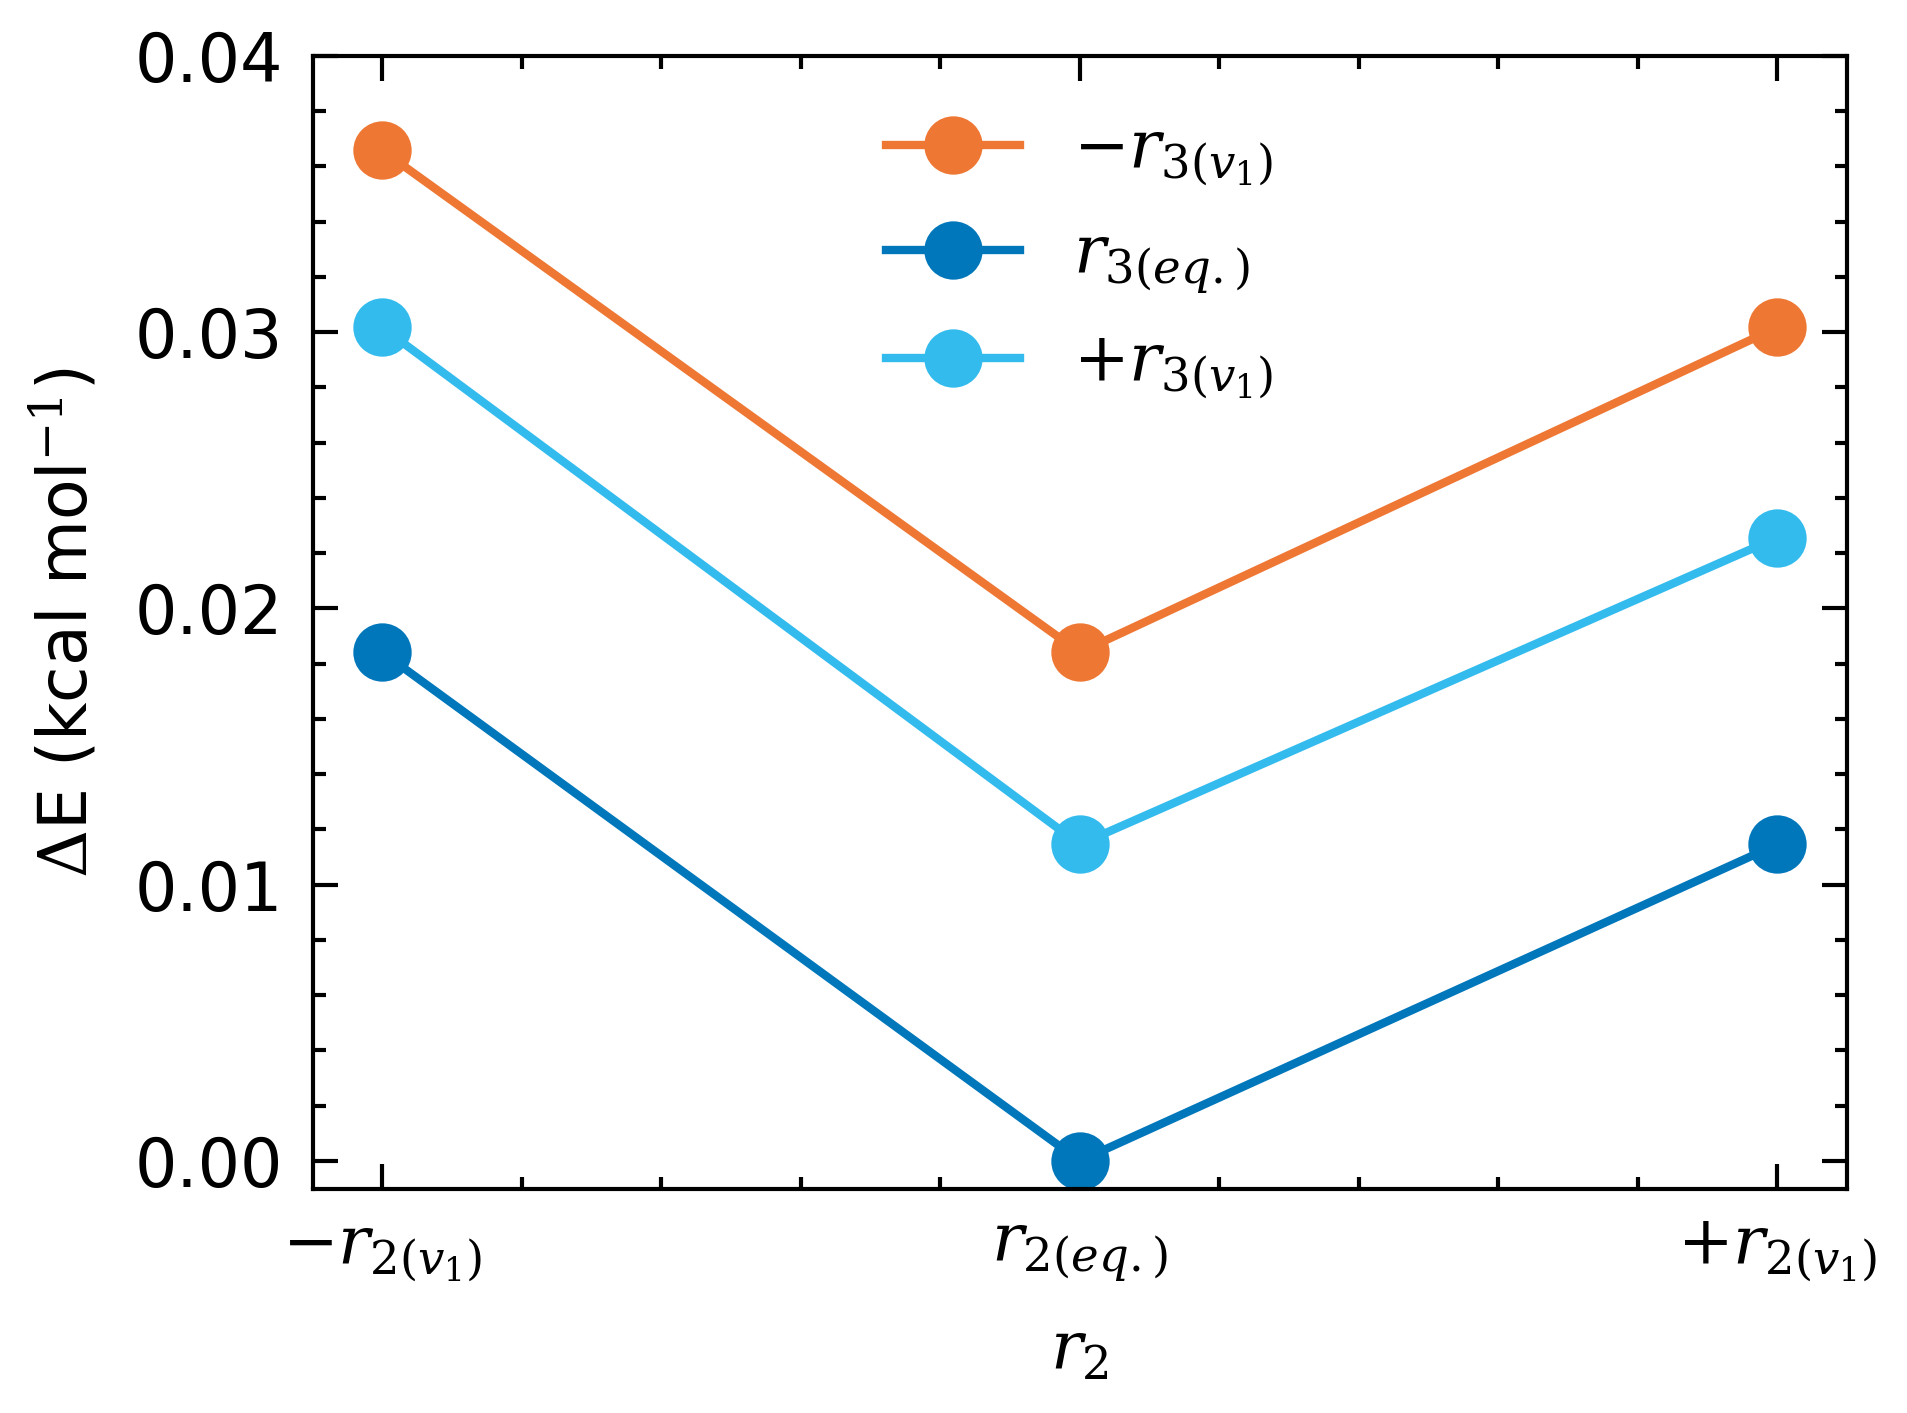

In [3]:
plt.plot(energy_matrix[:, :, 1] - min(energy_matrix[1, 1, :]), "-o", label="tmp")
plt.ylabel("$\Delta$E (kcal mol$^{-1}$)")
plt.xticks(ticks=[0, 1, 2], labels=["$-r_{2 (v_1)}$", "$r_{2 (eq.)}$", "$+r_{2 (v_1)}$"])
plt.xlabel("$r_2$")
plt.ylim(-0.001,0.04)
L=plt.legend()
L.get_texts()[0].set_text('$-r_{3 (v_1)}$')
L.get_texts()[1].set_text('$r_{3 (eq.)}$')
L.get_texts()[2].set_text('$+r_{3 (v_1)}$')
plt.savefig("bond_energy.pdf", bbox_inches="tight")

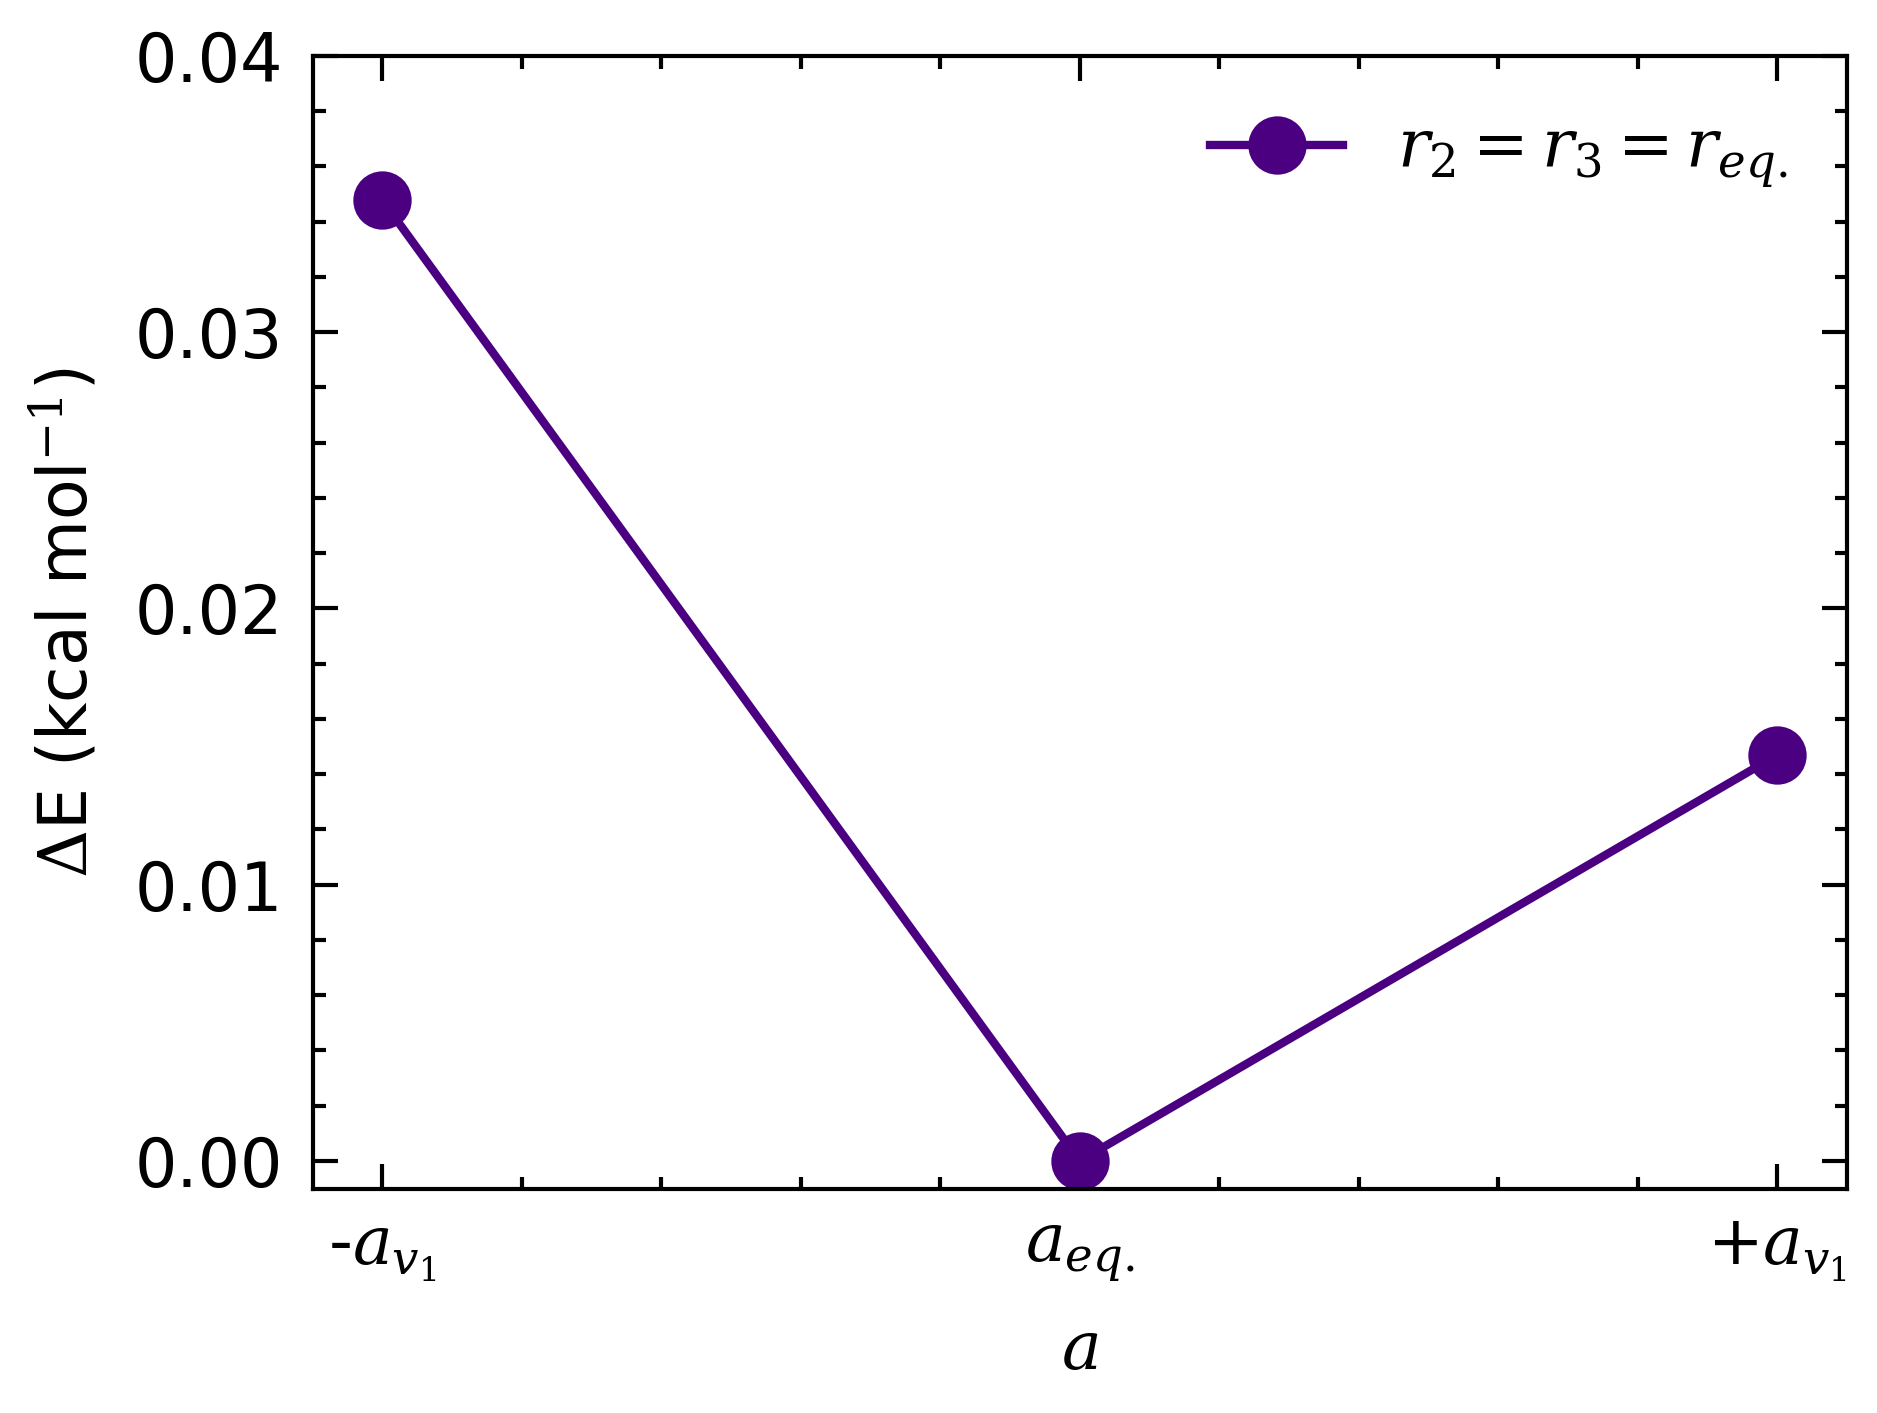

In [4]:
plt.plot(energy_matrix[1, 1, :] - min(energy_matrix[1, 1, :]), "-o", 
         c="indigo", label="$r_2 = r_3 = r_{eq.}$")
plt.ylabel("$\Delta$E (kcal mol$^{-1}$)")
plt.xticks(ticks=[0, 1, 2], labels=["-$a_{v_1}$", "$a_{eq.}$", "+$a_{v_1}$"])
plt.xlabel("$a$")
plt.legend()
plt.ylim(-0.001,0.04)
plt.savefig("angle_energy.pdf", bbox_inches="tight")

In [203]:
r2_values = [0.8424, 0.9621, 1.0874]
r3_values = [0.8424, 0.9621, 1.0874]
a3_values = [70.259, 105.04, 133.157]

adjust = 0

df_w["r2"] = df_w["scan_point"].apply(lambda x: 
                                         r2_values[int(x.split("_")[1+adjust]) - 1])
df_w["r3"] = df_w["scan_point"].apply(lambda x: 
                                         r3_values[int(x.split("_")[2]) - 1])
df_w["a3"] = df_w["scan_point"].apply(lambda x: 
                                         a3_values[int(x.split("_")[3]) - 1])
df_w

df_fit_w["r2"] = df_fit_w["scan_point"].apply(lambda x: 
                                         r2_values[int(x.split("_")[3]) - 1])
df_fit_w["r3"] = df_fit_w["scan_point"].apply(lambda x: 
                                         r3_values[int(x.split("_")[4]) - 1])
df_fit_w["a3"] = df_fit_w["scan_point"].apply(lambda x: 
                                         a3_values[int(x.split("_")[5]) - 1])
df_w_bi

df_w_bi["r2"] = df_w_bi["scan_point"].apply(lambda x: 
                                         r2_values[int(x.split("_")[2]) - 1])
df_w_bi["r3"] = df_w_bi["scan_point"].apply(lambda x: 
                                         r3_values[int(x.split("_")[3]) - 1])
df_w_bi["a3"] = df_w_bi["scan_point"].apply(lambda x: 
                                         a3_values[int(x.split("_")[4]) - 1])


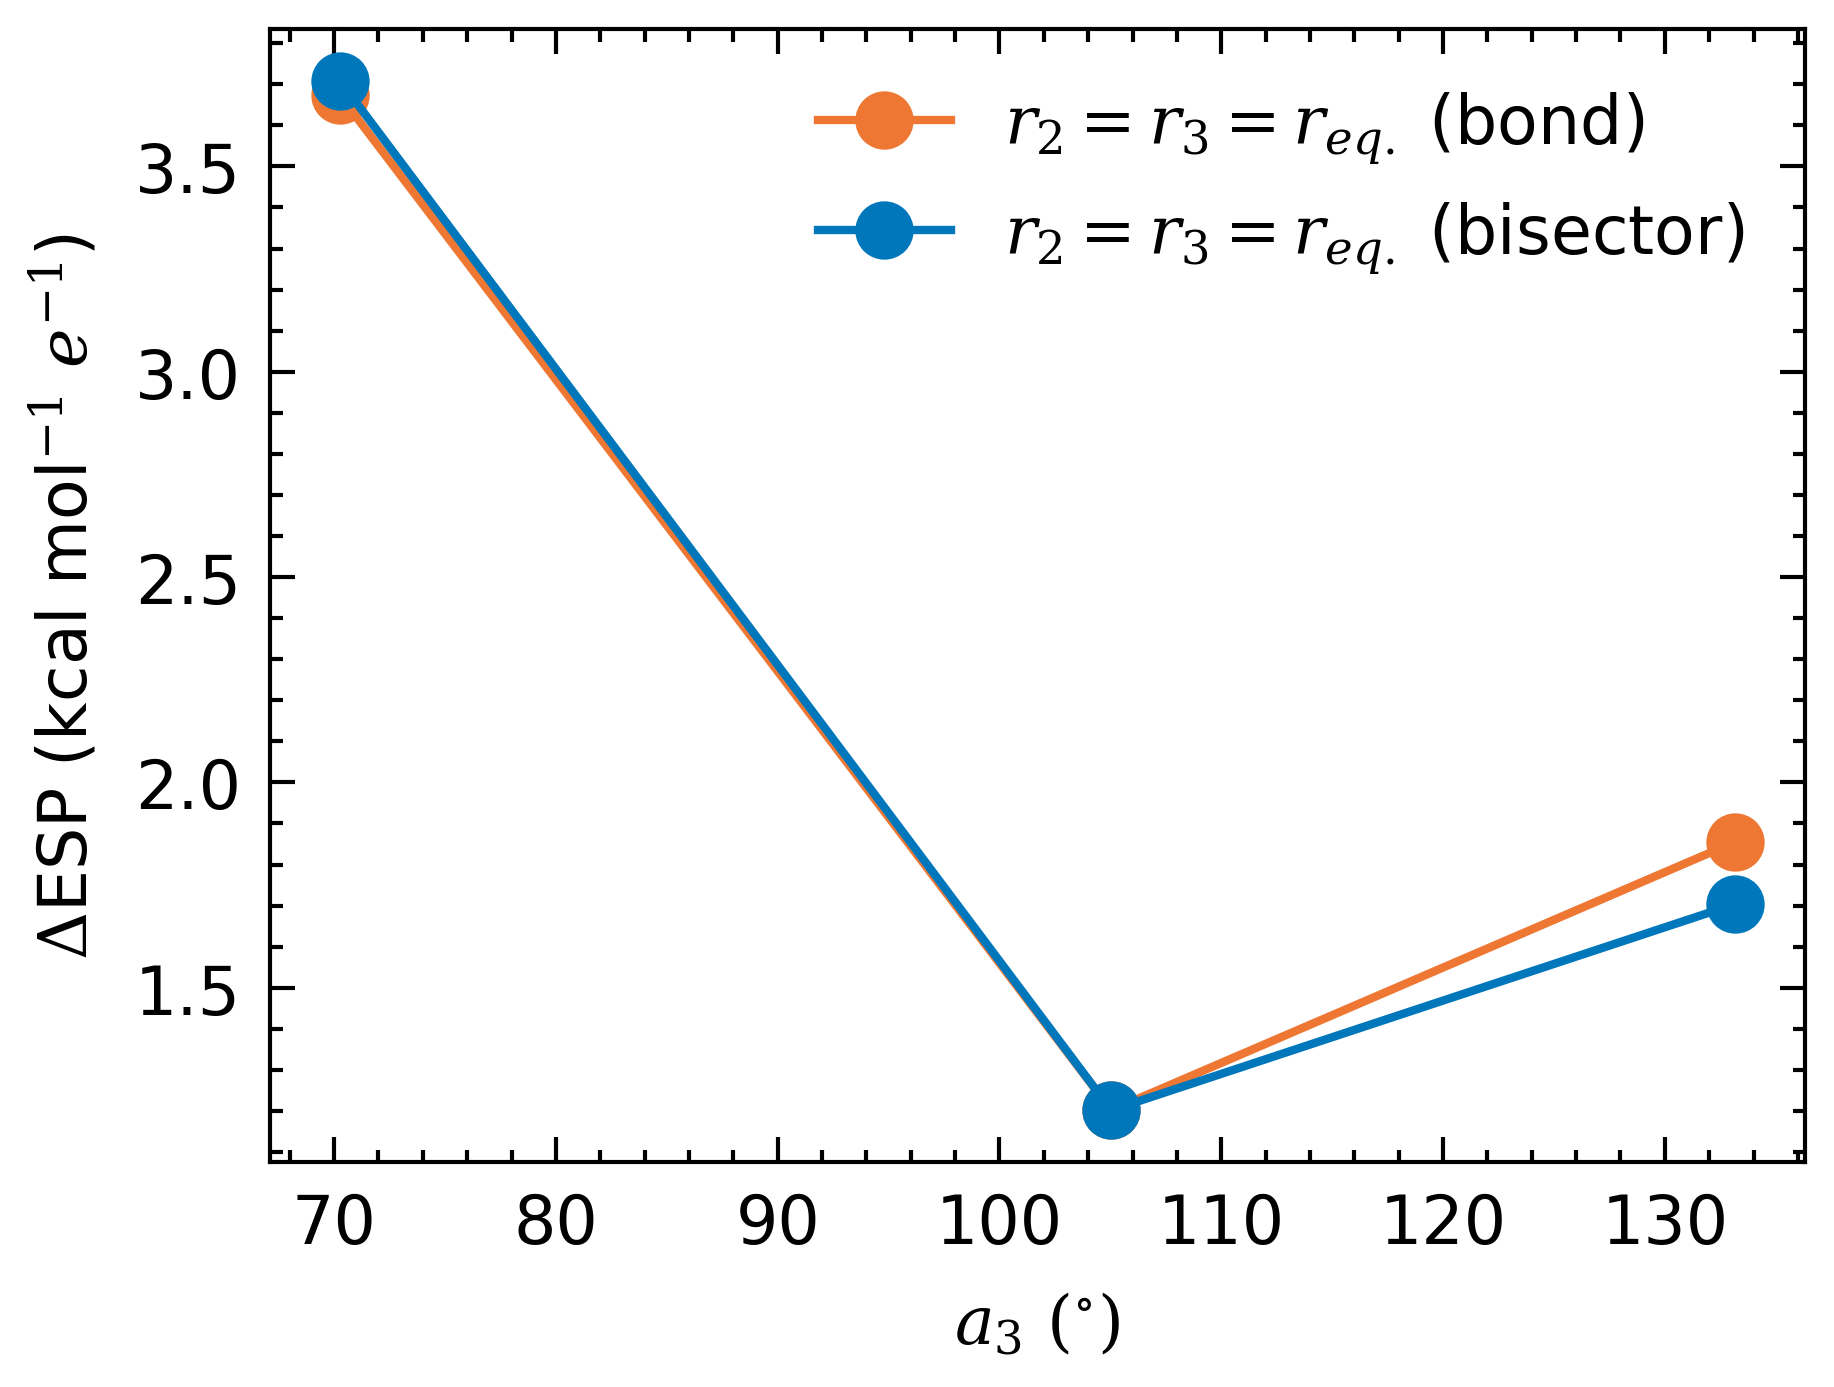

In [235]:
index = 2
tmp_df = df_w[df_w["r2"]==r2_values[index]]
tmp_df = tmp_df[tmp_df["r3"]==r3_values[index]]
tmp_df1 = tmp_df.sort_values("a3") 

plt.plot(tmp_df1["a3"], tmp_df1["total"], "-o", label="$r_2 = r_3 = r_{eq.}$ (bond)")

tmp_df = df_w_bi[df_w_bi["r2"]==r2_values[index]]
tmp_df = tmp_df[tmp_df["r3"]==r3_values[index]]
tmp_df1 = tmp_df.sort_values("a3") 

plt.plot(tmp_df1["a3"], tmp_df1["total"], "-o", label="$r_2 = r_3 = r_{eq.}$ (bisector)")
plt.ylabel("$\Delta$ESP (kcal mol$^{-1}$ $e^{-1}$)")
plt.xlabel("$a_3$ $(^{\circ})$")
plt.legend()
# plt.ylim(0,2.6)
plt.savefig("a3_0.pdf", bbox_inches="tight")




scan_point dihedral  close_range  mid_range  far_range  \
17  water_fit_0_2_1_2_new      new     1.368659   0.741317   0.452442   
20  water_fit_0_2_2_2_new      new     1.011182   0.435489   0.220103   
22  water_fit_0_2_3_2_new      new     1.064470   0.426734   0.207920   

       total  rmsd_atoms  rmsd_charges  \
17  0.973900    0.107966      0.150121   
20  0.677054    0.000000      0.000000   
22  0.706434    0.113154      0.157542   

                                                 path     x_c0  ...      z_c5  \
17  /home/boittier/FDCM/water_fit_0/water_fit_0_2_...  0.09941  ... -0.067407   
20  /home/boittier/FDCM/water_fit_0/water_fit_0_2_...  0.09941  ... -0.067407   
22  /home/boittier/FDCM/water_fit_0/water_fit_0_2_...  0.09941  ... -0.067407   

        q_c0      q_c1     q_c2      q_c3      q_c4      q_c5      r2      r3  \
17 -0.282216 -0.311638  0.19663  0.090174  0.064911  0.242139  0.9621  0.8424   
20 -0.282216 -0.311638  0.19663  0.090174  0.064911  0.242139  0.9621  0.9621   
22 -0.282216 -0.311638  0.19663  0.090174  0.064911  0.242139  0.9621  1.0874   

        a3  
17  105.04  
20  105.04  
22  105.04  

[3 rows x 36 columns]

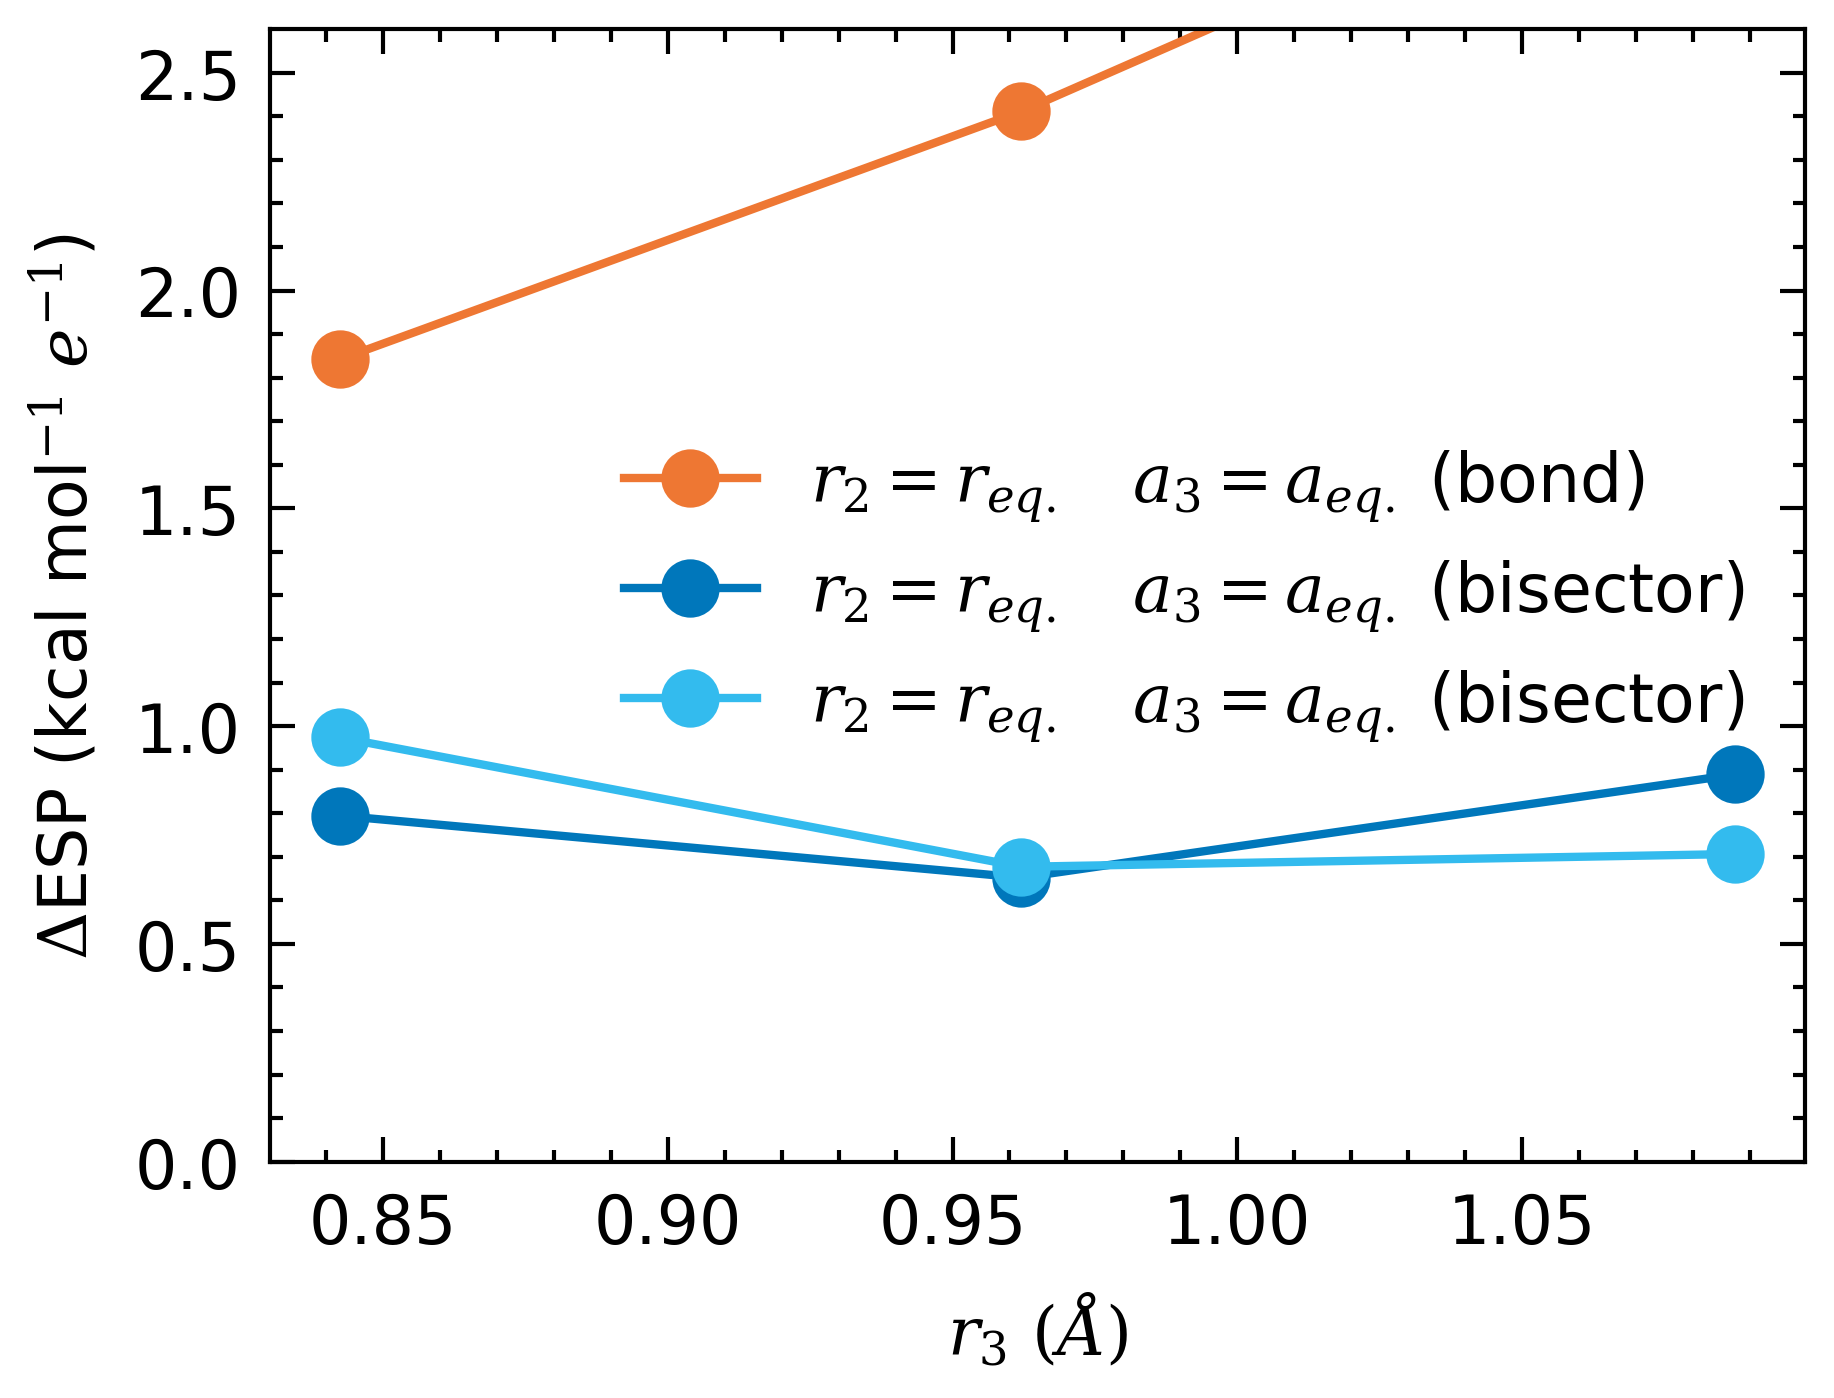

In [241]:
index1 = 0
index2 = 0
tmp_df = df_w[df_w["r2"]==r2_values[index1]]
tmp_df = tmp_df[tmp_df["a3"]==a3_values[index2]]
tmp_df = tmp_df.sort_values("r3")
plt.plot(tmp_df["r3"], tmp_df["total"], "-o", label="$r_2 = r_{eq.}$   $a_3 = a_{eq.}$ (bond)")

tmp_df = df_w_bi[df_w_bi["r2"]==r2_values[index]]
tmp_df = tmp_df[tmp_df["a3"]==a3_values[index]]
tmp_df = tmp_df.sort_values("r3")
plt.plot(tmp_df["r3"], tmp_df["total"], "-o", label="$r_2 = r_{eq.}$   $a_3 = a_{eq.}$ (bisector)")
plt.legend()

tmp_df = df_fit_w[df_fit_w["r2"]==r2_values[index]]
tmp_df = tmp_df[tmp_df["a3"]==a3_values[index]]
tmp_df = tmp_df.sort_values("r3")
plt.plot(tmp_df["r3"], tmp_df["total"], "-o", label="$r_2 = r_{eq.}$   $a_3 = a_{eq.}$ (bisector)")
plt.legend()

plt.ylabel("$\Delta$ESP (kcal mol$^{-1}$ $e^{-1}$)")
plt.xlabel("$r_3$ $(\AA)$")
plt.ylim(0,2.6)
plt.savefig("r3_0.pdf", bbox_inches="tight")
tmp_df

#  Bond method

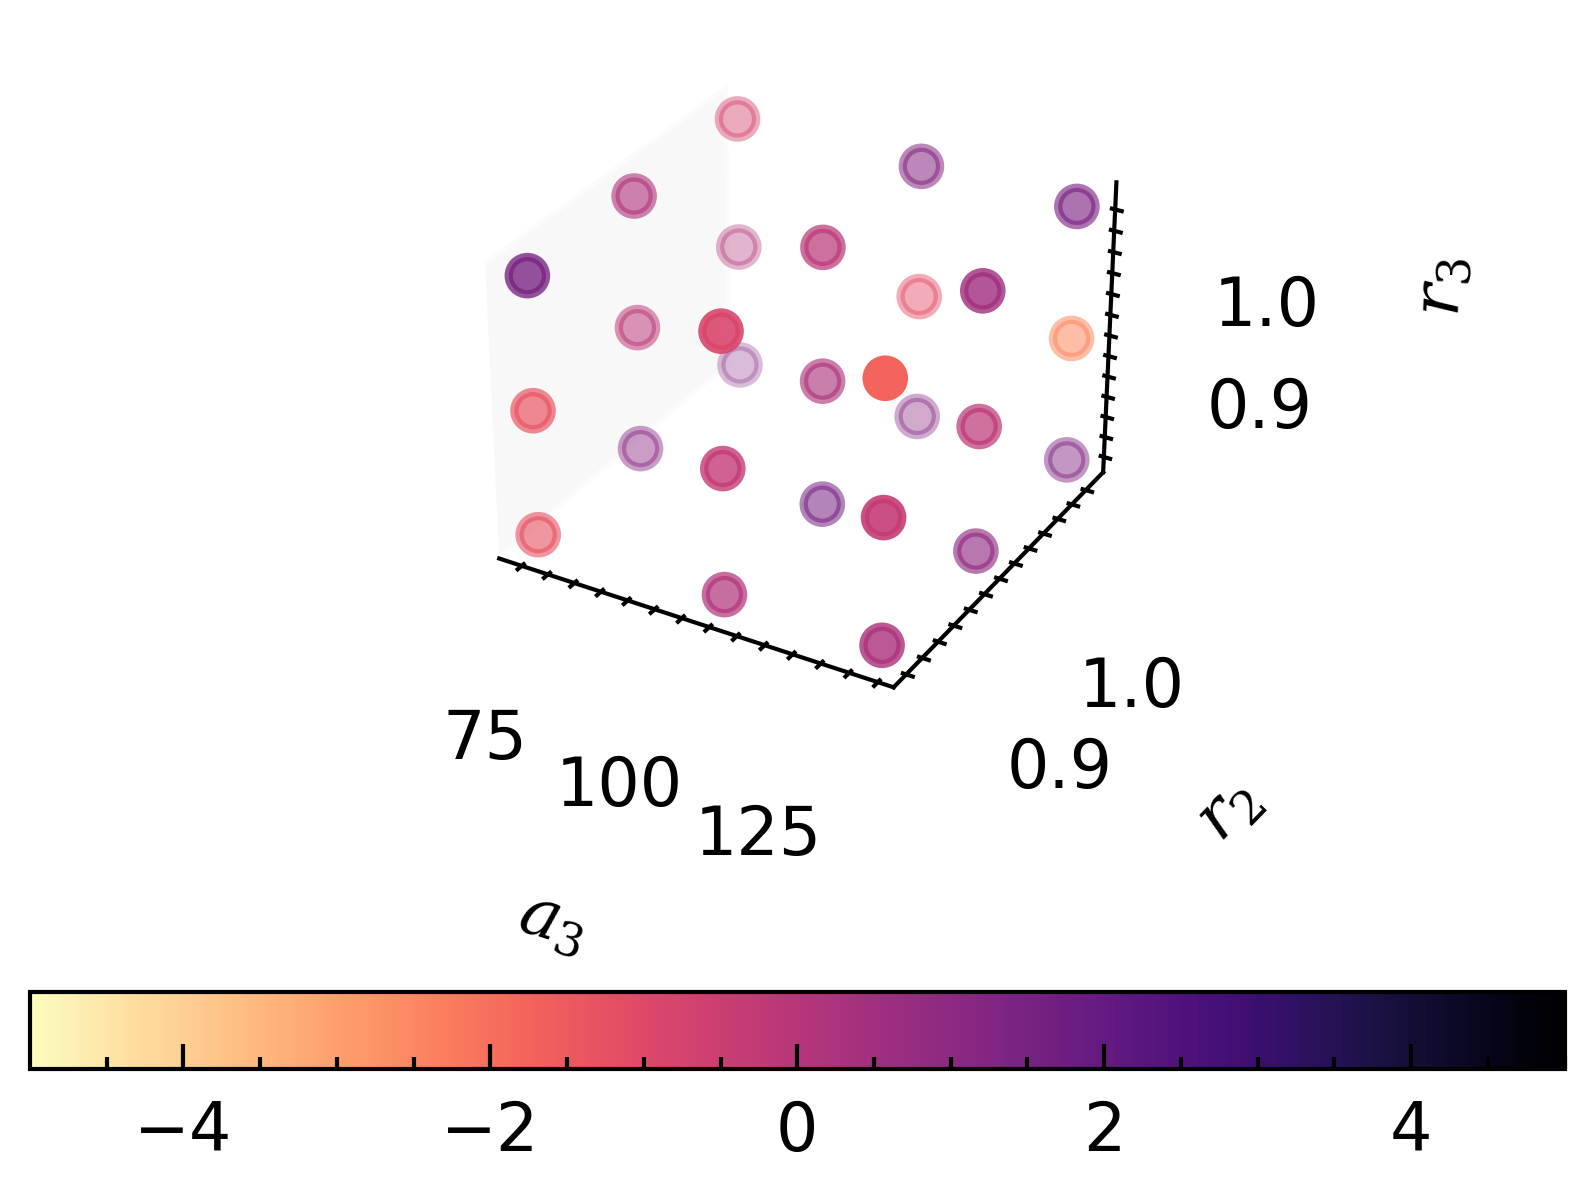

In [230]:
import numpy as np
import matplotlib.pyplot as plt


norm = mpl.colors.Normalize(vmin=-5, vmax=5)
cmap = cm.magma_r
m = cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure()
ax = plt.axes(projection='3d')
perc_error  = (df_w["total"] - df_w_bi["total"])
p = ax.scatter(df_w["a3"], df_w["r2"], df_w["r3"], c=m.to_rgba(perc_error))#, alpha=1)


ax.set_xlabel("$a_3$")
ax.set_ylabel("$r_2$")
ax.set_zlabel("$r_3$")

cbar = fig.colorbar(m, ax=ax, orientation="horizontal", pad=0.23)

p.set_clim(0, 4) # Get rid of colored axes planes
# First remove fill
ax.xaxis.pane.fill = True
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# ax.plot(df_w["a3"], df_w["r2"], df_w["r3"], alpha=1, c="k", linewidth=0.5)
ax.grid(True, which="major")
ax.grid(False)
plt.savefig("First3x3x3.pdf", bbox_inches="tight")

In [233]:
df_w["dif"] = perc_error
df_w["bond_method"] = df_w["total"]
df_w["bis_method"] = df_w_bi["total"]
df_w = df_w.sort_values("dif")
df_w[["r2", "r3", "a3", "bond_method", "bis_method", "dif"]]

r2      r3       a3  bond_method  bis_method       dif
13  1.0874  1.0874  105.040     1.201680    3.708832 -2.507152
10  0.8424  1.0874  105.040     0.826514    2.615040 -1.788526
19  1.0874  0.9621  105.040     0.907626    2.238708 -1.331082
14  0.9621  1.0874  133.157     1.932577    3.195384 -1.262807
24  0.9621  0.9621  105.040     0.652182    1.817454 -1.165273
25  0.8424  0.8424  105.040     0.881281    1.769137 -0.887856
9   0.8424  0.8424  133.157     2.062035    2.849376 -0.787341
2   0.8424  0.9621   70.259     2.411487    2.800775 -0.389288
17  0.9621  1.0874  105.040     0.889016    1.201680 -0.312663
11  0.8424  0.9621  105.040     0.701141    0.881281 -0.180140
18  1.0874  0.8424  133.157     2.037589    2.190216 -0.152628
8   0.9621  0.8424  105.040     0.794391    0.932225 -0.137834
3   0.8424  0.8424   70.259     1.841981    1.783409  0.058572
21  1.0874  0.9621  133.157     1.939756    1.837166  0.102590
1   1.0874  0.8424  105.040     0.932225    0.794391  0.137834
22  0.9621  0.9621  133.157     1.975299    1.770232  0.205067
20  0.8424  1.0874  133.157     2.086992    1.843778  0.243213
23  1.0874  1.0874   70.259     3.673048    3.186376  0.486672
7   0.9621  0.9621   70.259     2.613718    1.745044  0.868674
5   0.9621  0.8424  133.157     2.023509    0.907626  1.115883
12  1.0874  1.0874  133.157     1.854750    0.701141  1.153610
0   0.9621  0.8424   70.259     2.051447    0.826514  1.224933
26  0.8424  1.0874   70.259     3.129682    1.888610  1.241071
16  1.0874  0.9621   70.259     3.002083    1.703515  1.298568
6   0.8424  0.9621  133.157     2.075476    0.652182  1.423294
4   0.9621  1.0874   70.259     3.329728    1.816439  1.513290
15  1.0874  0.8424   70.259     2.480455    0.889016  1.591439

#  Bisector method

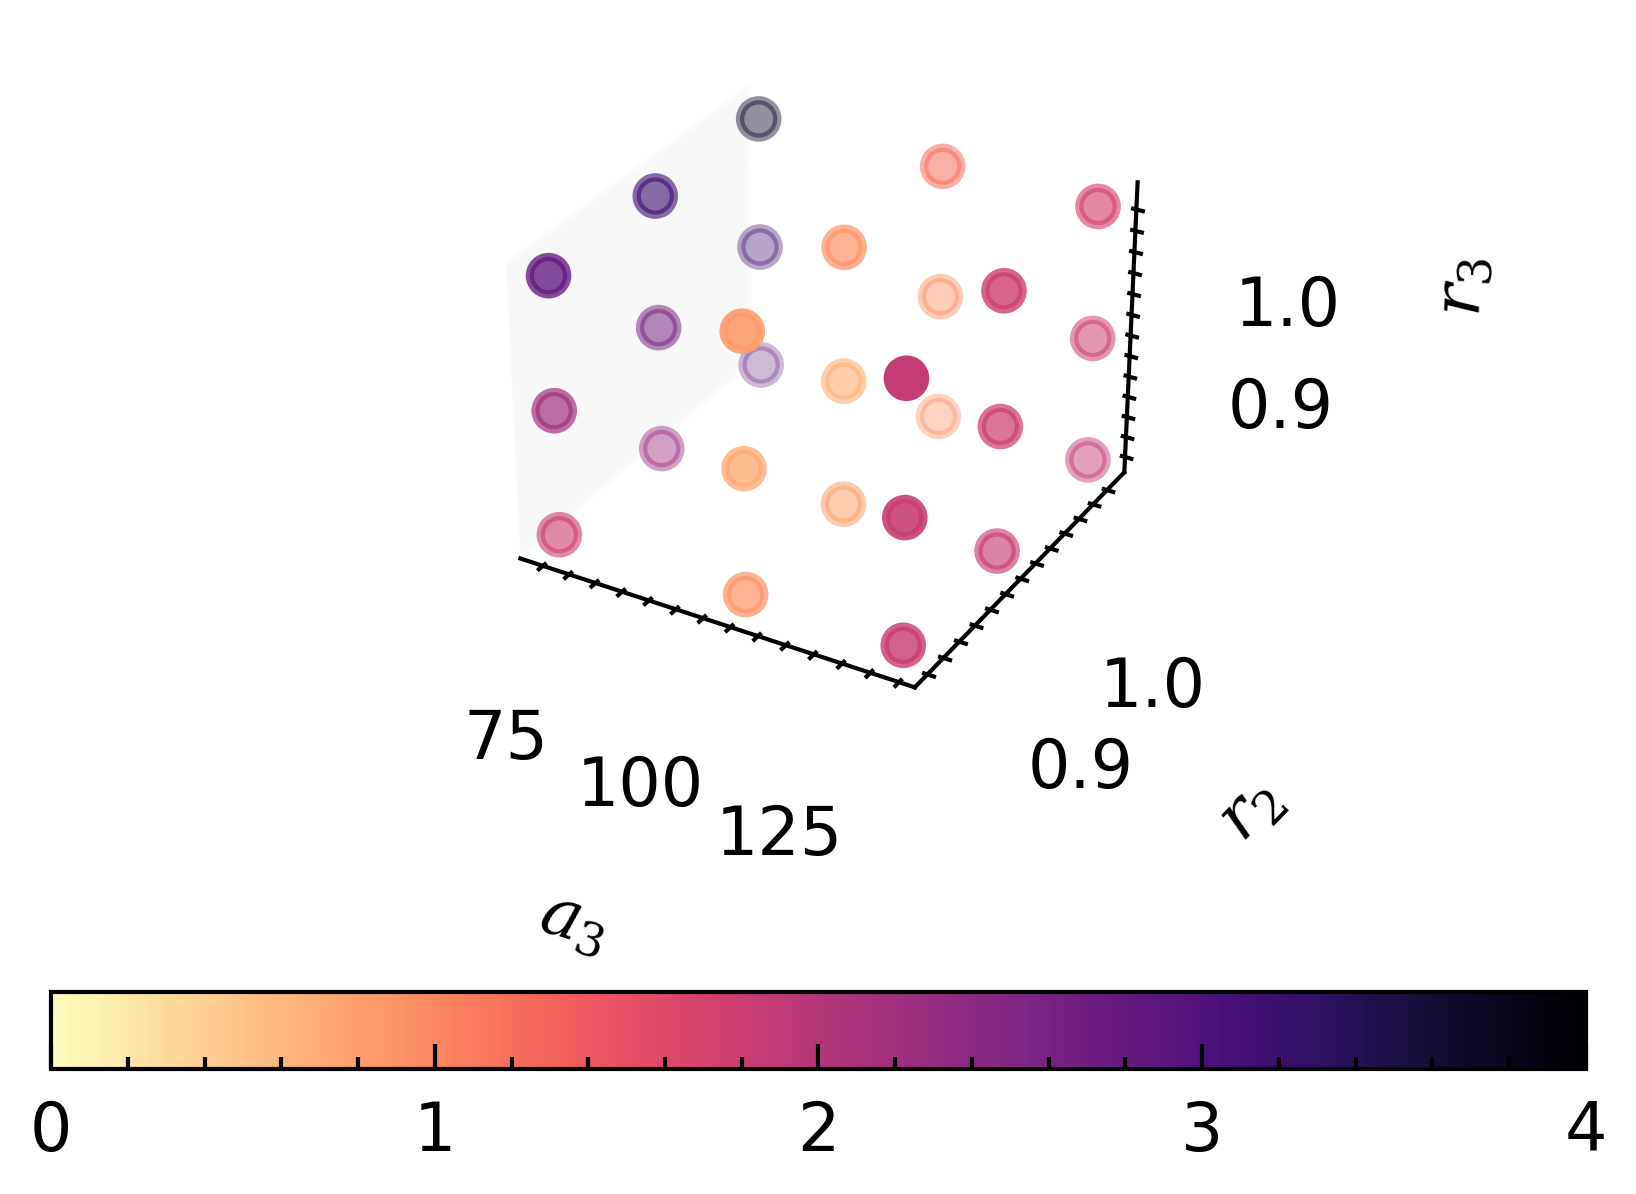

In [196]:
import numpy as np
import matplotlib.pyplot as plt


norm = mpl.colors.Normalize(vmin=0, vmax=4)
cmap = cm.magma_r
m = cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure()
ax = plt.axes(projection='3d')
p = ax.scatter(df_w_bi["a3"], df_w_bi["r2"], 
               df_w_bi["r3"], c=m.to_rgba(df_w_bi["total"]))#, alpha=1)


ax.set_xlabel("$a_3$")
ax.set_ylabel("$r_2$")
ax.set_zlabel("$r_3$")

cbar = fig.colorbar(m, ax=ax, orientation="horizontal", pad=0.23)

p.set_clim(0, 4) # Get rid of colored axes planes
# First remove fill
ax.xaxis.pane.fill = True
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# ax.plot(df_w["a3"], df_w["r2"], df_w["r3"], alpha=1, c="k", linewidth=0.5)
ax.grid(True, which="major")
ax.grid(False)
plt.savefig("First3x3x3.pdf", bbox_inches="tight")

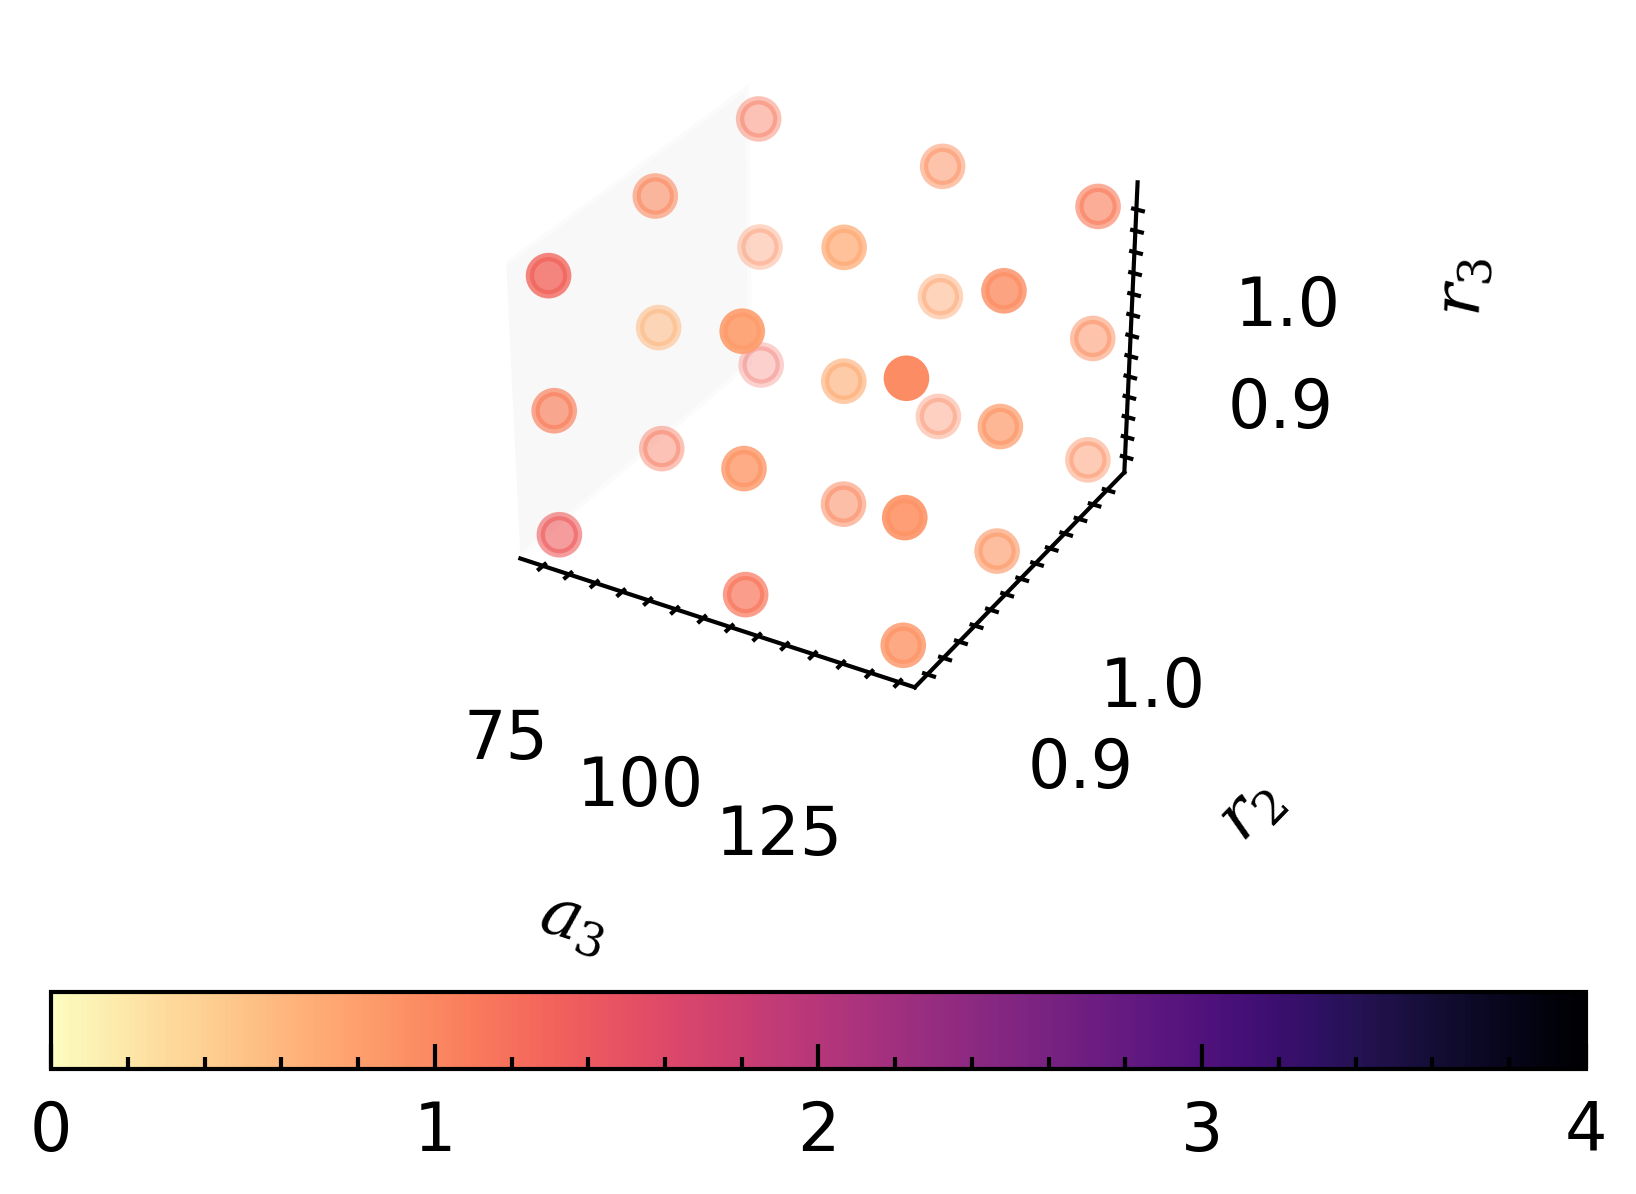

In [156]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=0, vmax=4)
cmap = cm.magma_r
m = cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure()
ax = plt.axes(projection='3d')
p = ax.scatter(df_fit_w["a3"], df_fit_w["r2"], df_fit_w["r3"], c=m.to_rgba(df_fit_w["total"]))#, alpha=1)

ax.set_xlabel("$a_3$")
ax.set_ylabel("$r_2$")
ax.set_zlabel("$r_3$")

fig.colorbar(m, ax=ax, orientation="horizontal", pad=0.23)

p.set_clim(0, 4) # Get rid of colored axes planes
# p = ax.scatter(df_fit_w["a3"], df_fit_w["r2"], df_fit_w["r3"], c=df_fit_w["total"])#, alpha=1)

# First remove fill
ax.xaxis.pane.fill = True
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# ax.plot(df_w["a3"], df_w["r2"], df_w["r3"], alpha=1, c="k", linewidth=0.5)
ax.grid(False)
df_fit_w["total"].max()
plt.savefig("2nd3x3x3.pdf", bbox_inches="tight")

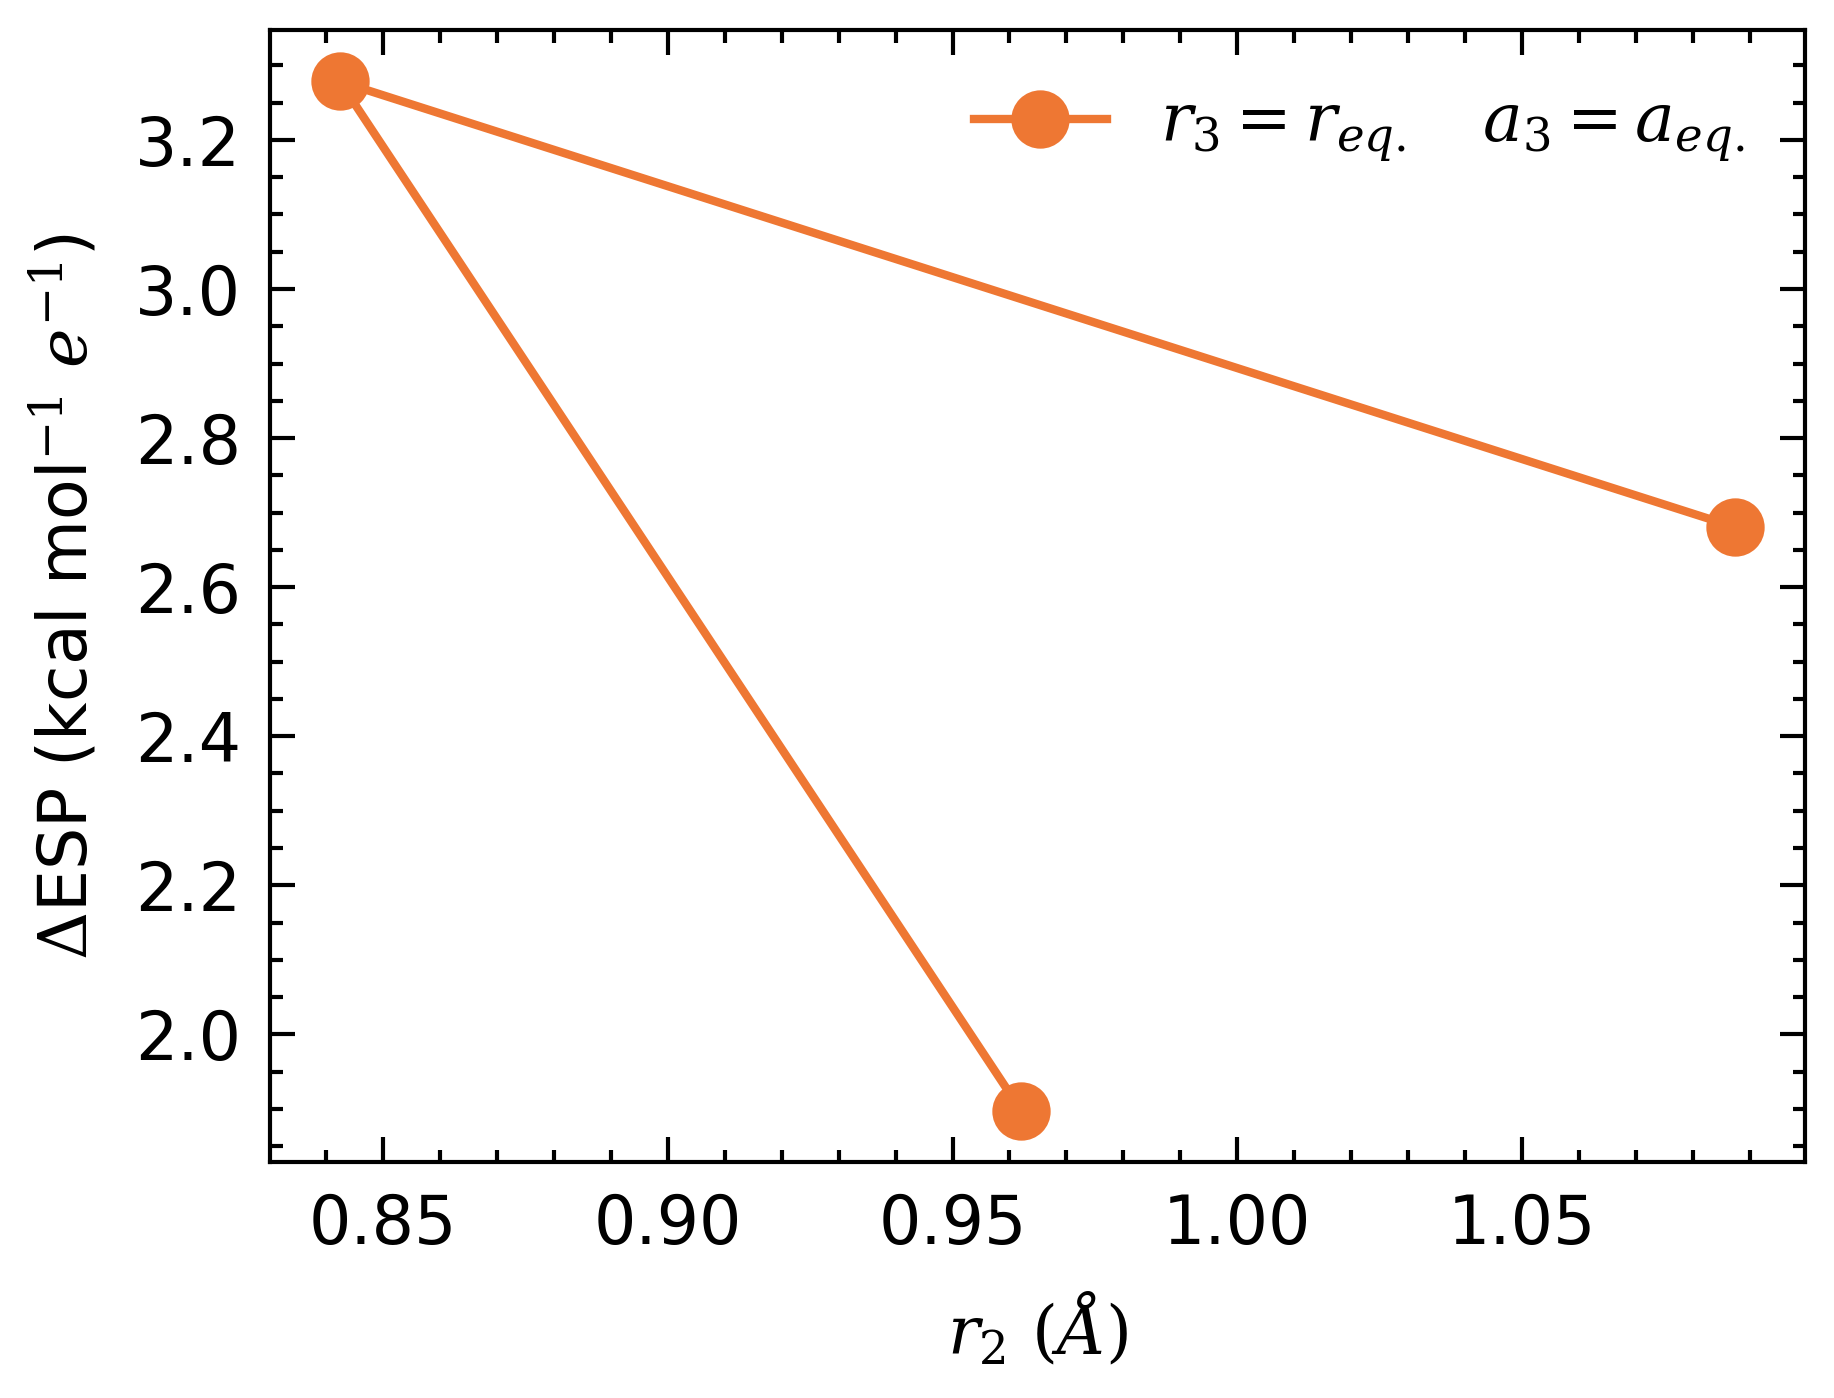

In [158]:
index = 1
tmp_df = df_w[df_w["r3"]==r3_values[index]]
tmp_df = tmp_df[tmp_df["a3"]==a3_values[index]]
plt.plot(tmp_df["r2"], tmp_df["total"], "-o", label="$r_3 = r_{eq.}$   $a_3 = a_{eq.}$")
plt.ylabel("$\Delta$ESP (kcal mol$^{-1}$ $e^{-1}$)")
plt.xlabel("$r_2$ $(\AA)$")
# plt.ylim(0,2.6)
plt.legend()
plt.savefig("r2_0.pdf", bbox_inches="tight")


In [41]:
a3_values = np.arange(eq_a3 - 30, eq_a3 + 30, 5)
df_w_angle = get_FDCM_data("/home/boittier/FDCM/angle", "water_angle10.csv")
df_w_angle["dihedral"] = [a3_values[int(x)] for x in list(df_w_angle["dihedral"])]
df_w_angle = df_w_angle.sort_values("dihedral")


In [42]:
df_w_angle
a3_values

array([ 75.04,  80.04,  85.04,  90.04,  95.04, 100.04, 105.04, 110.04,
       115.04, 120.04, 125.04, 130.04, 135.04])

<AxesSubplot:xlabel='dihedral'>

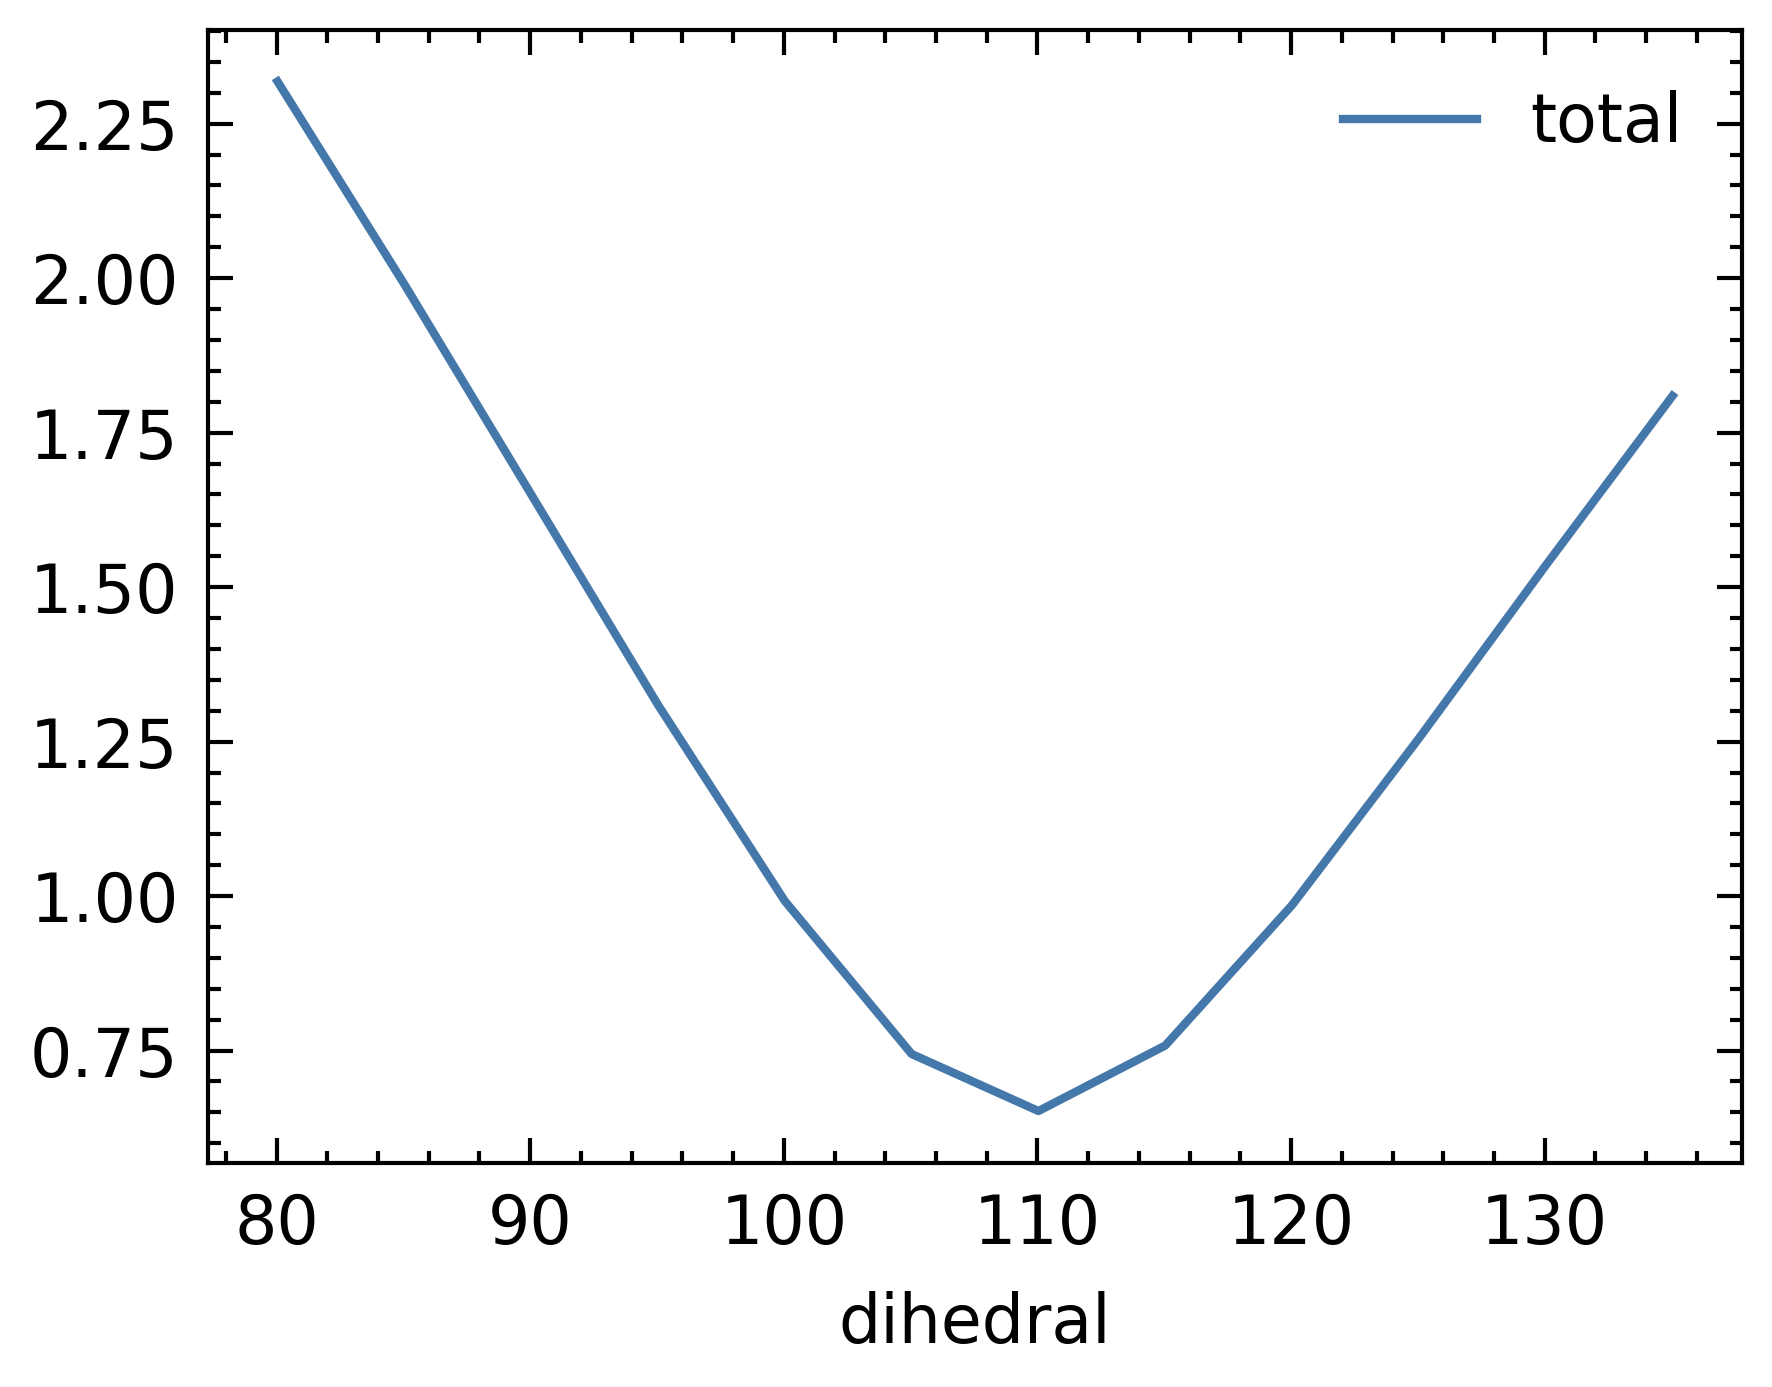

In [43]:
df_w_angle.plot("dihedral", "total")


In [13]:
# for i in range(6):
#     plot_charge(i, df_w_angle, "hello")

<AxesSubplot:xlabel='dihedral'>

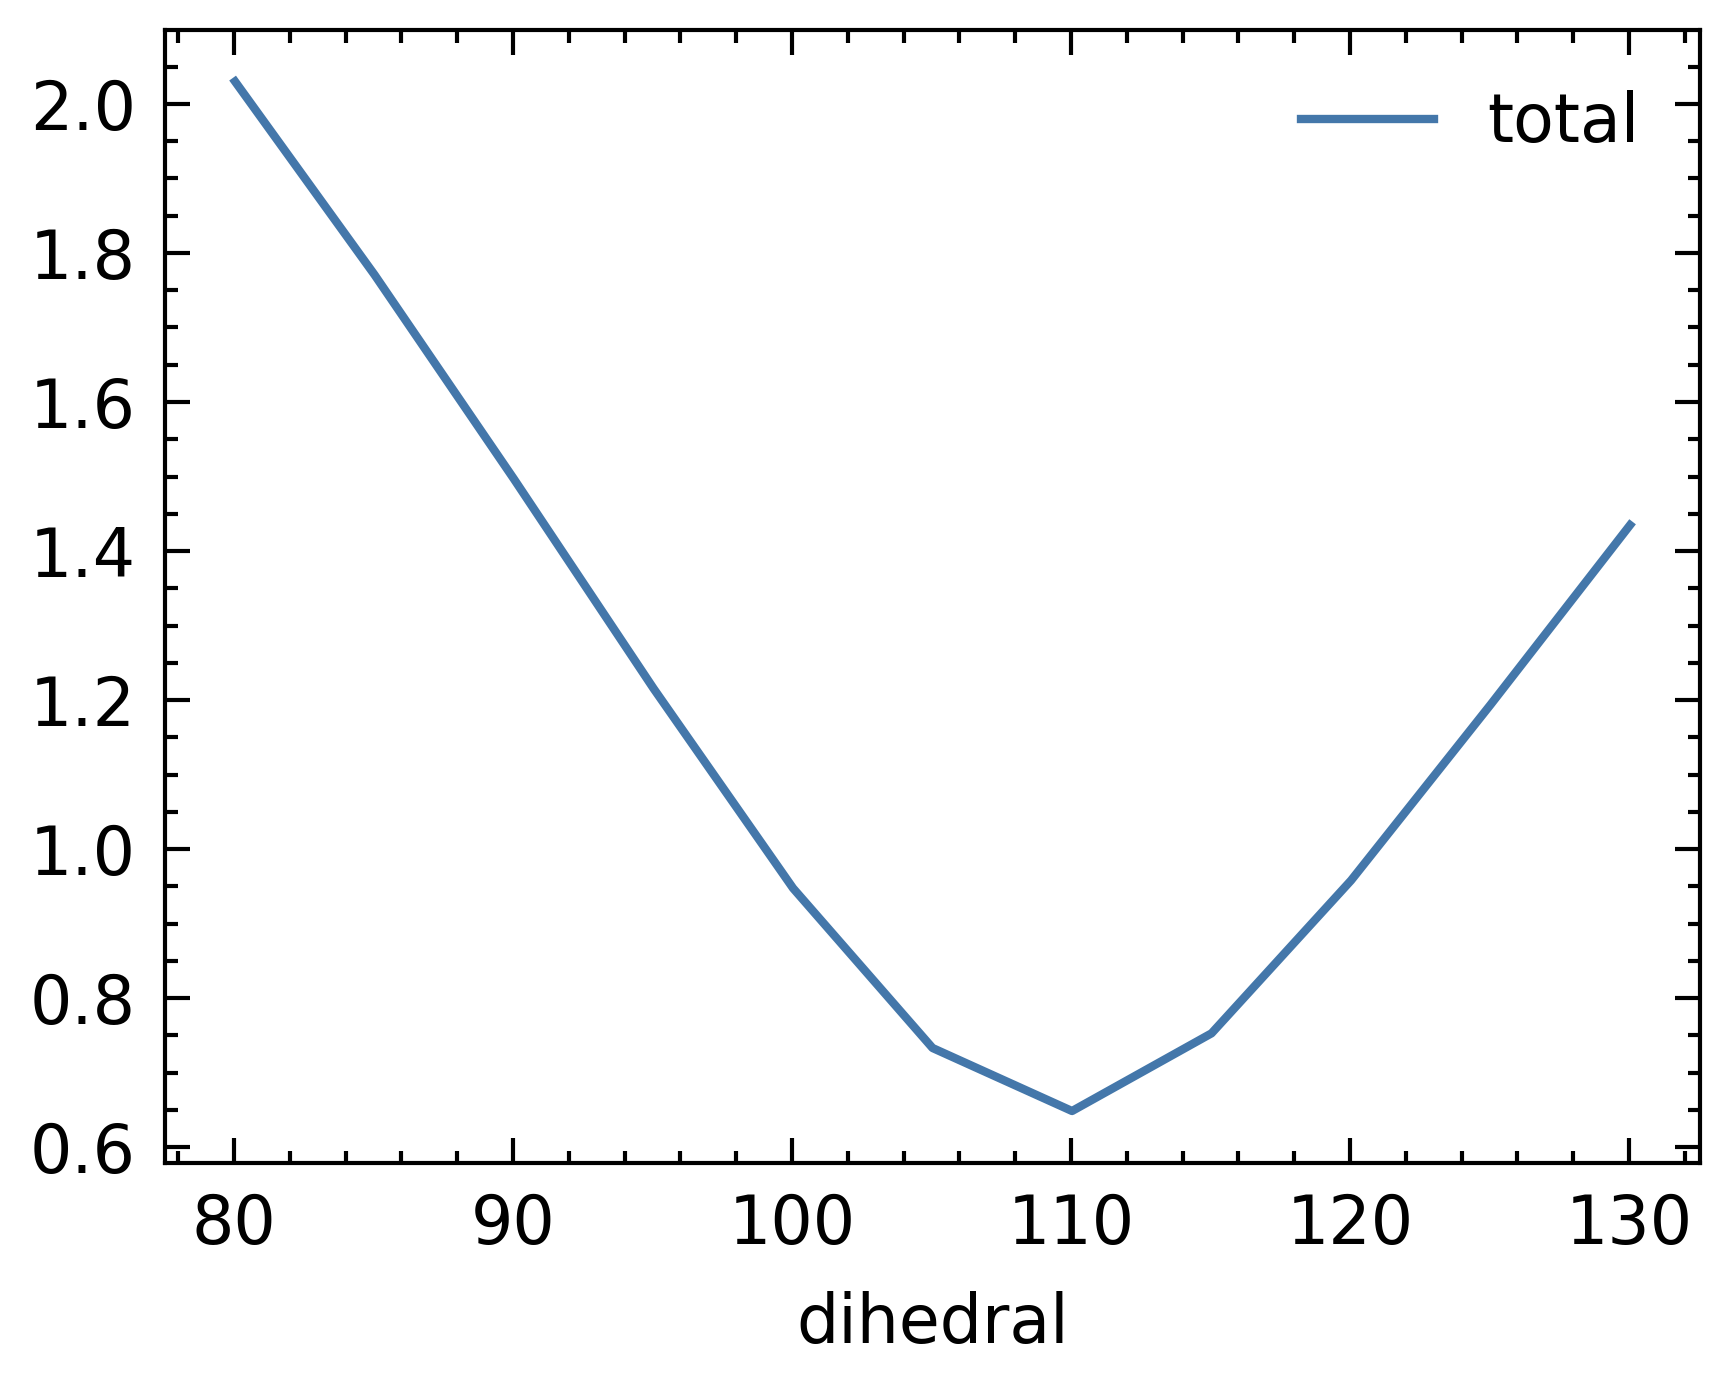

In [47]:
df_w_angle_10 = get_FDCM_data("/home/boittier/FDCM/angle_10", "water_angle10.csv")
df_w_angle_10["dihedral"] = [a3_values[int(x)] for x in list(df_w_angle_10["dihedral"])]
df_w_angle_10 = df_w_angle_10.sort_values("dihedral")
df_w_angle_10.plot("dihedral", "total")

# for i in range(6):
#     plot_charge(i, df_w_angle_10, "hello")



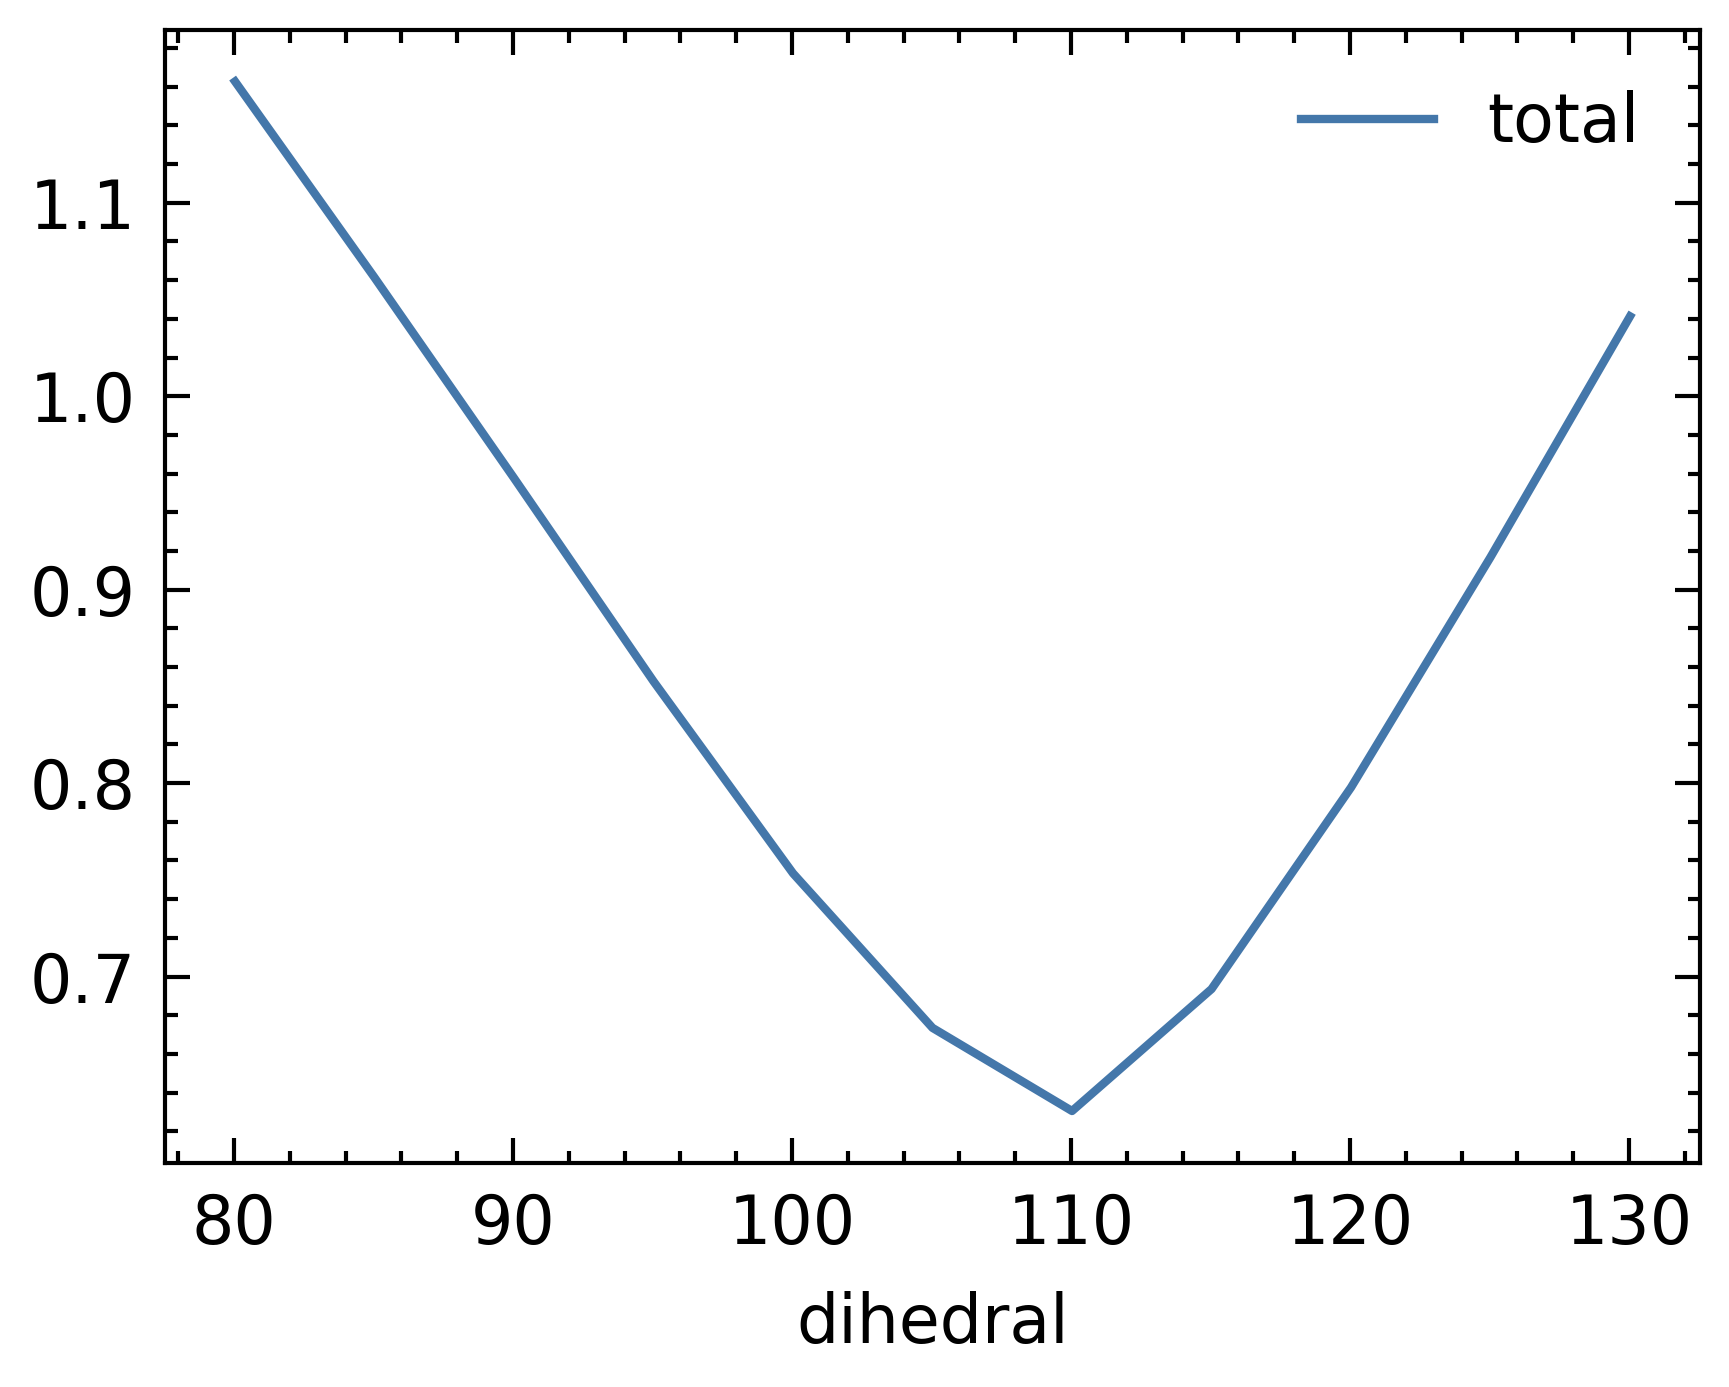

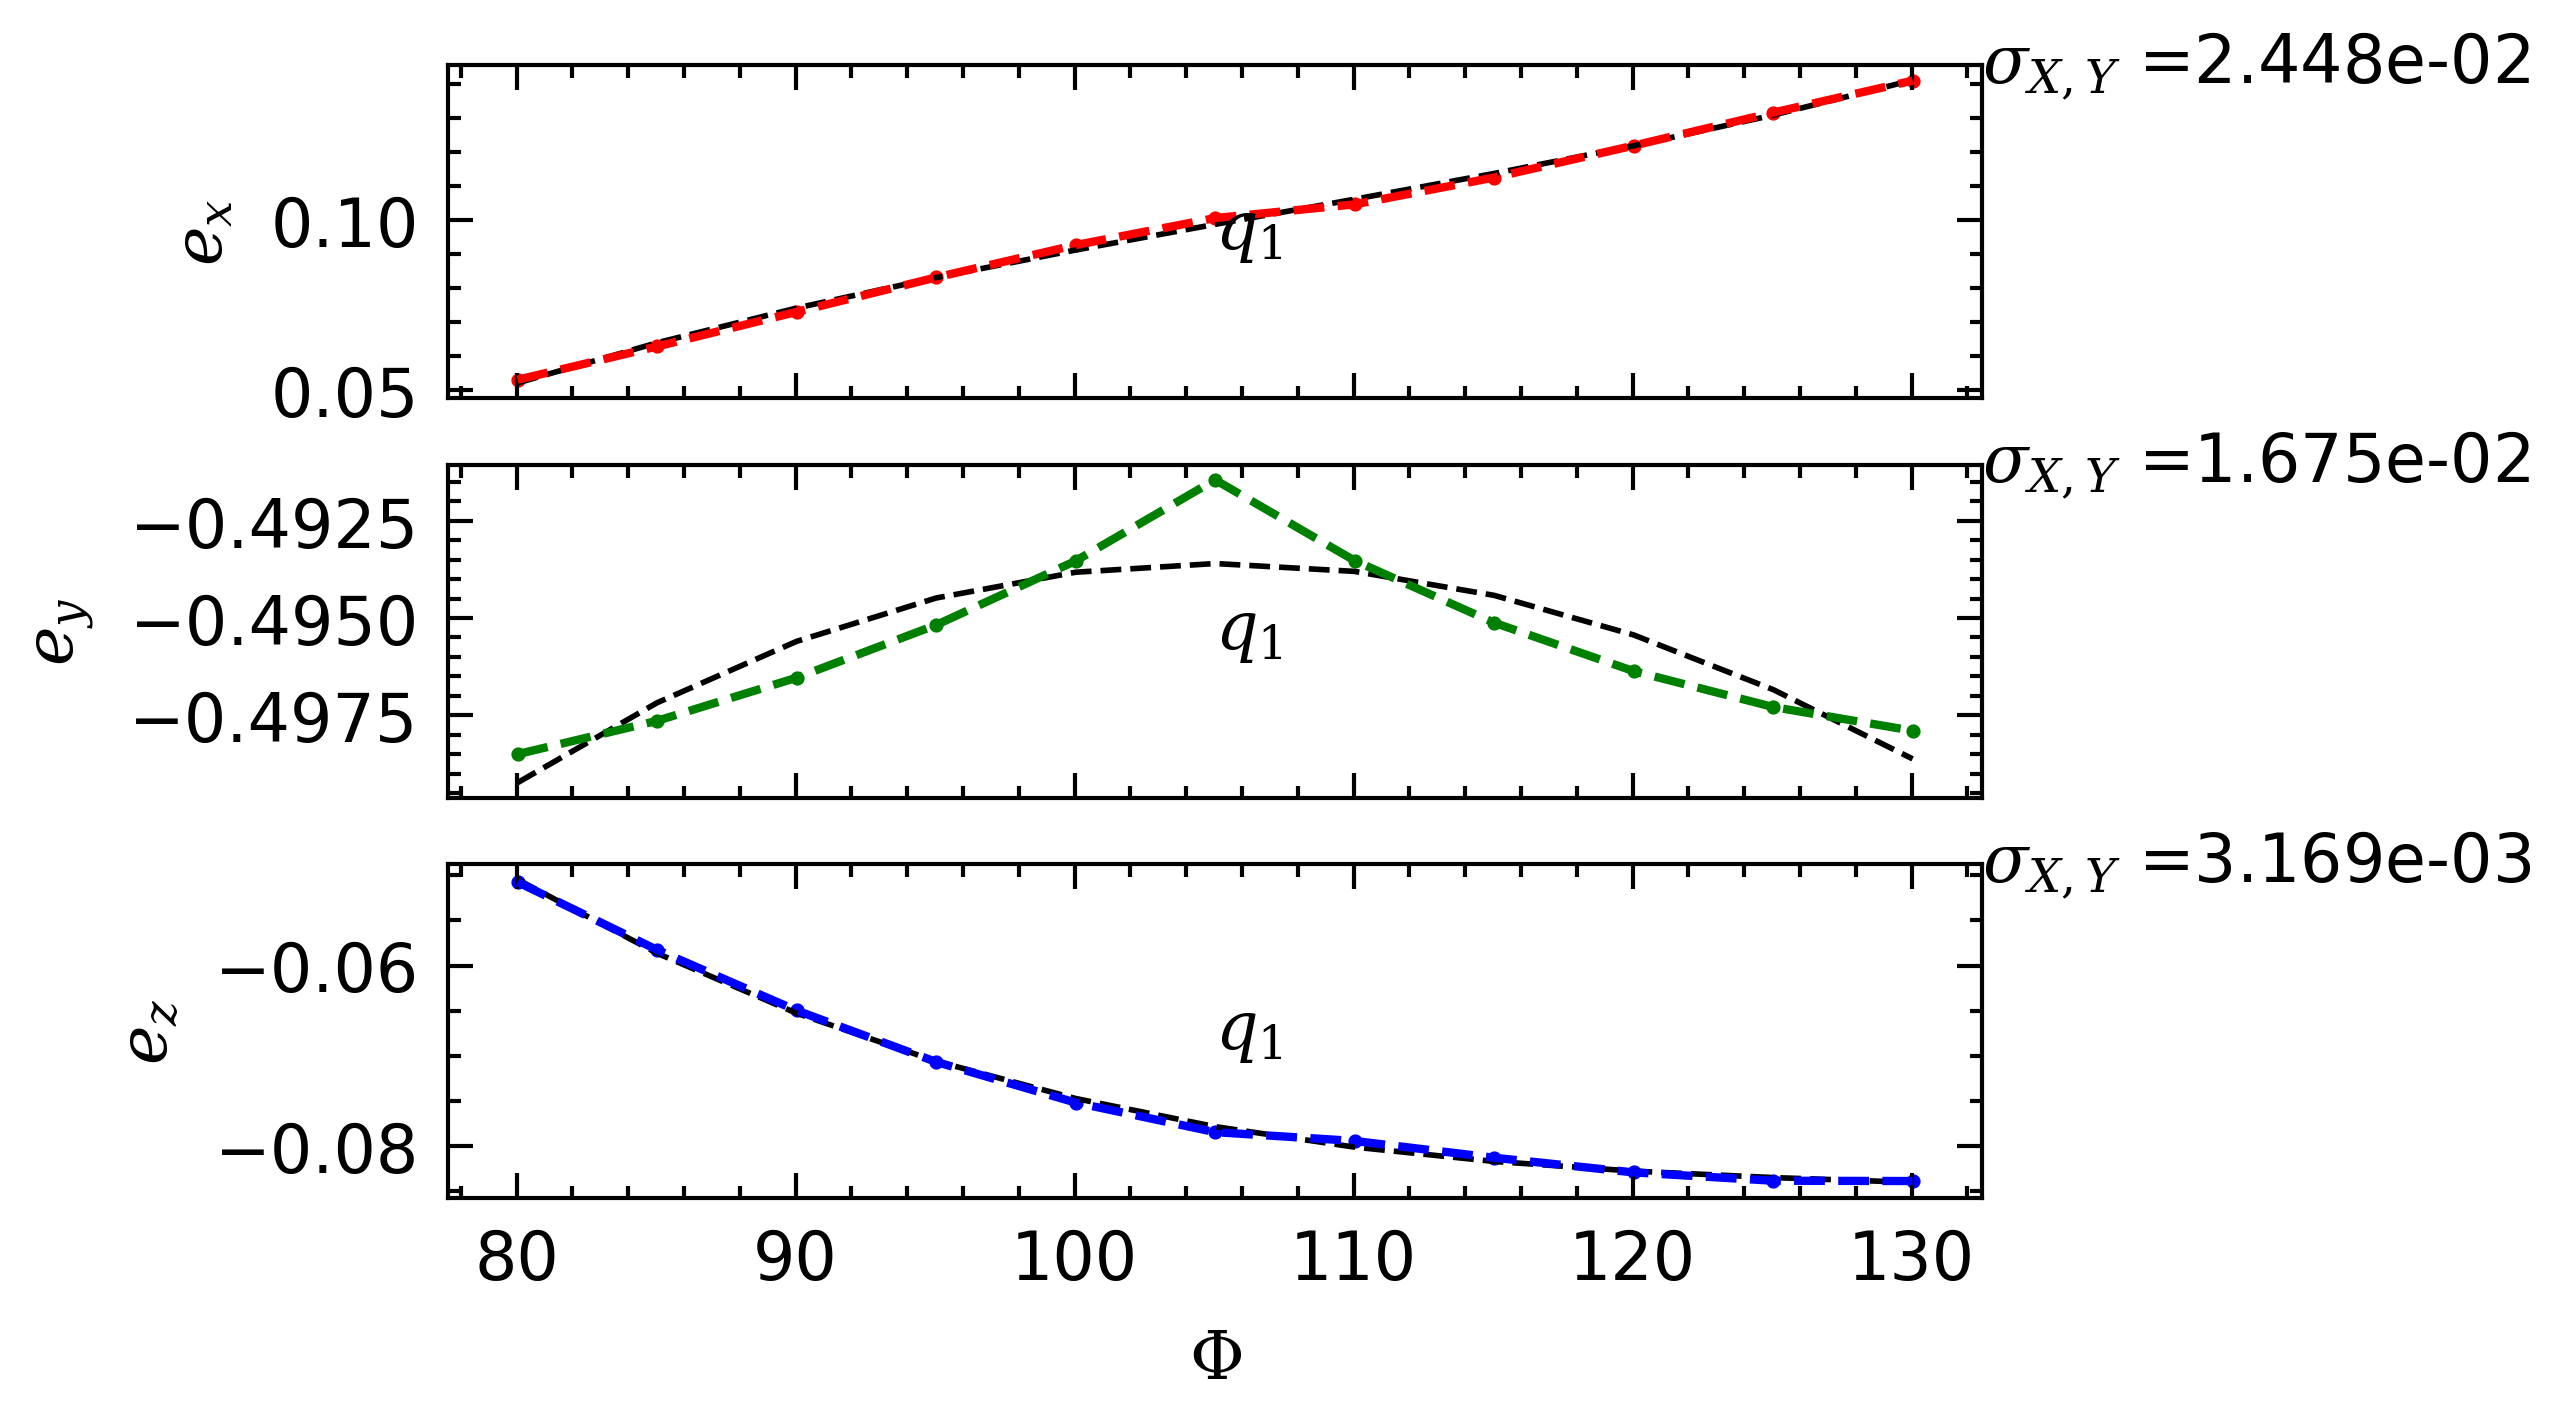

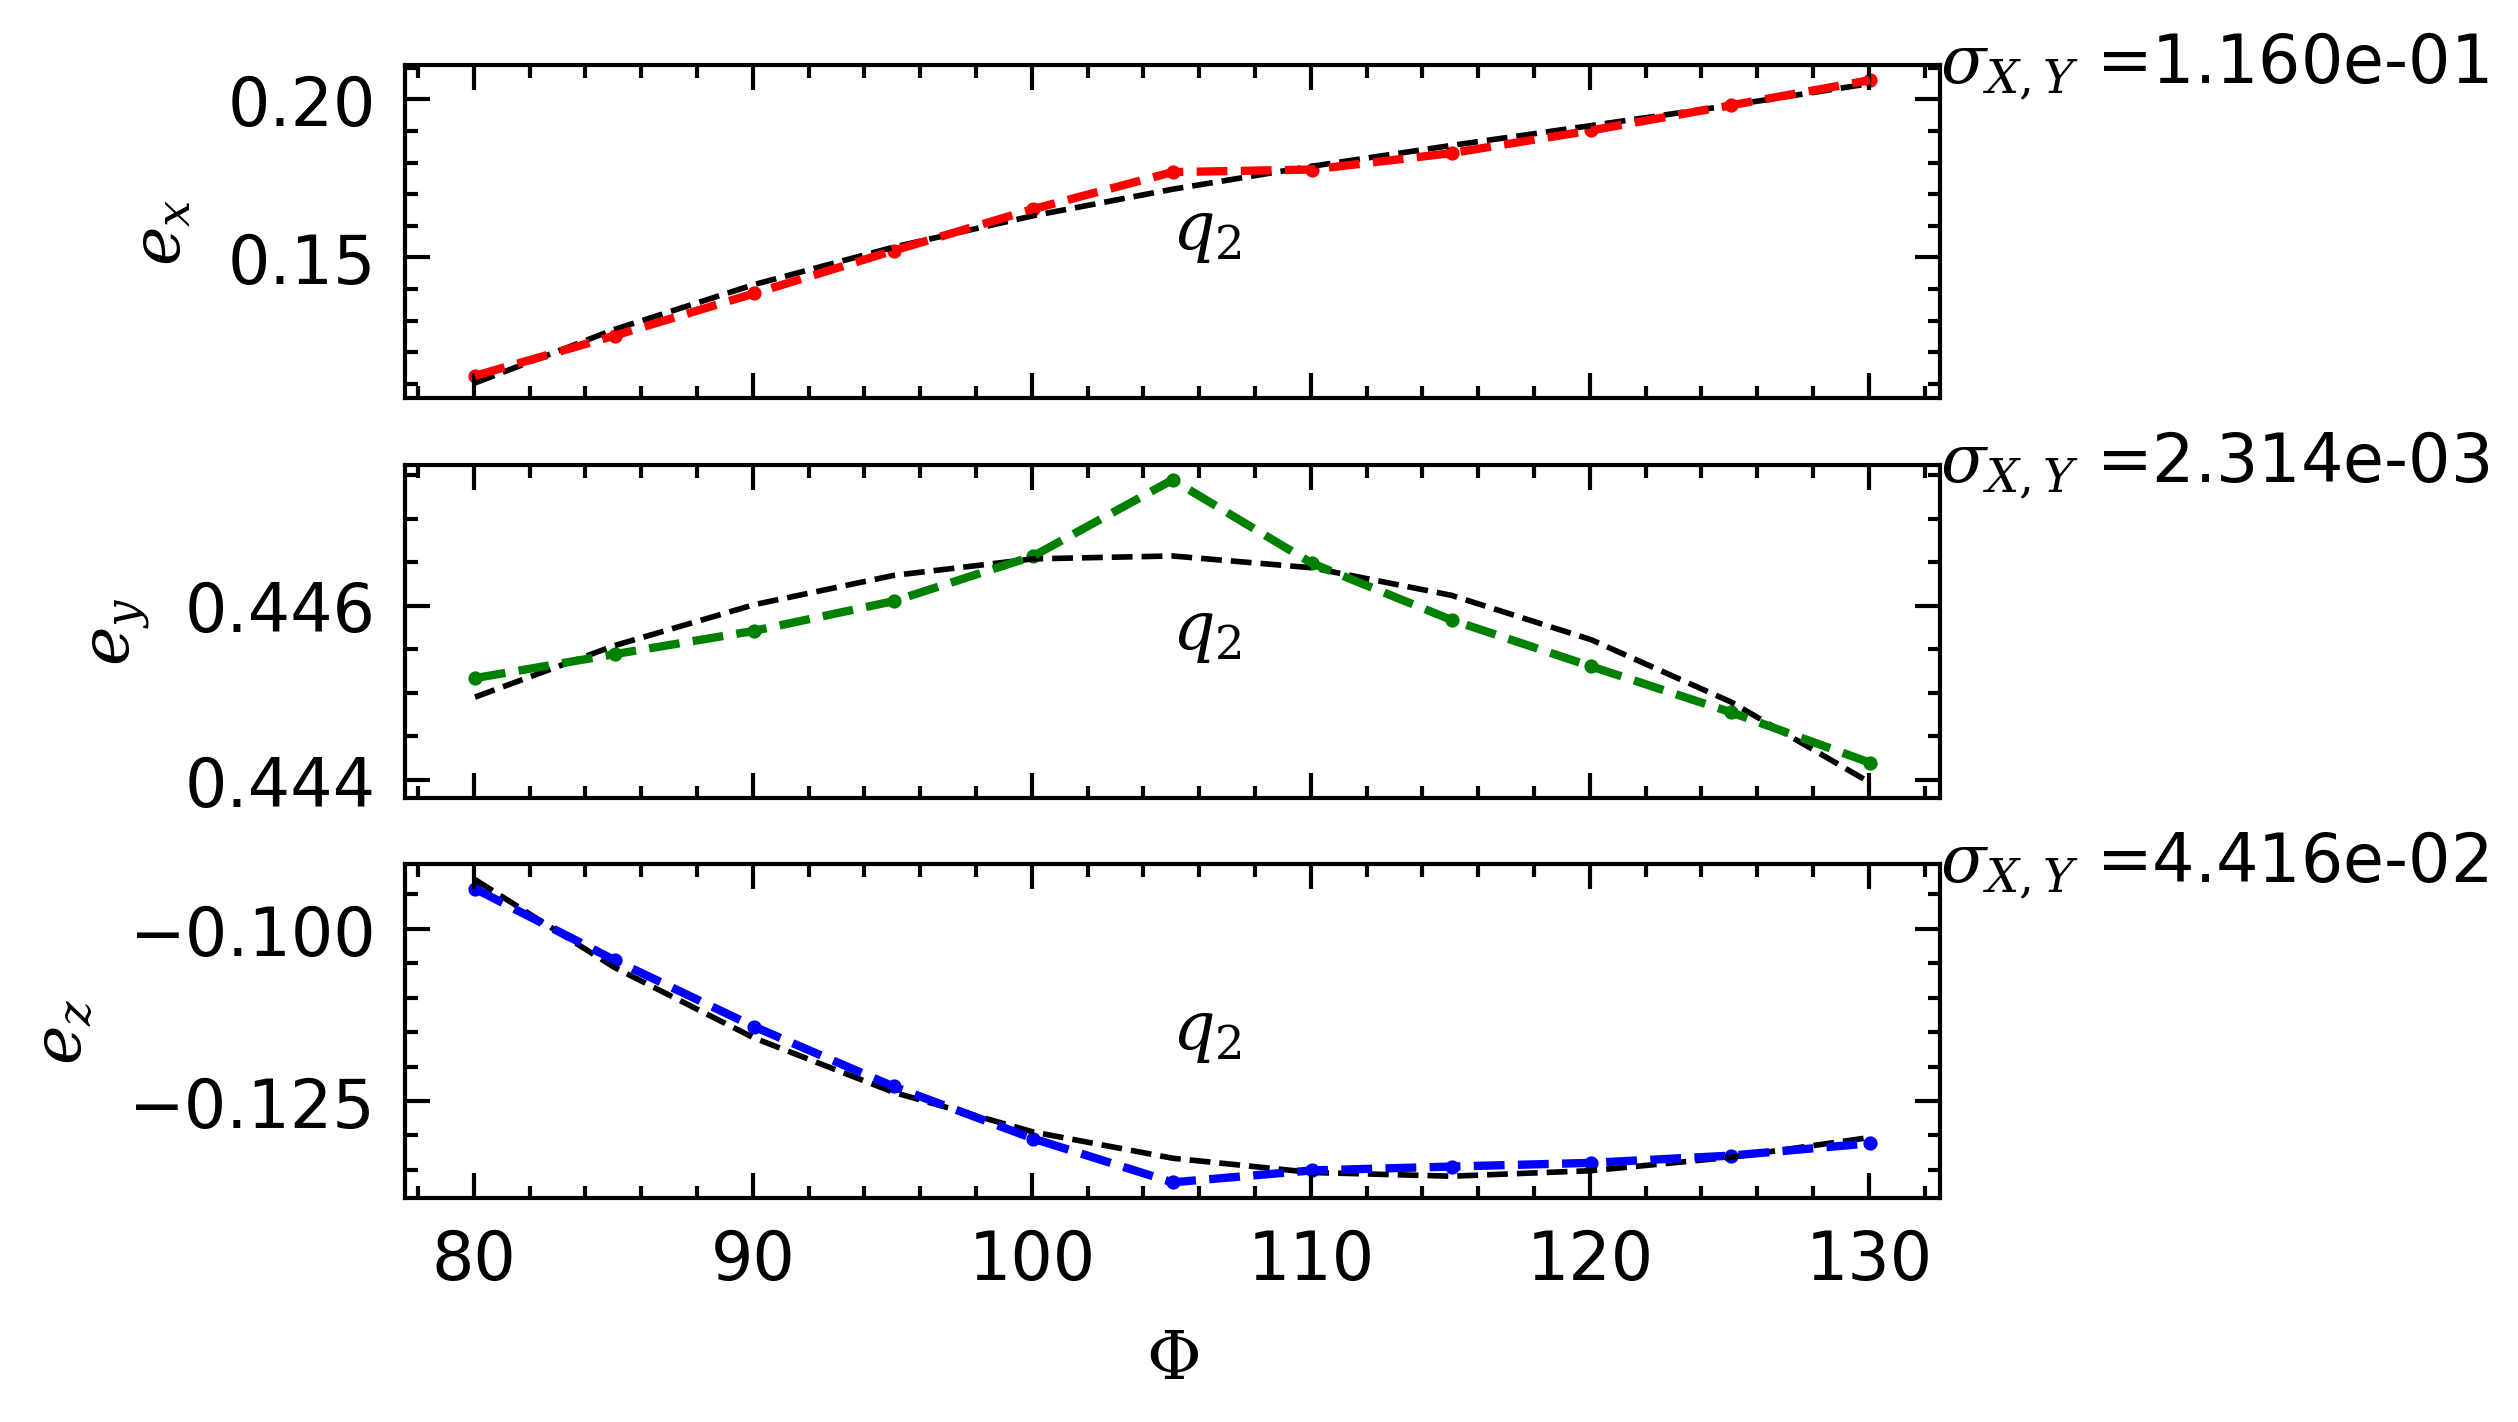

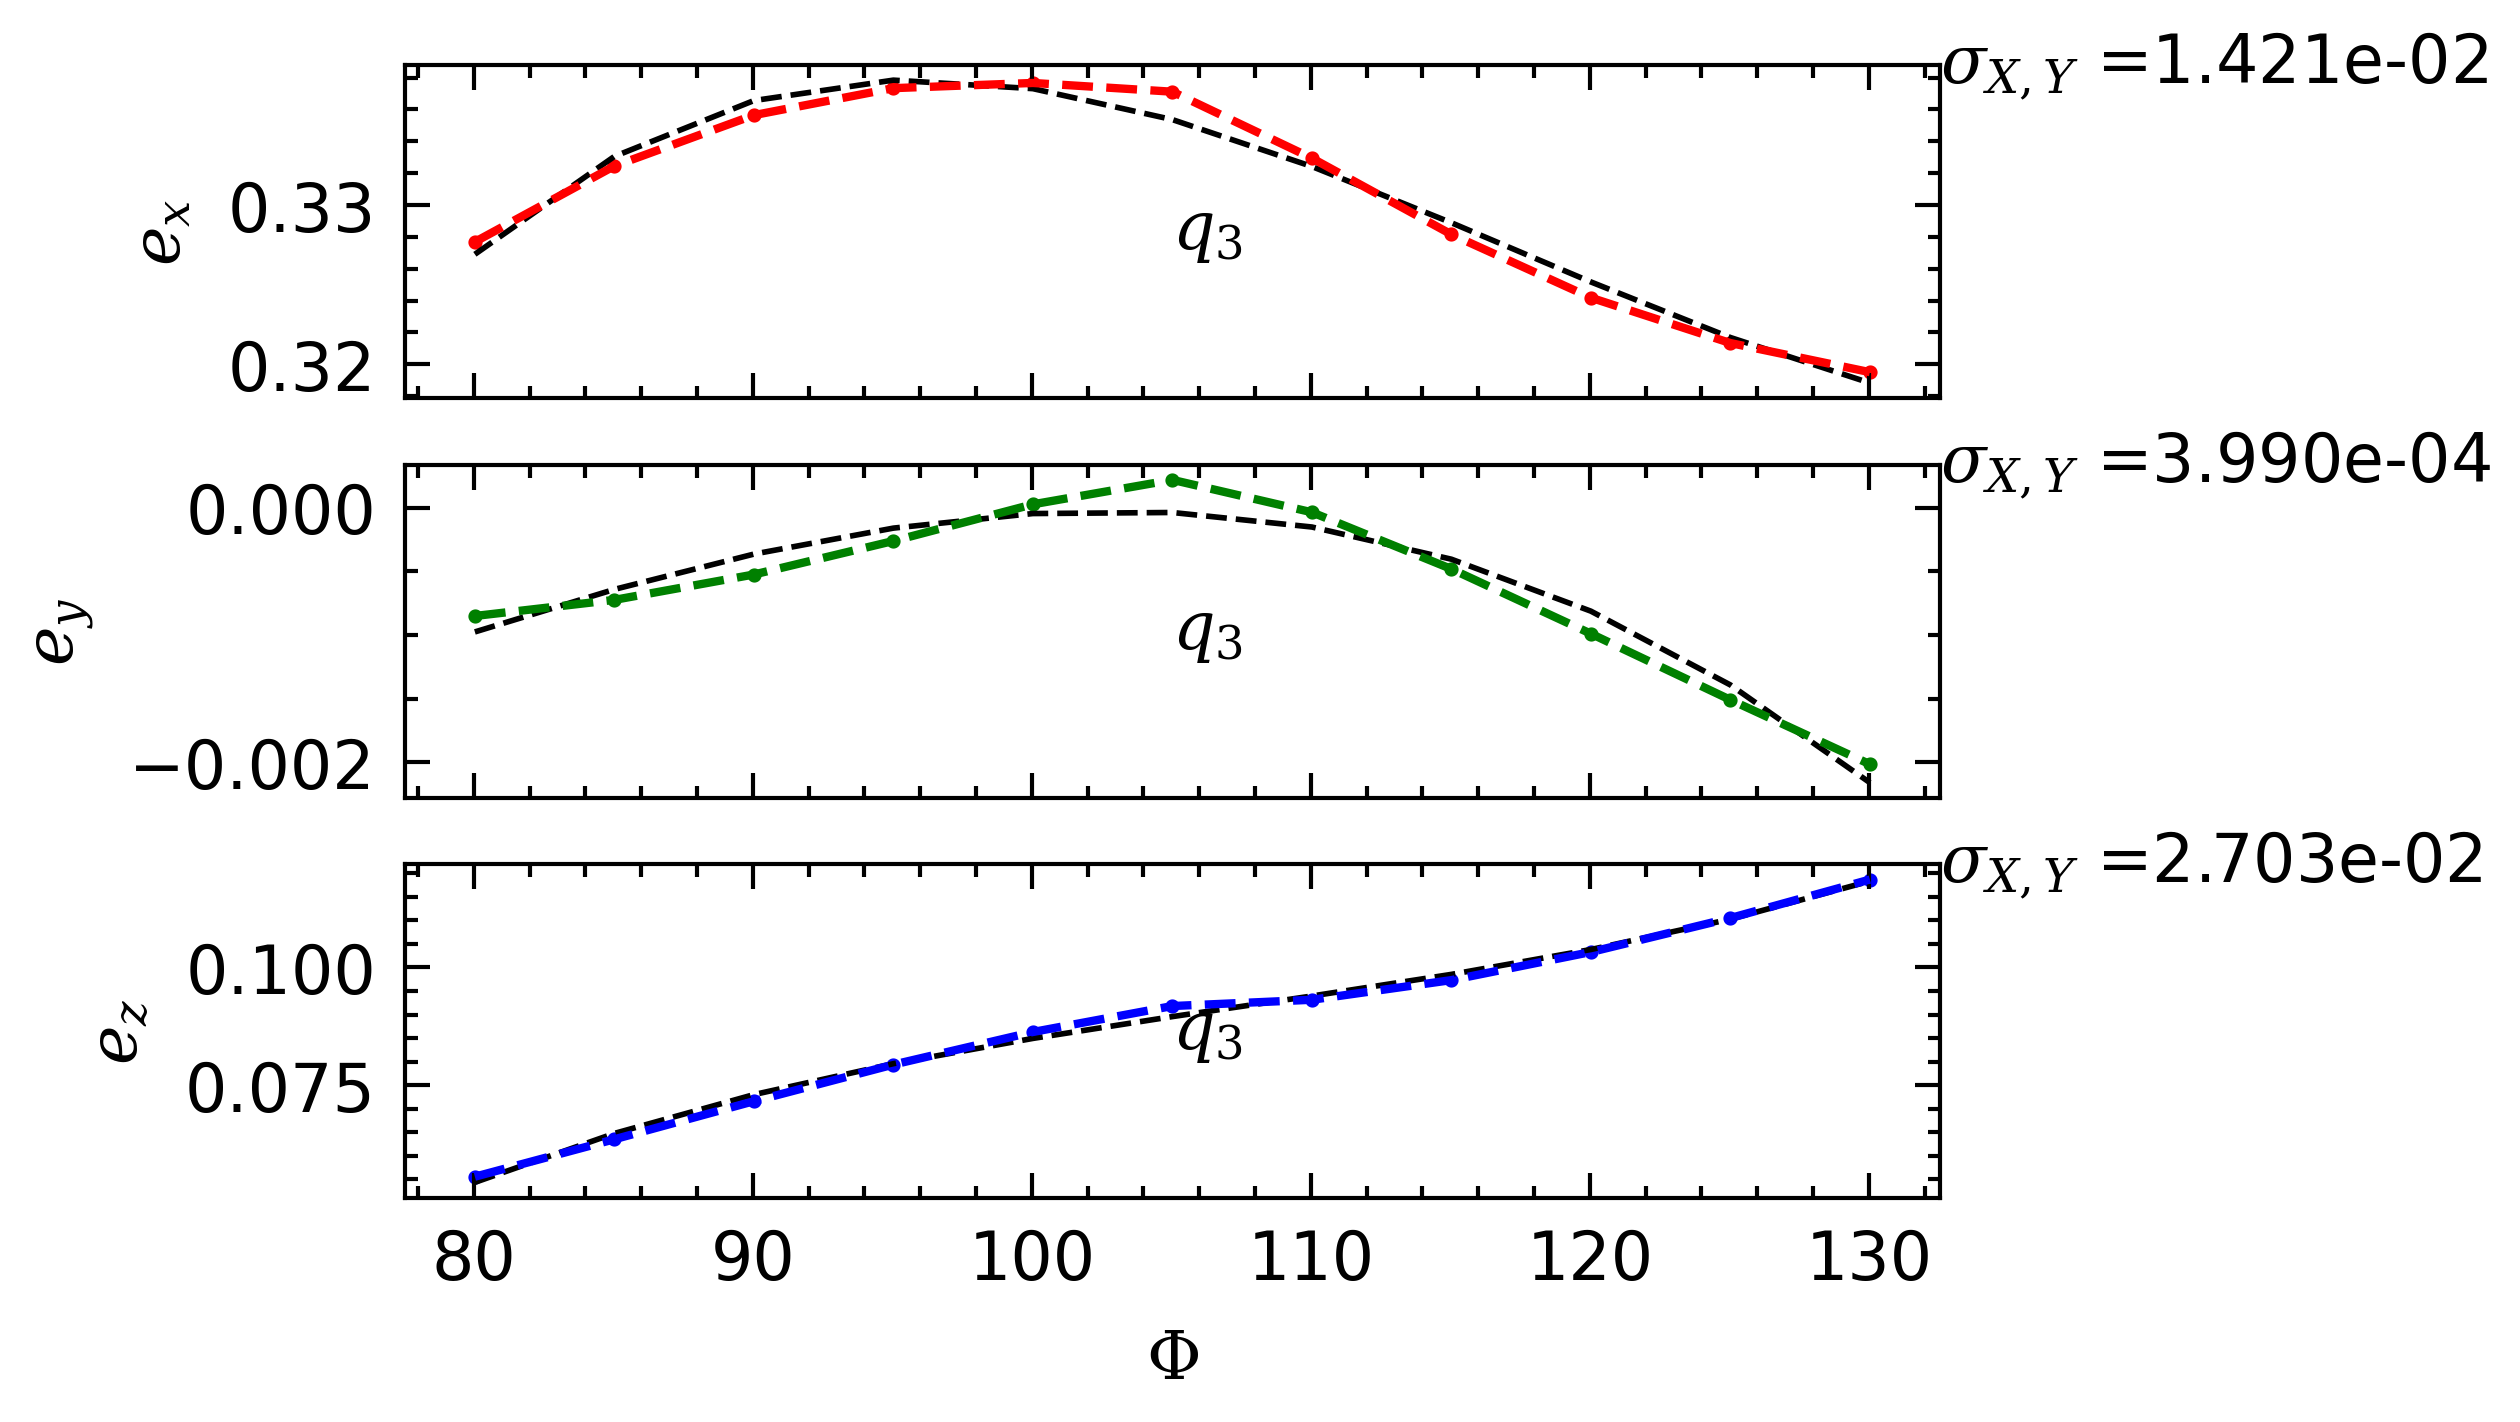

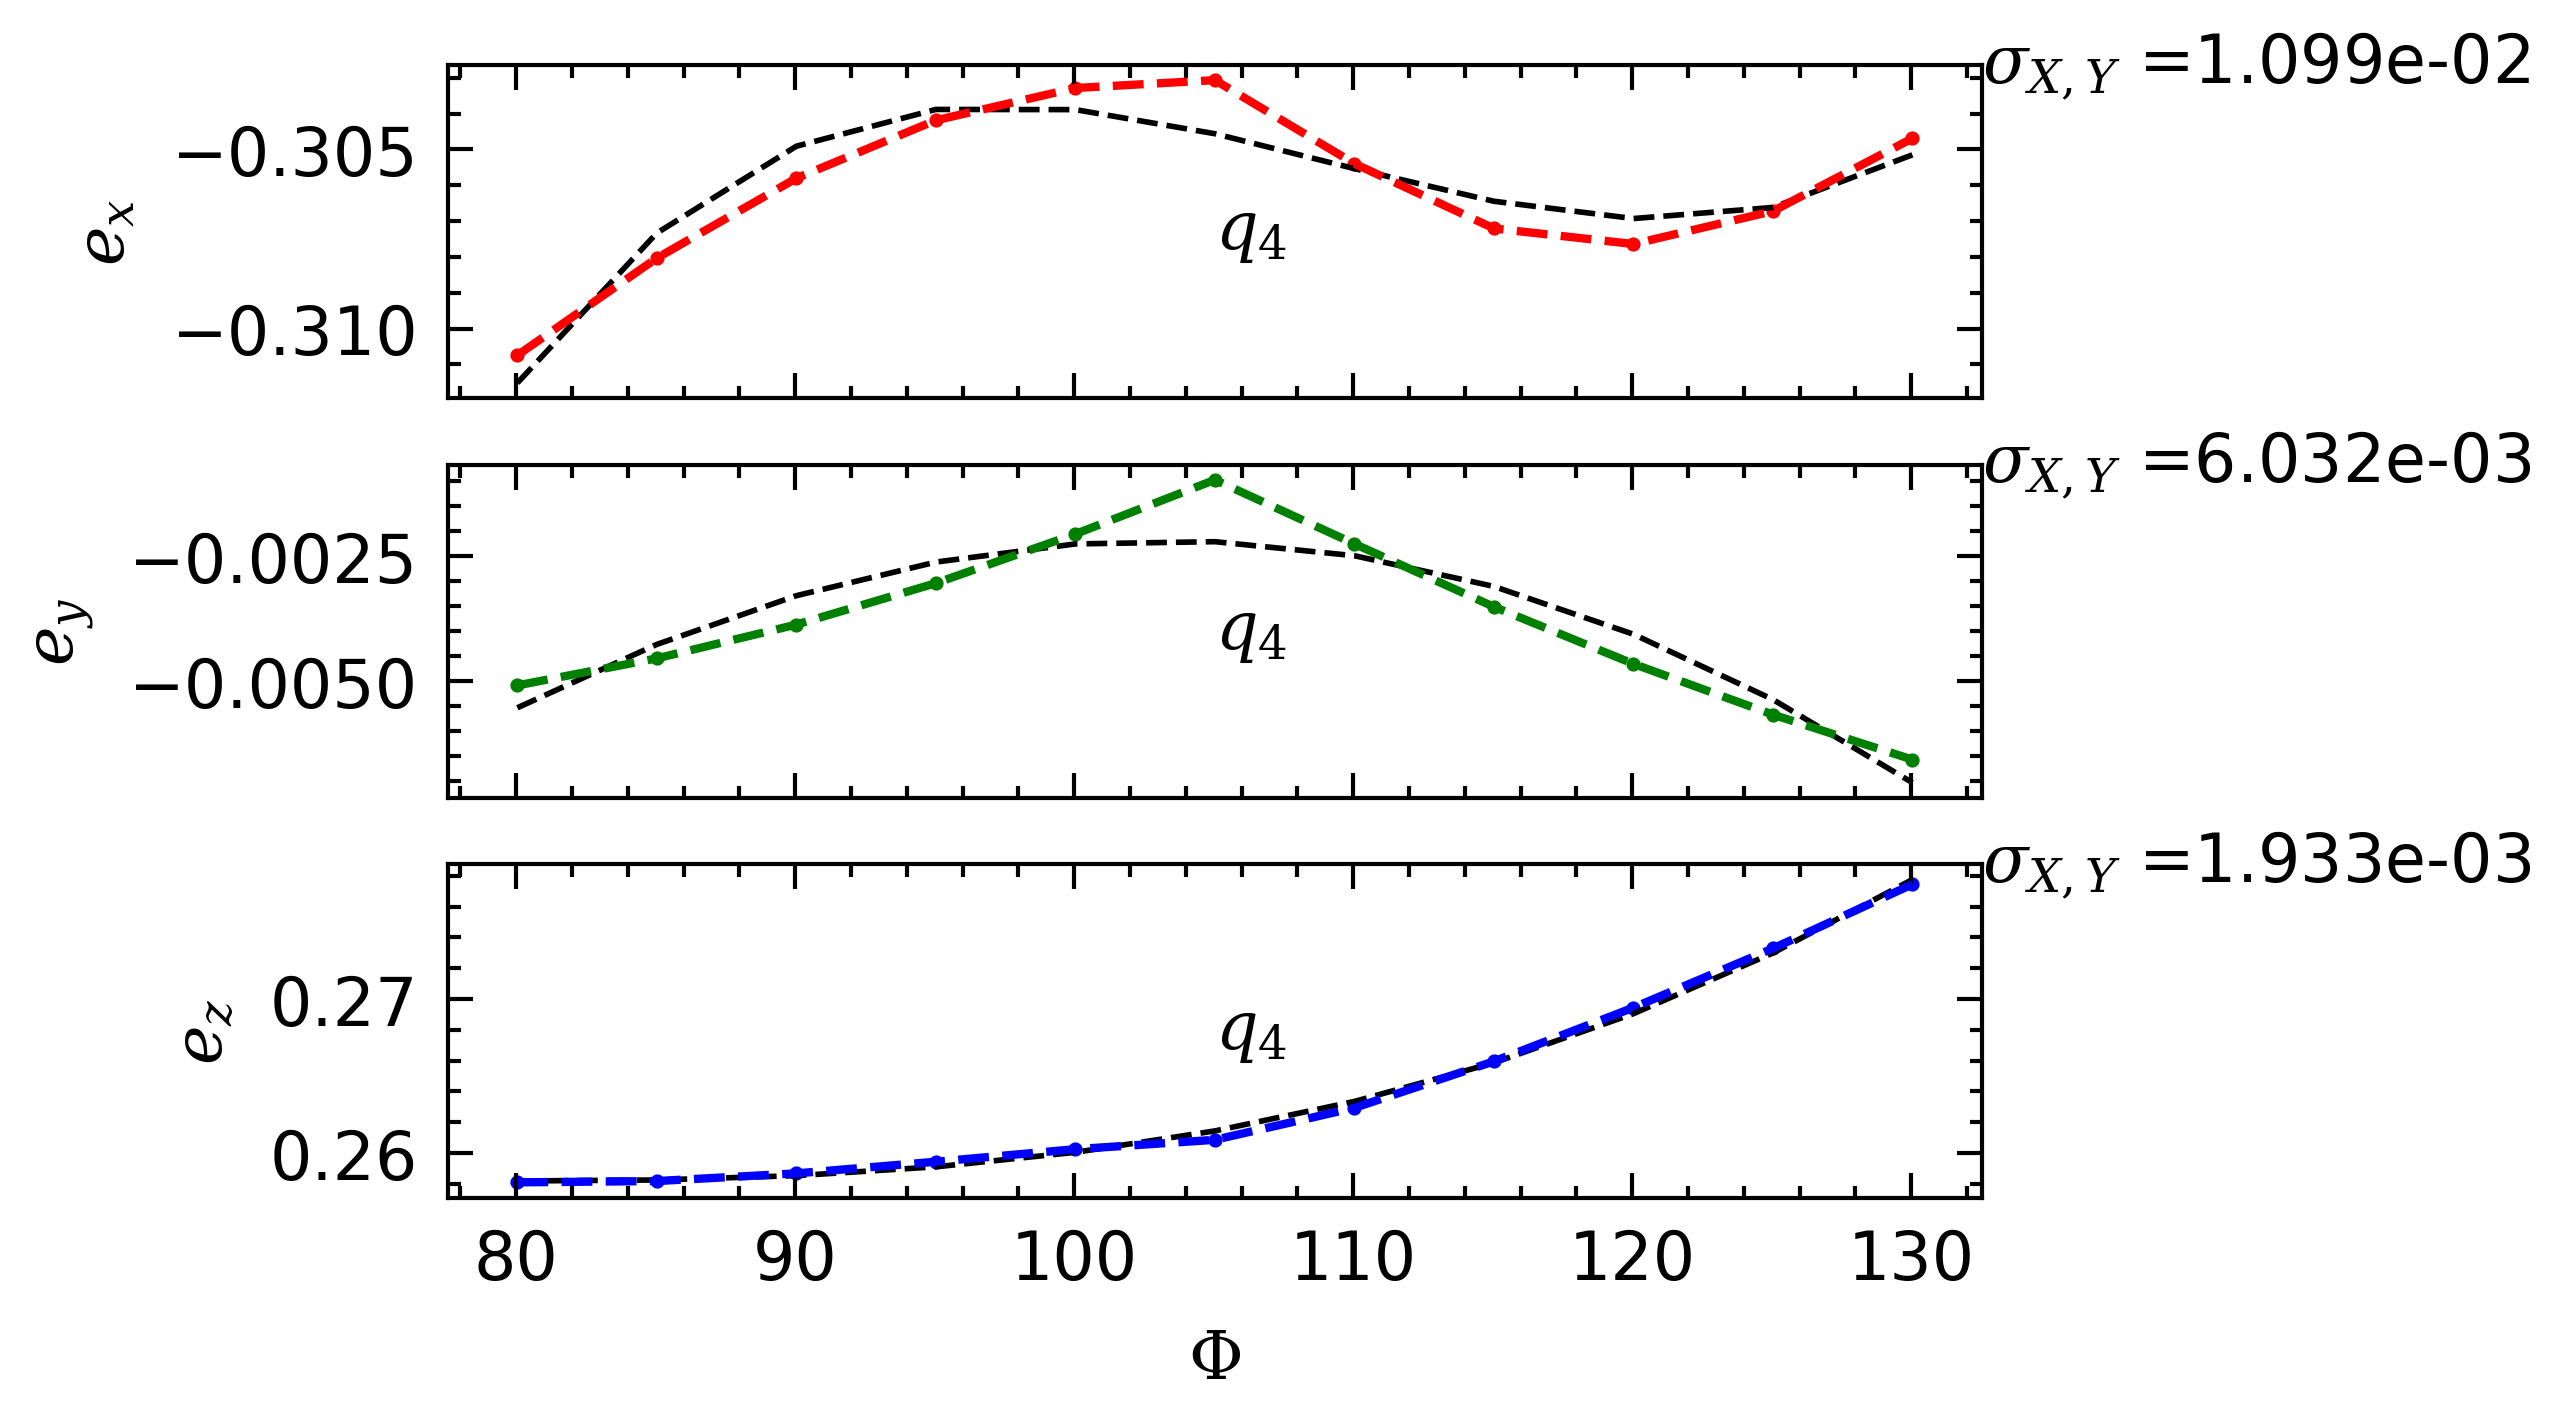

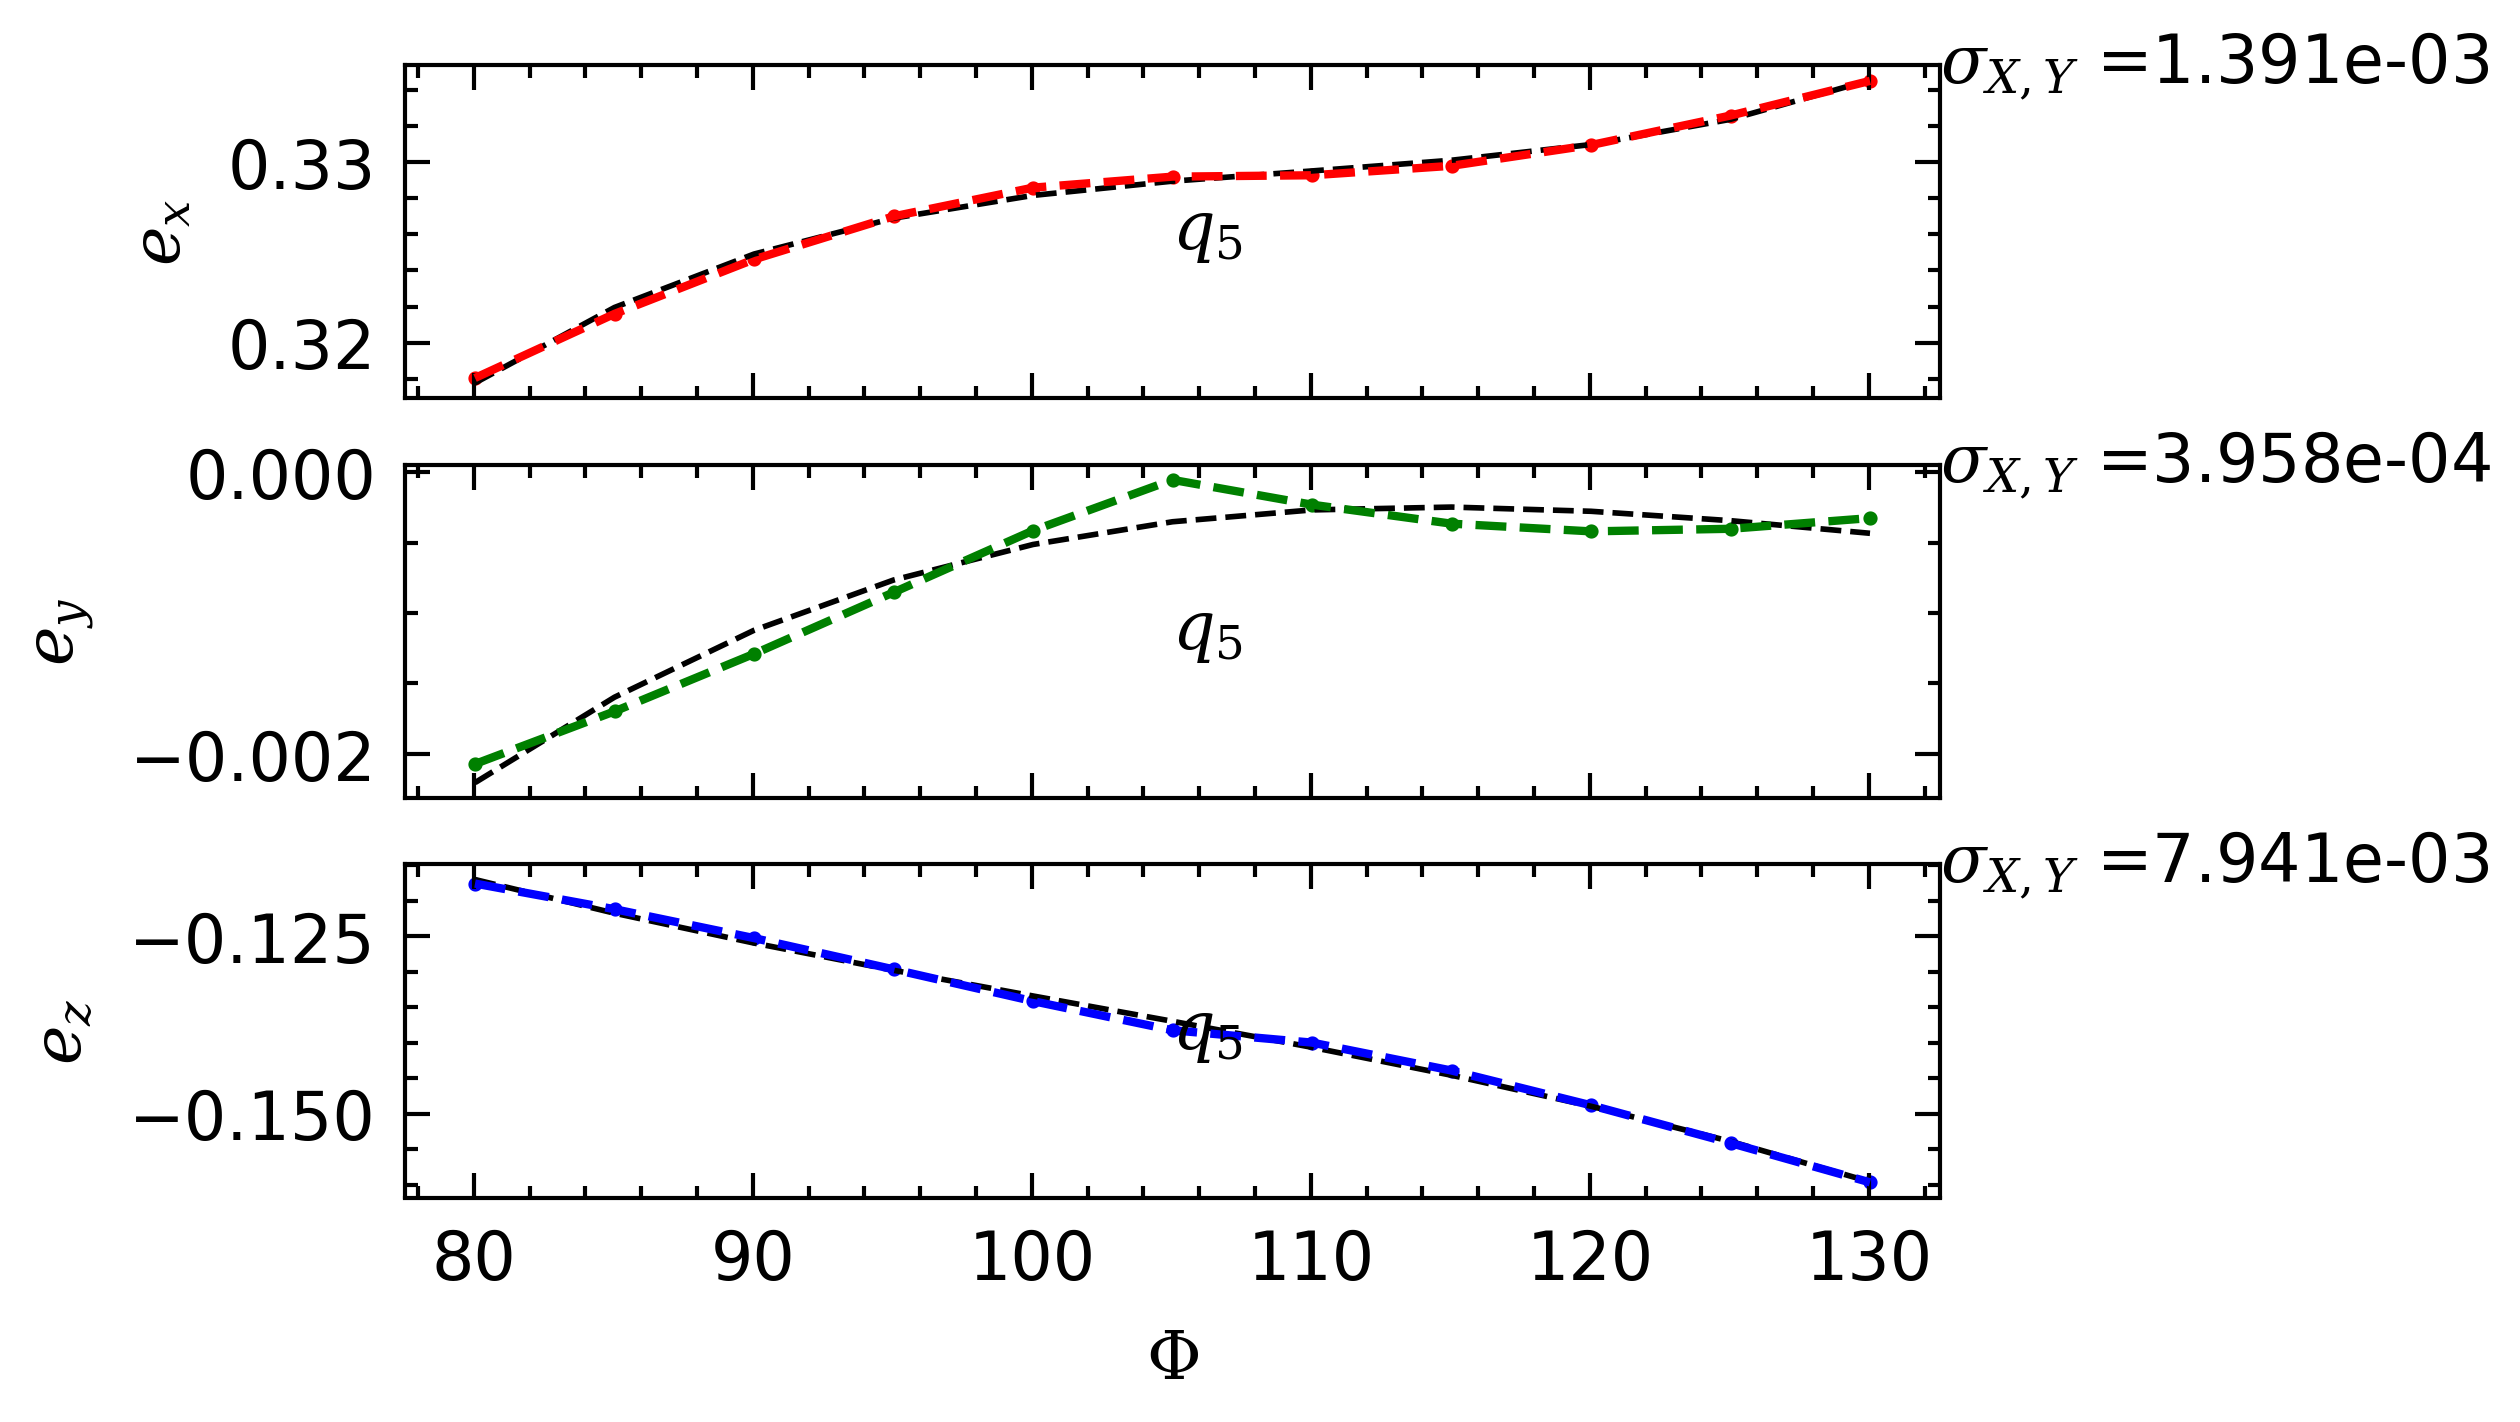

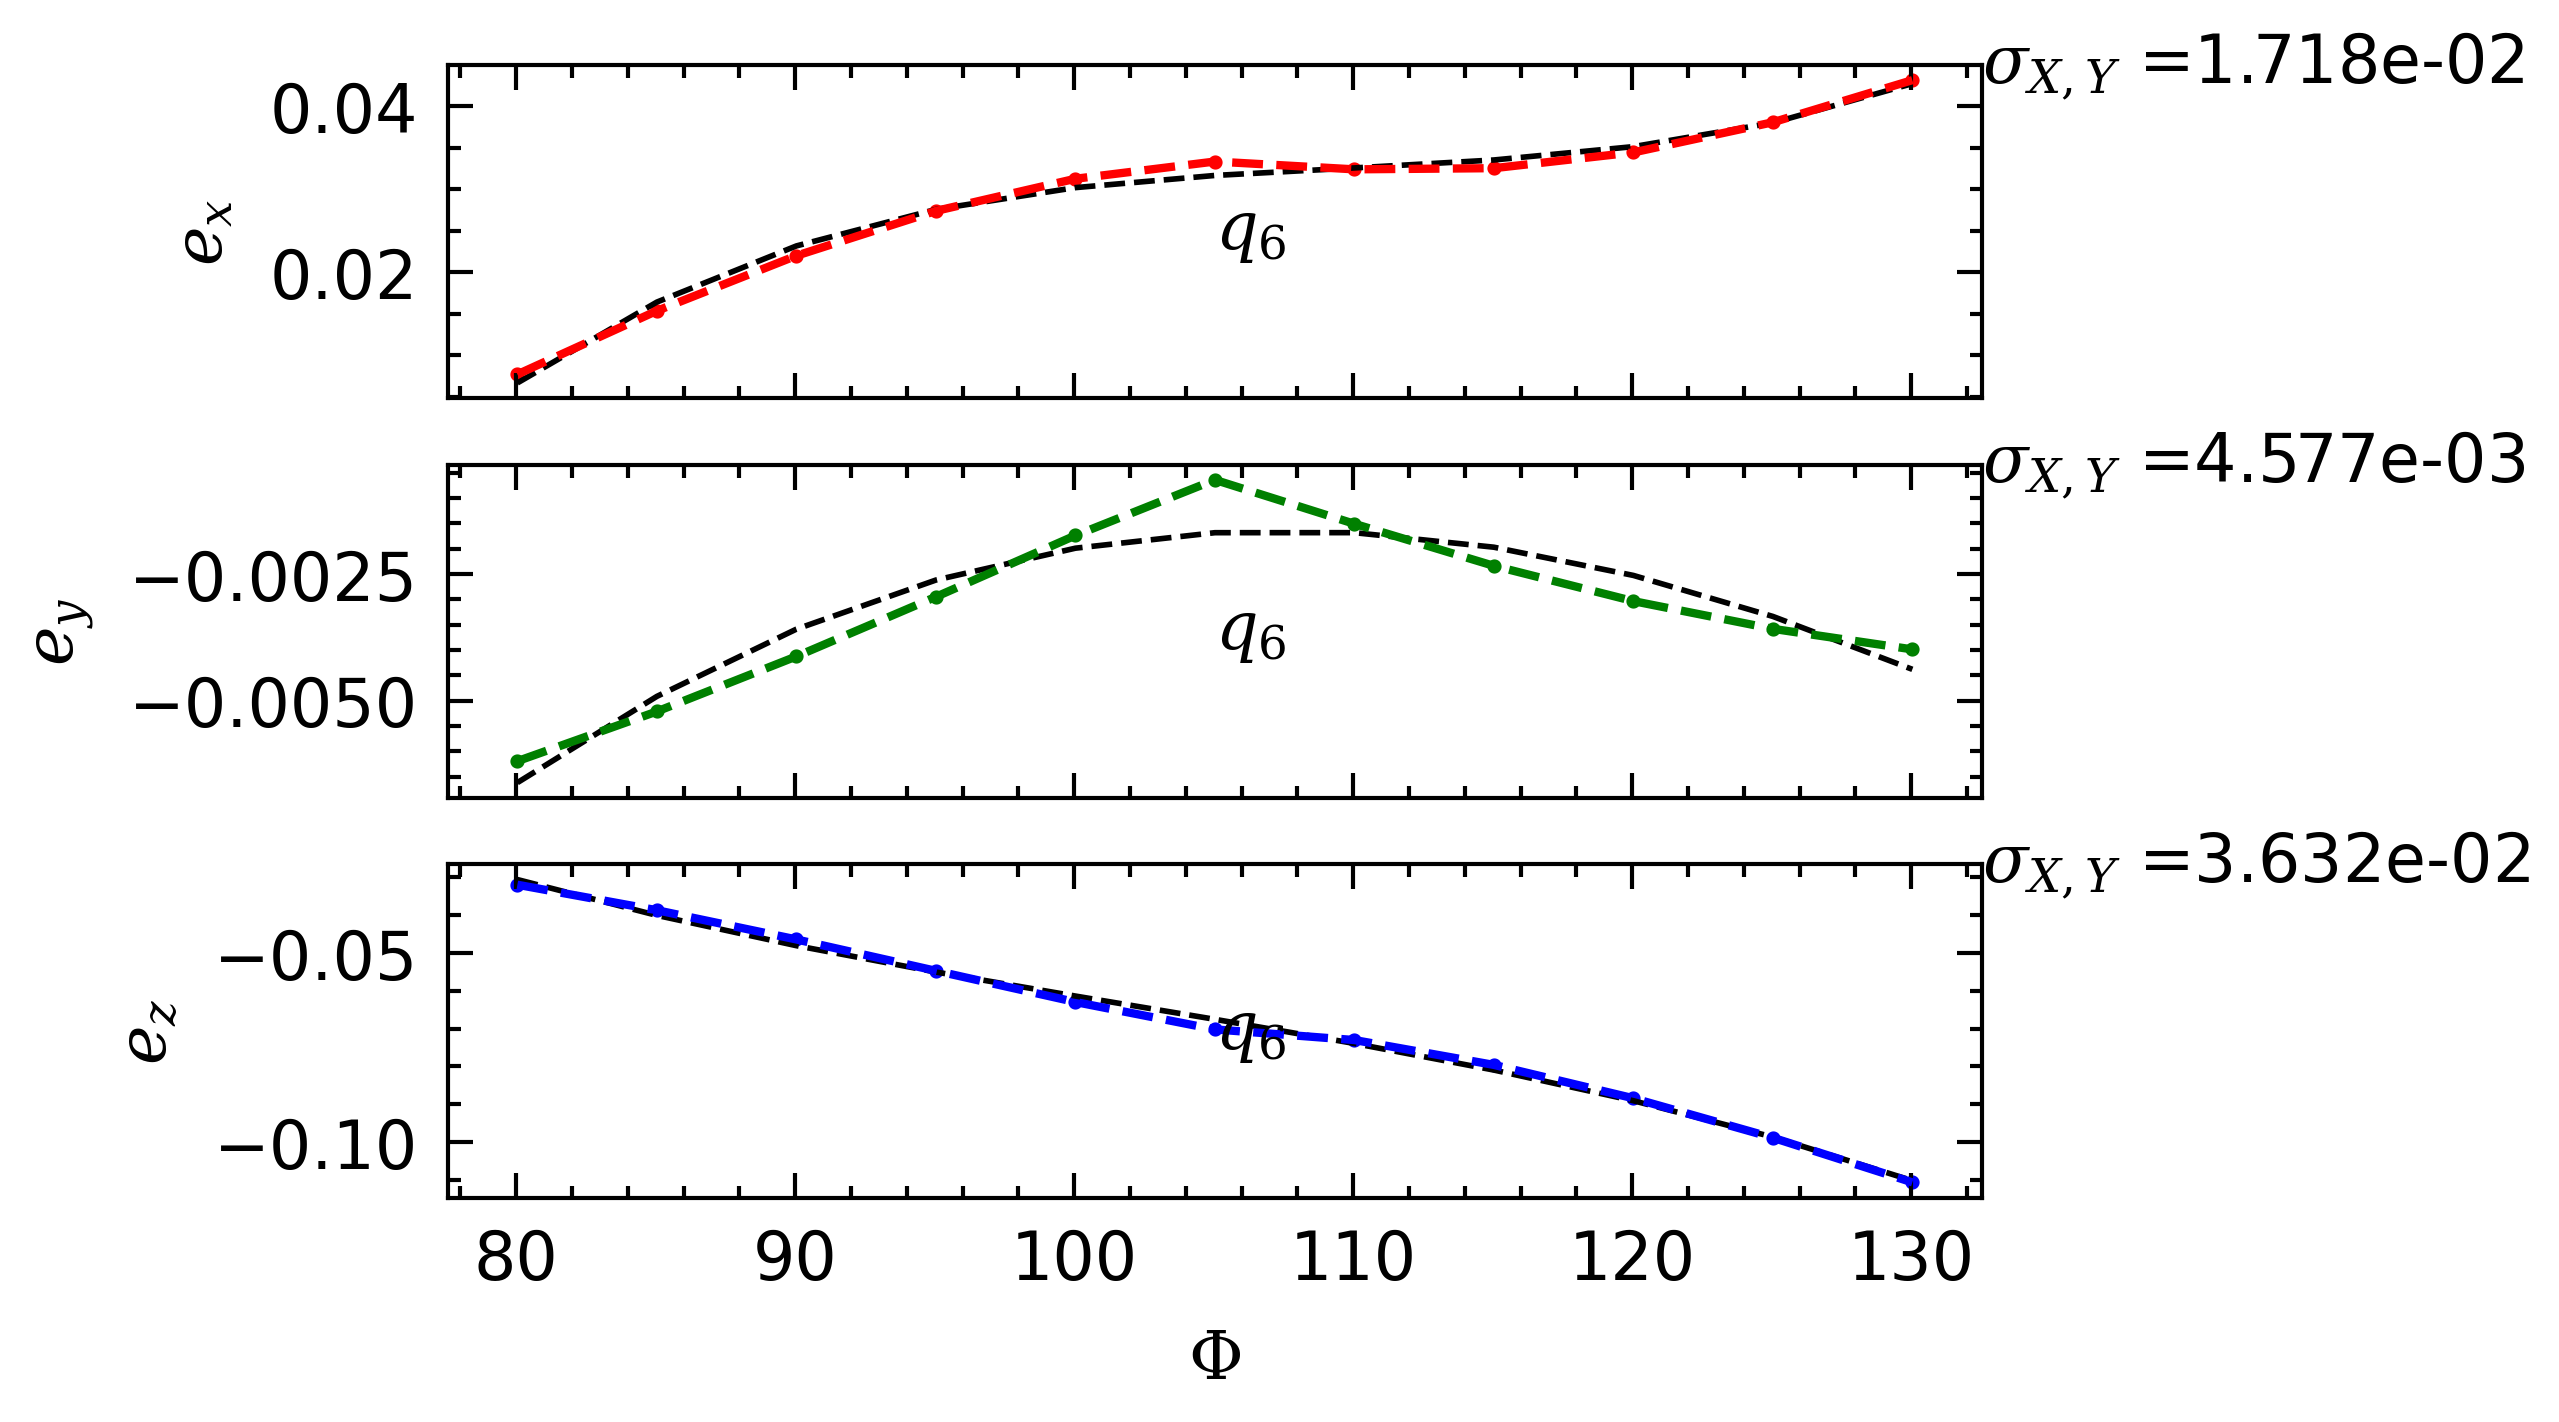

In [28]:
df_w_angle_100 = get_FDCM_data("/home/boittier/FDCM/angle_100", "water_angle100.csv")
df_w_angle_100["dihedral"] = [a3_values[int(x)] for x in list(df_w_angle_100["dihedral"])]
df_w_angle_100 = df_w_angle_100.sort_values("dihedral")
df_w_angle_100.plot("dihedral", "total")

for i in range(6):
    plot_charge(i, df_w_angle_100, "hello")

#  1000 steps of GD

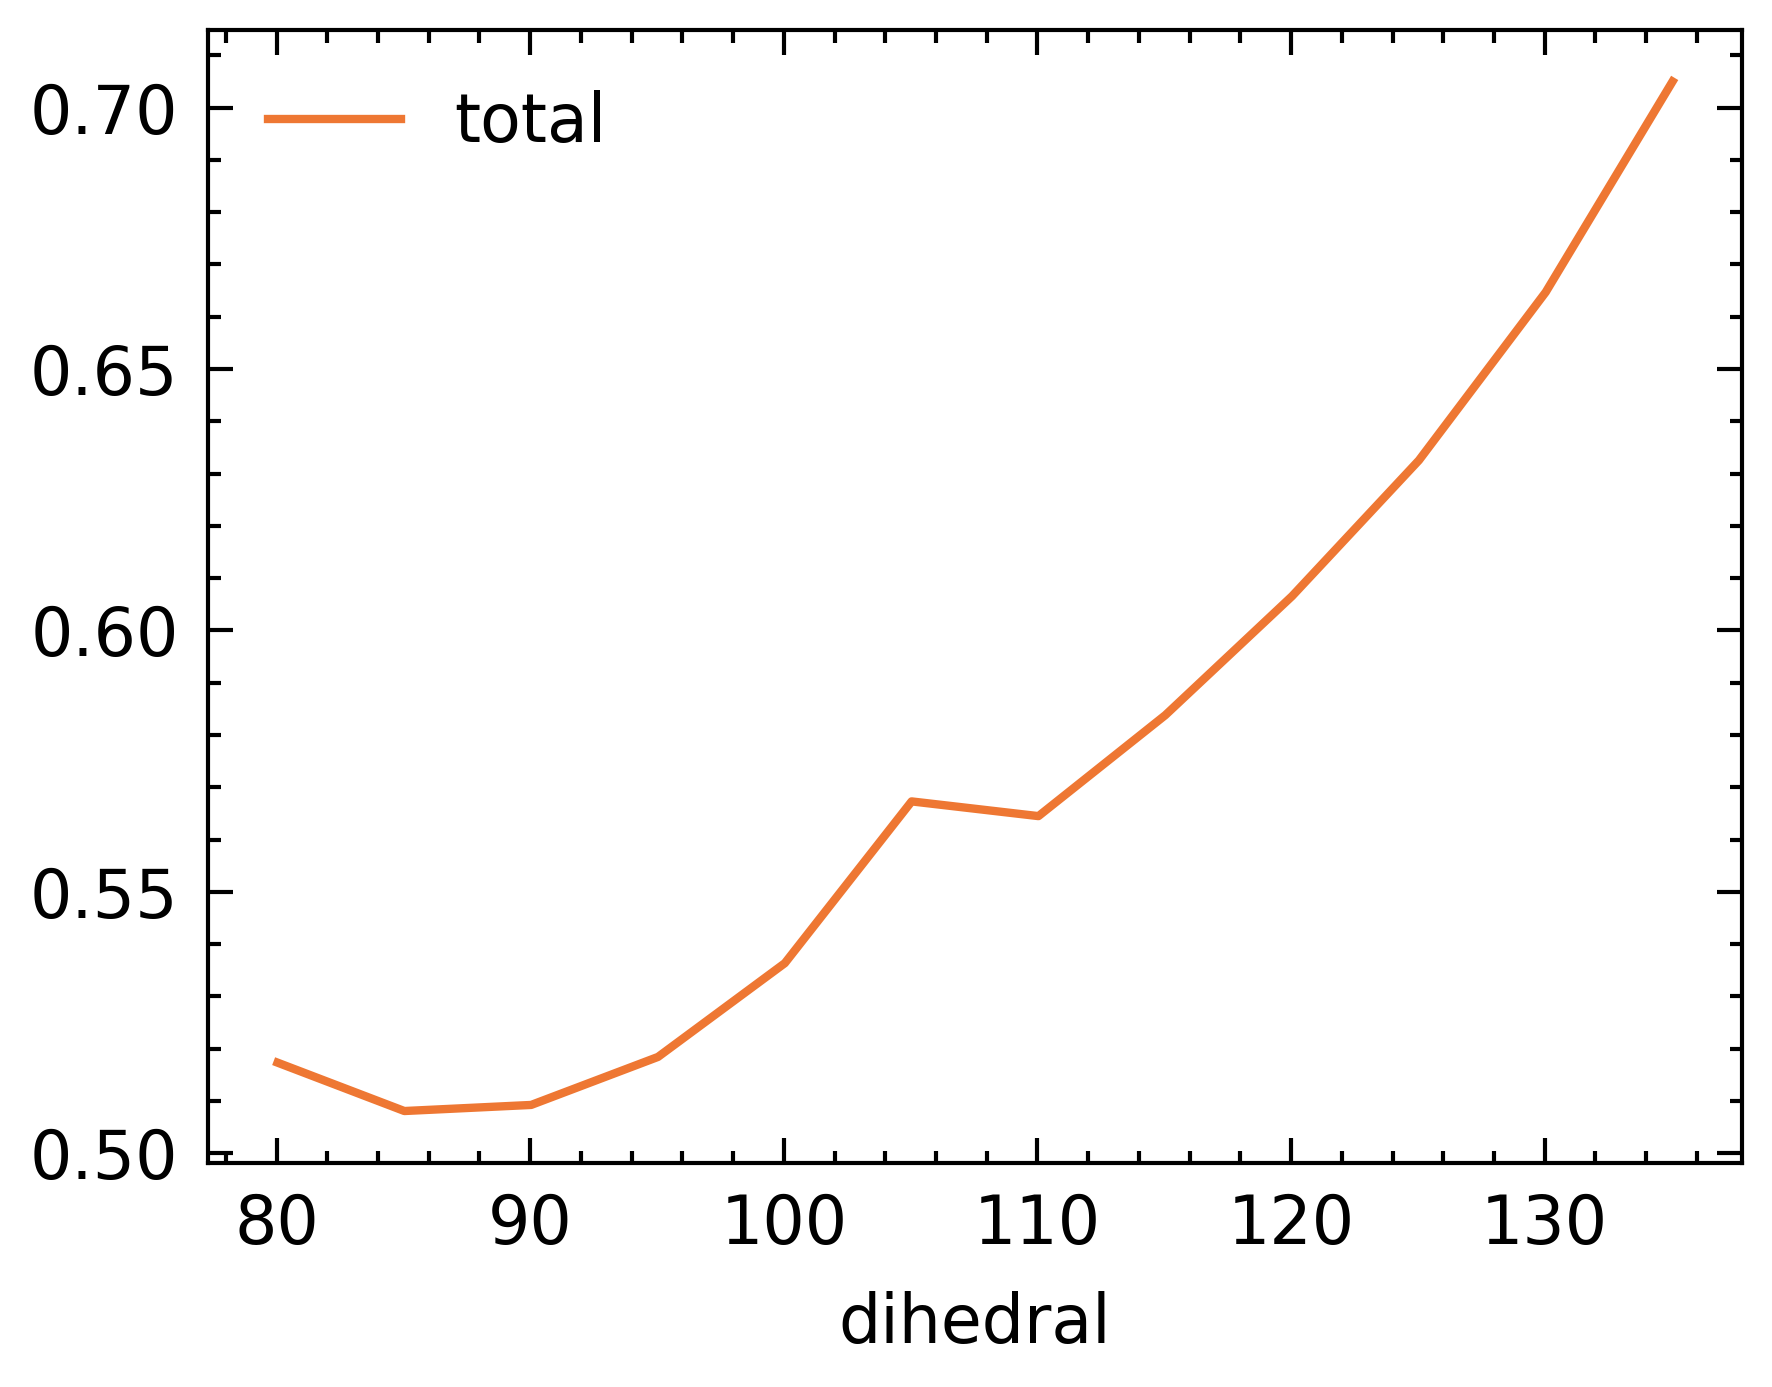

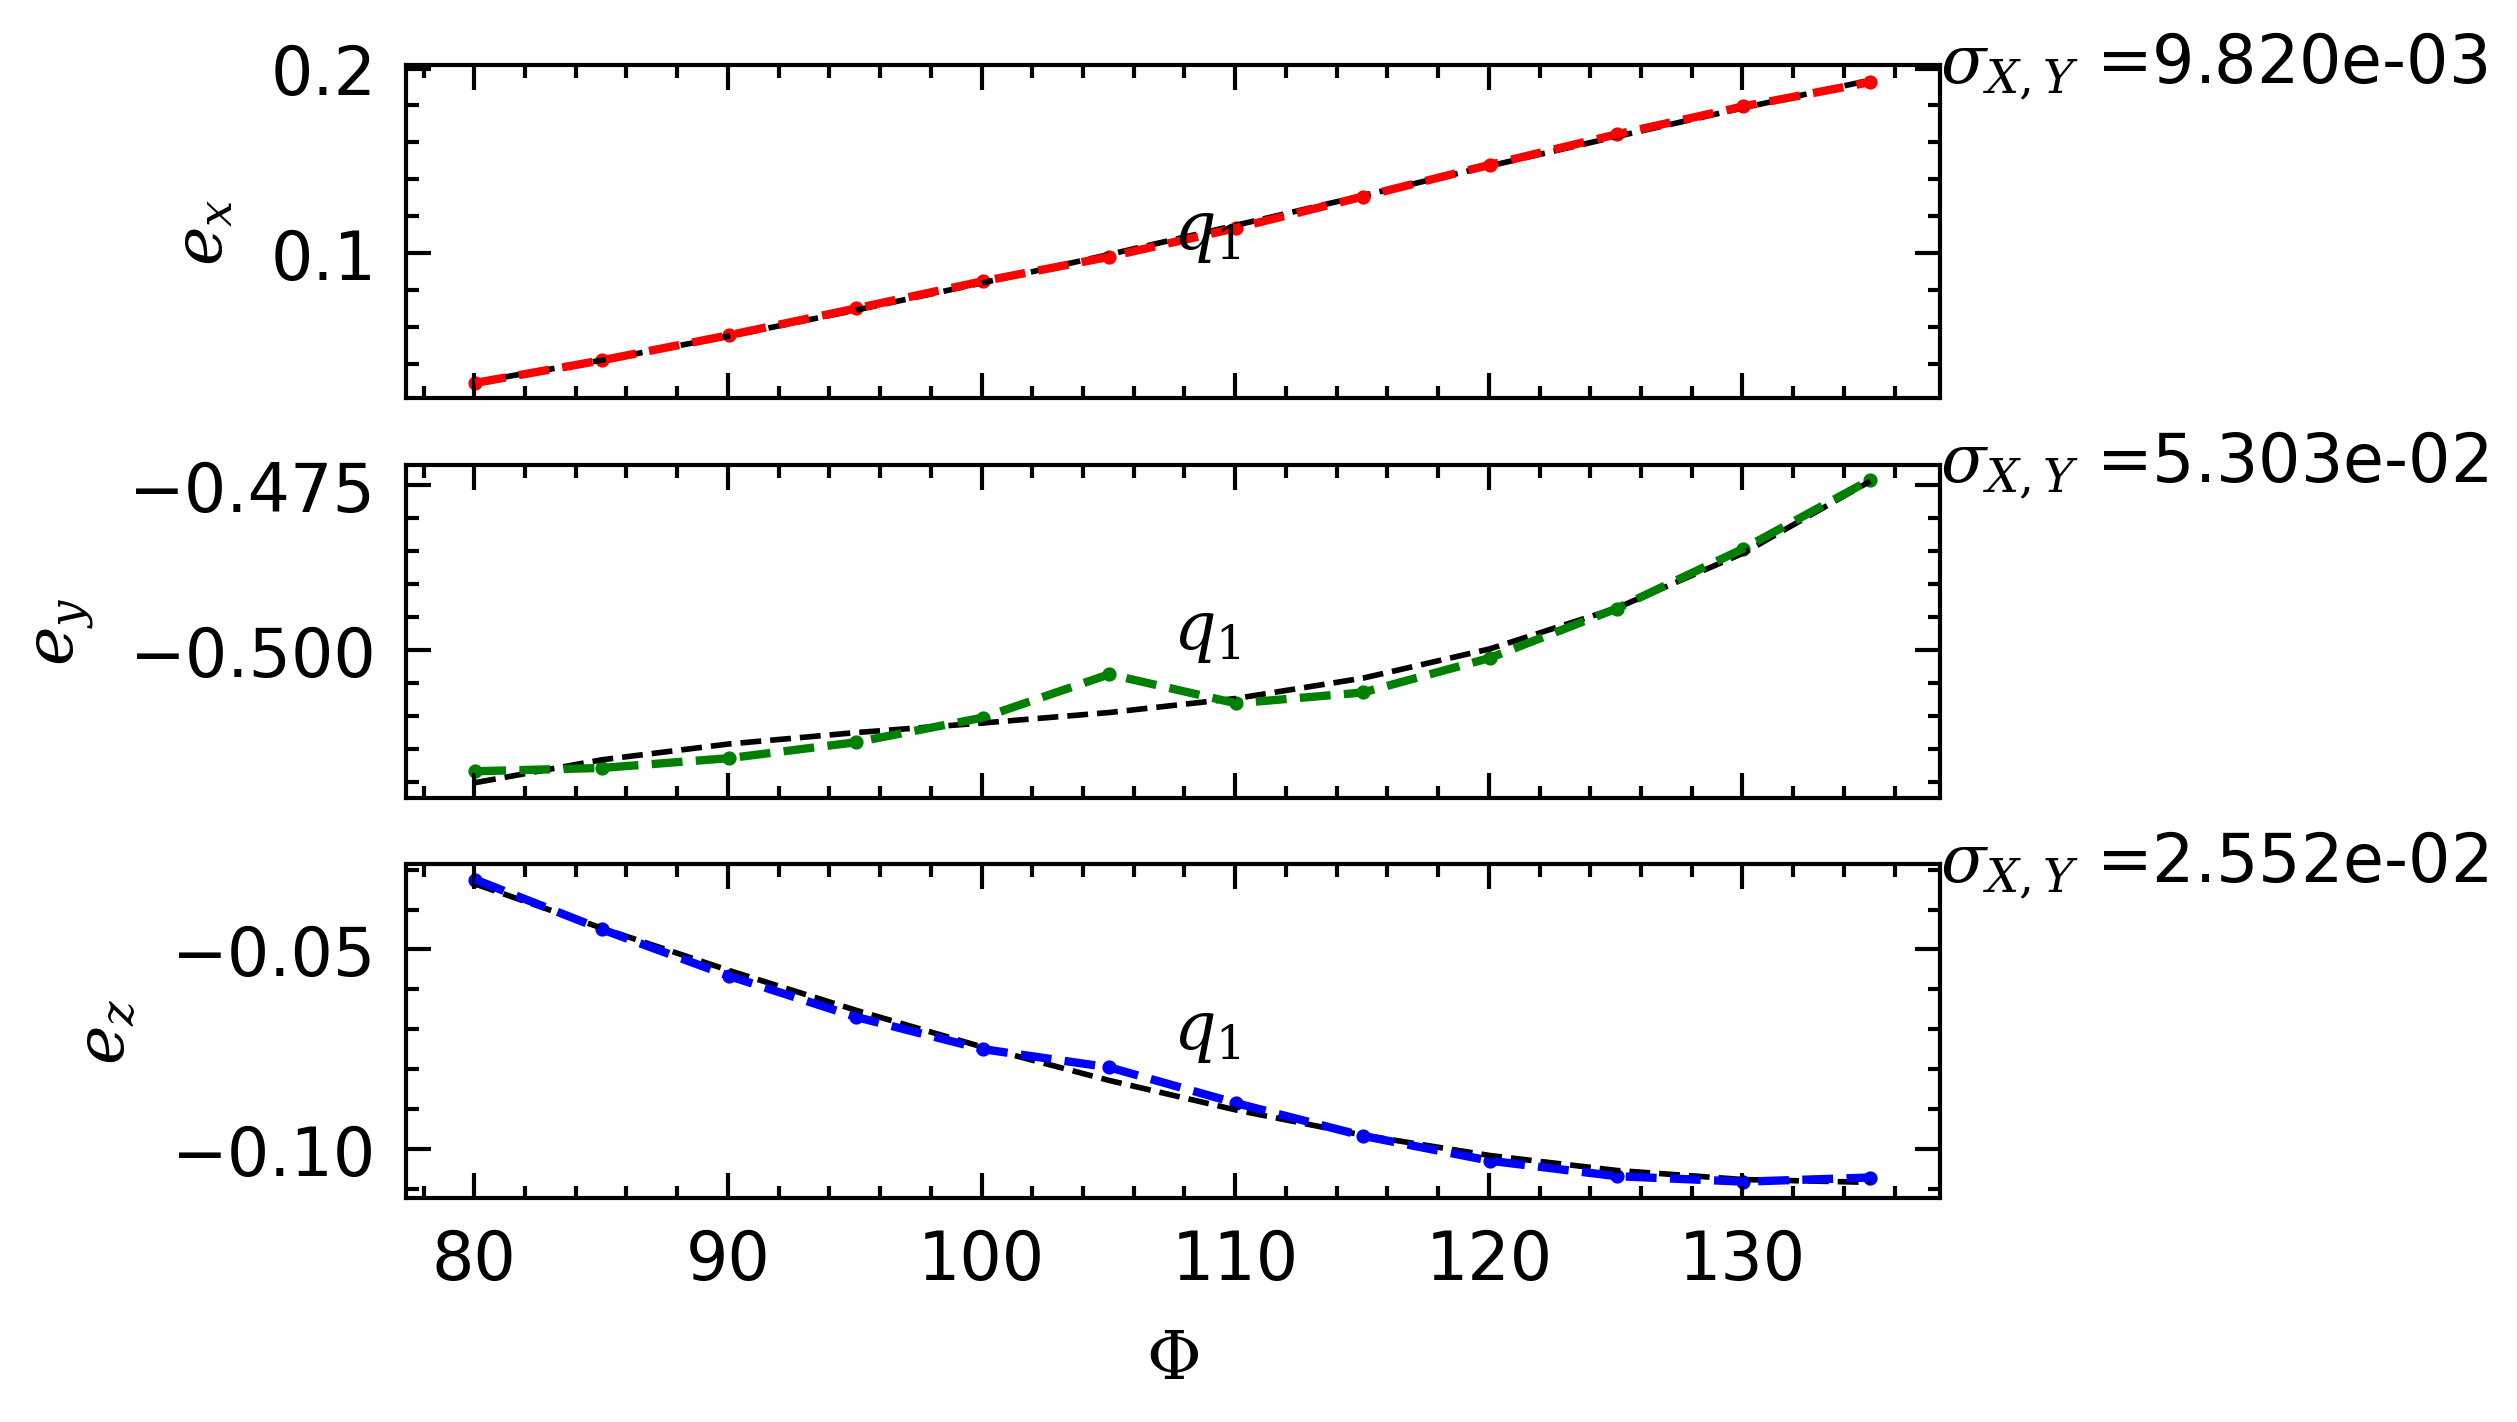

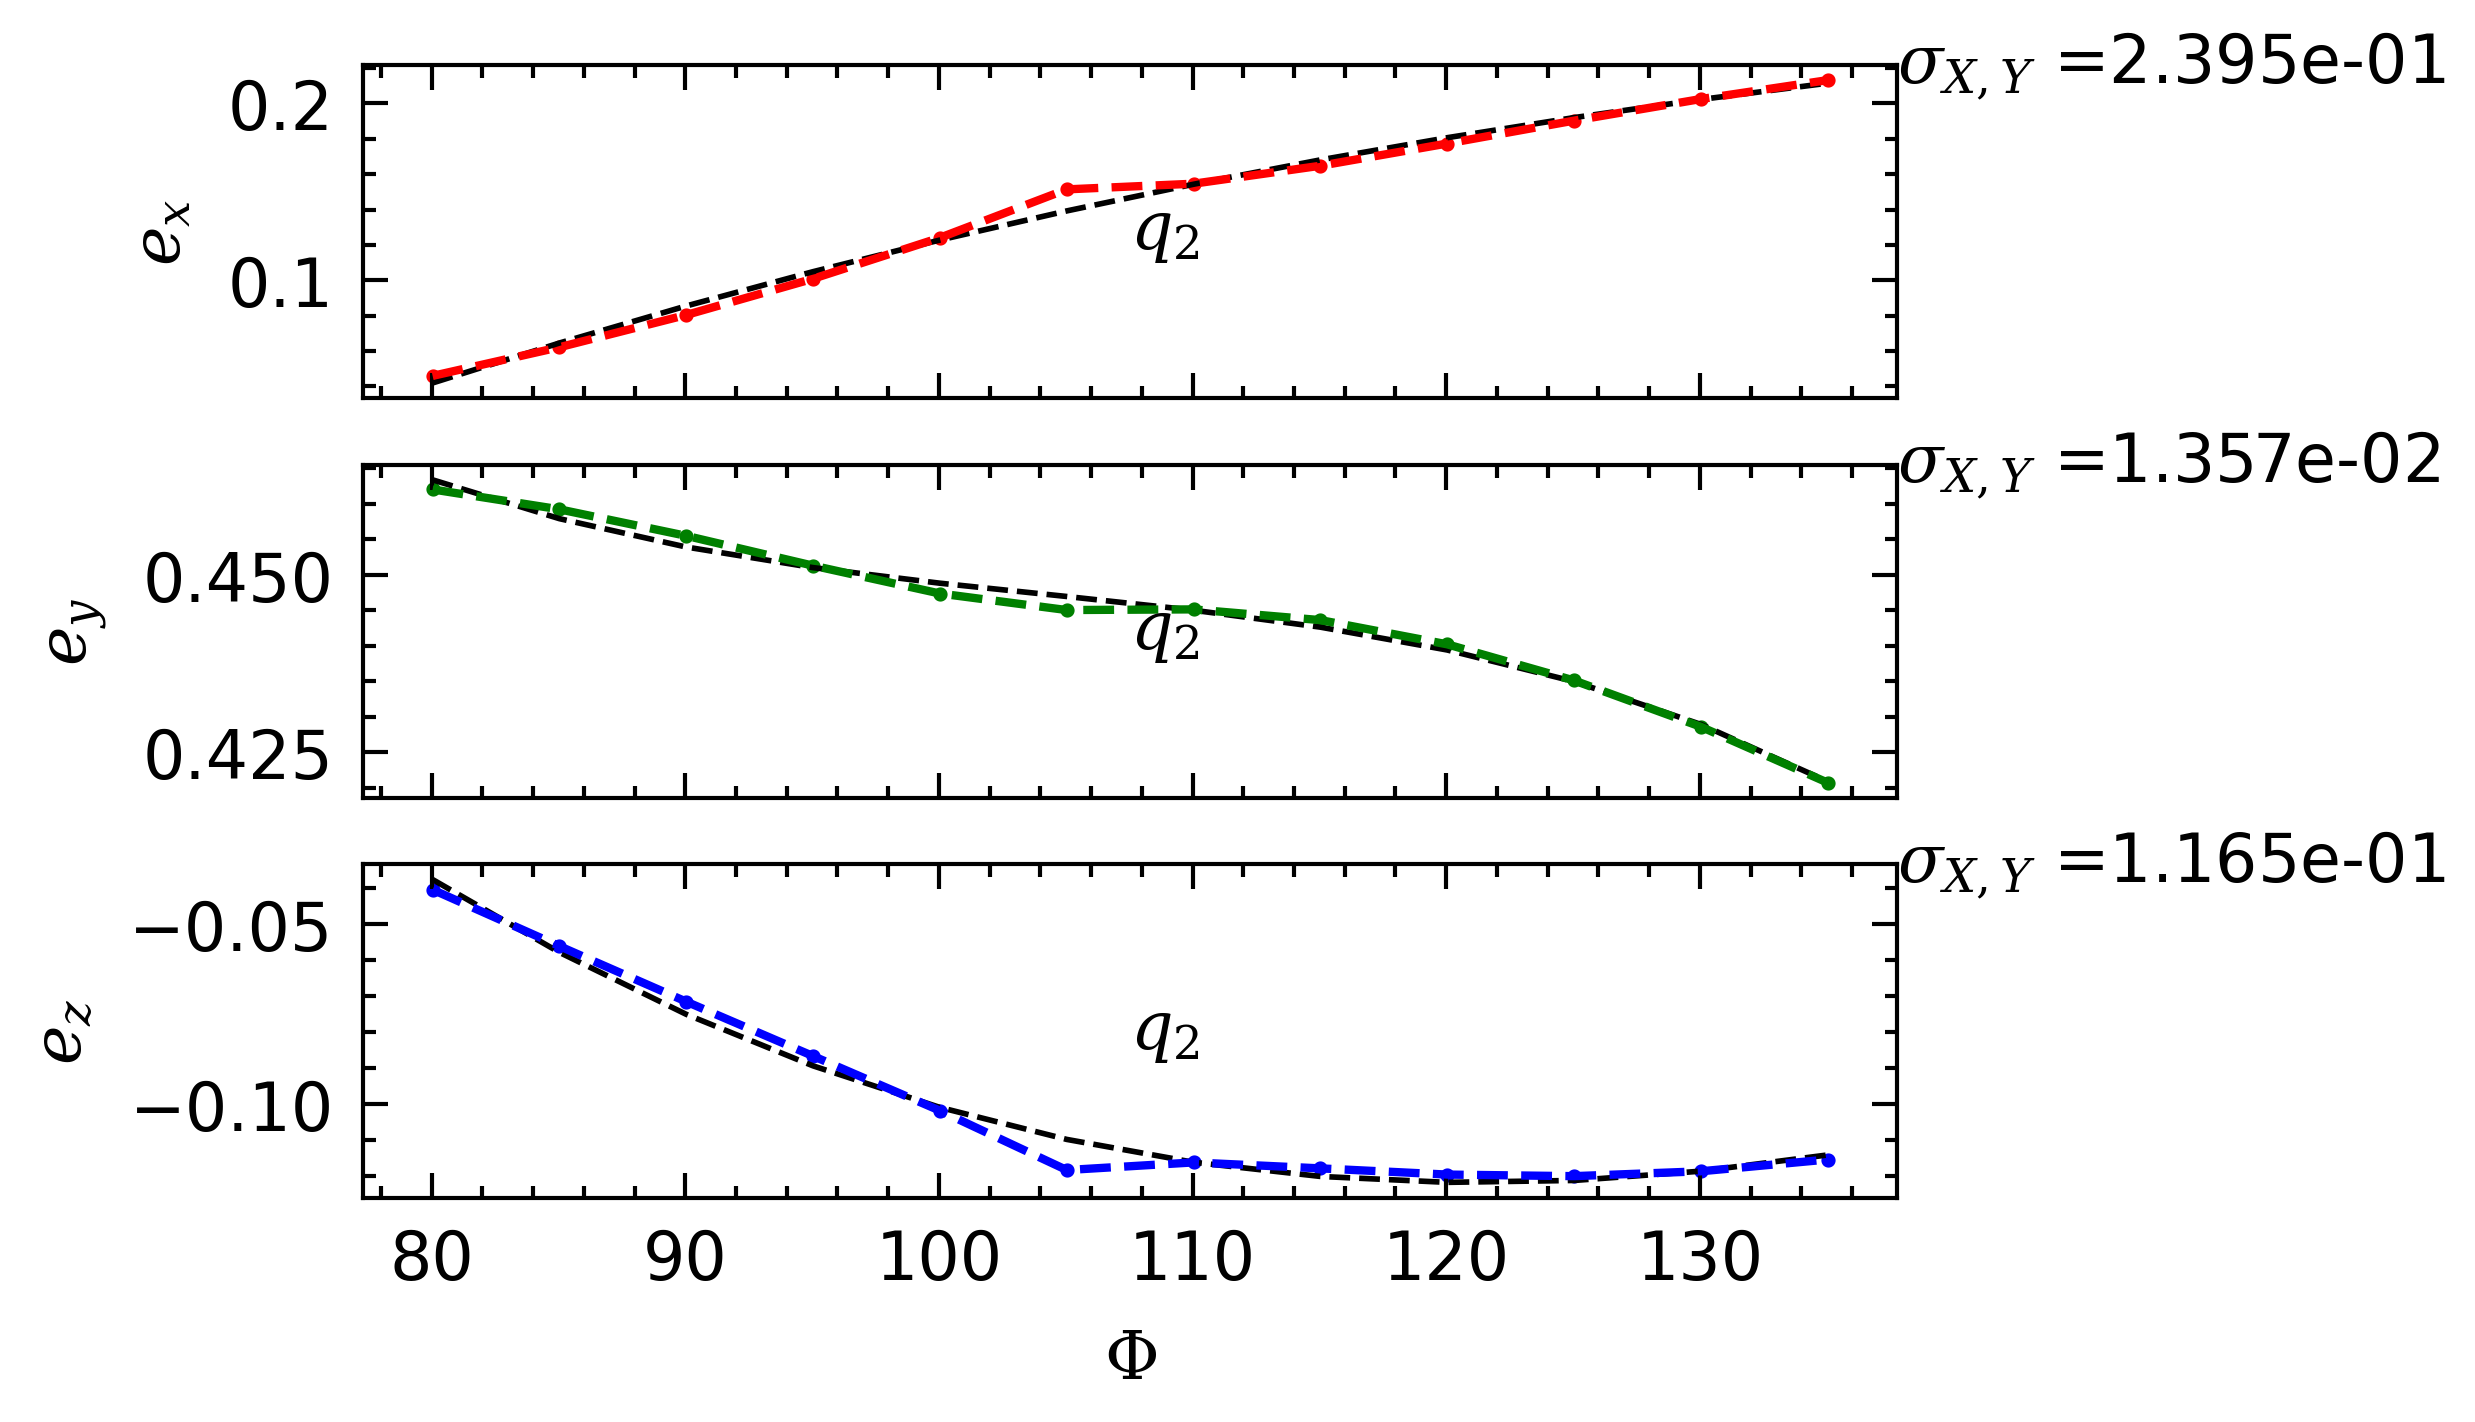

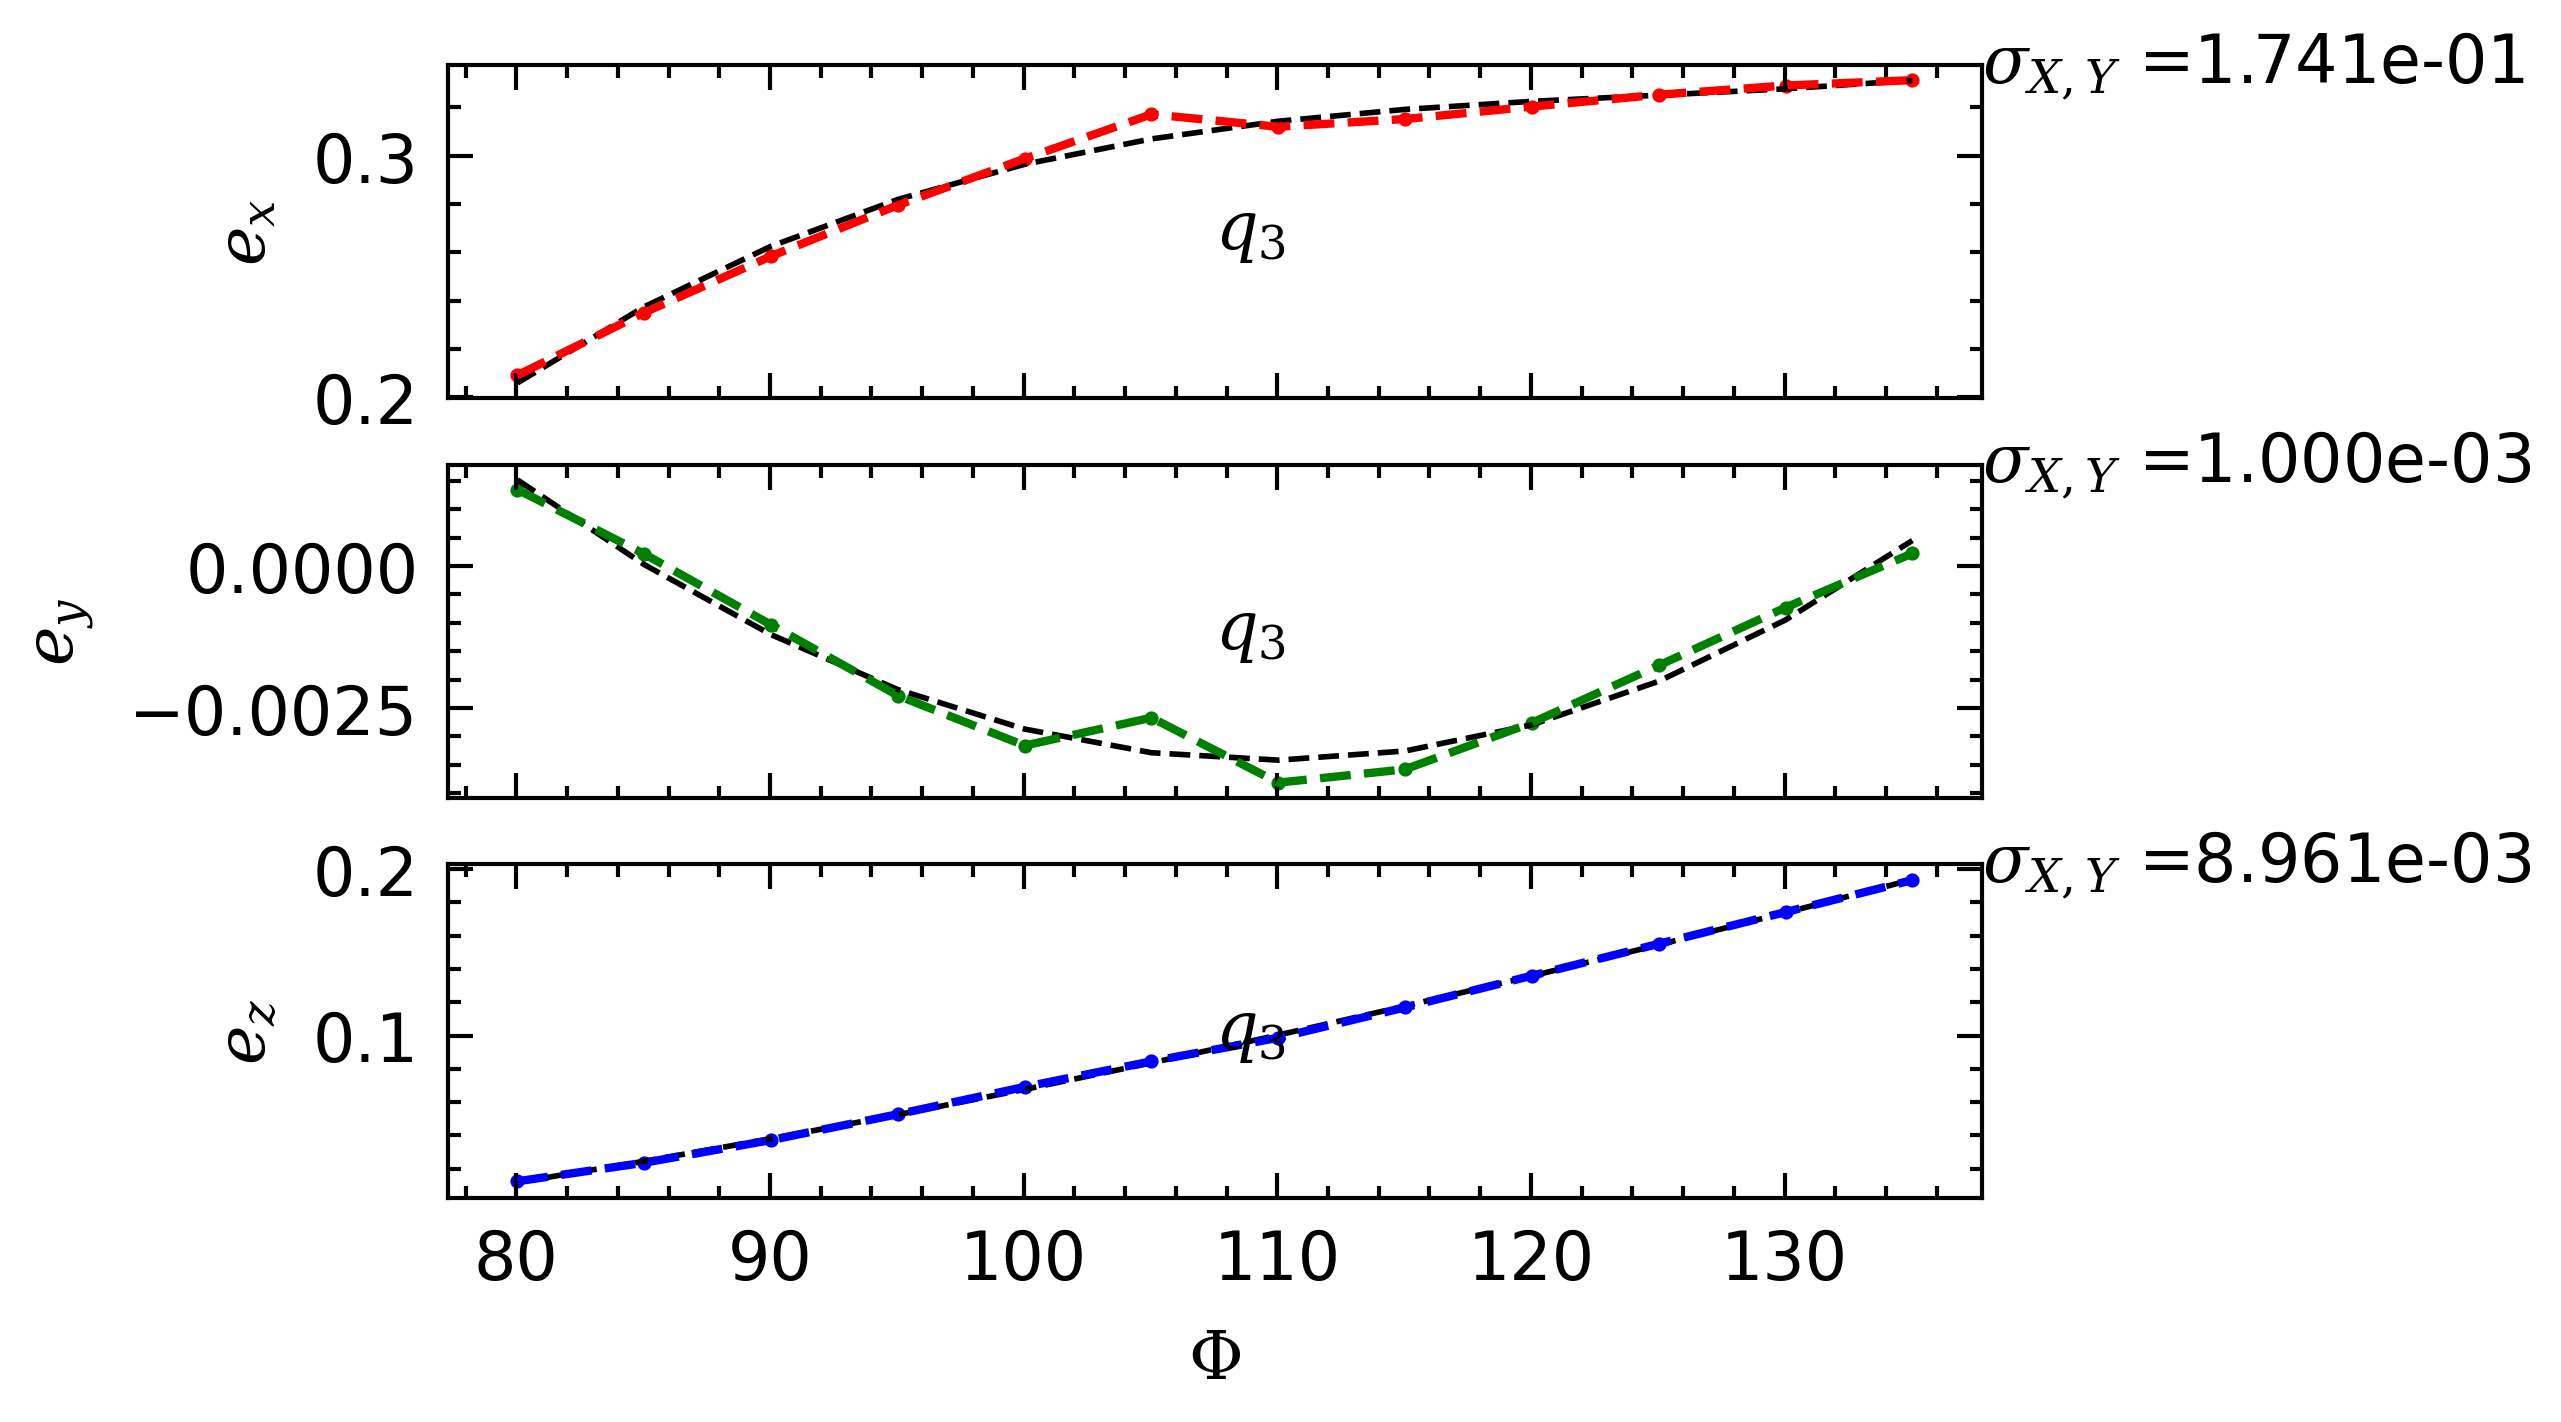

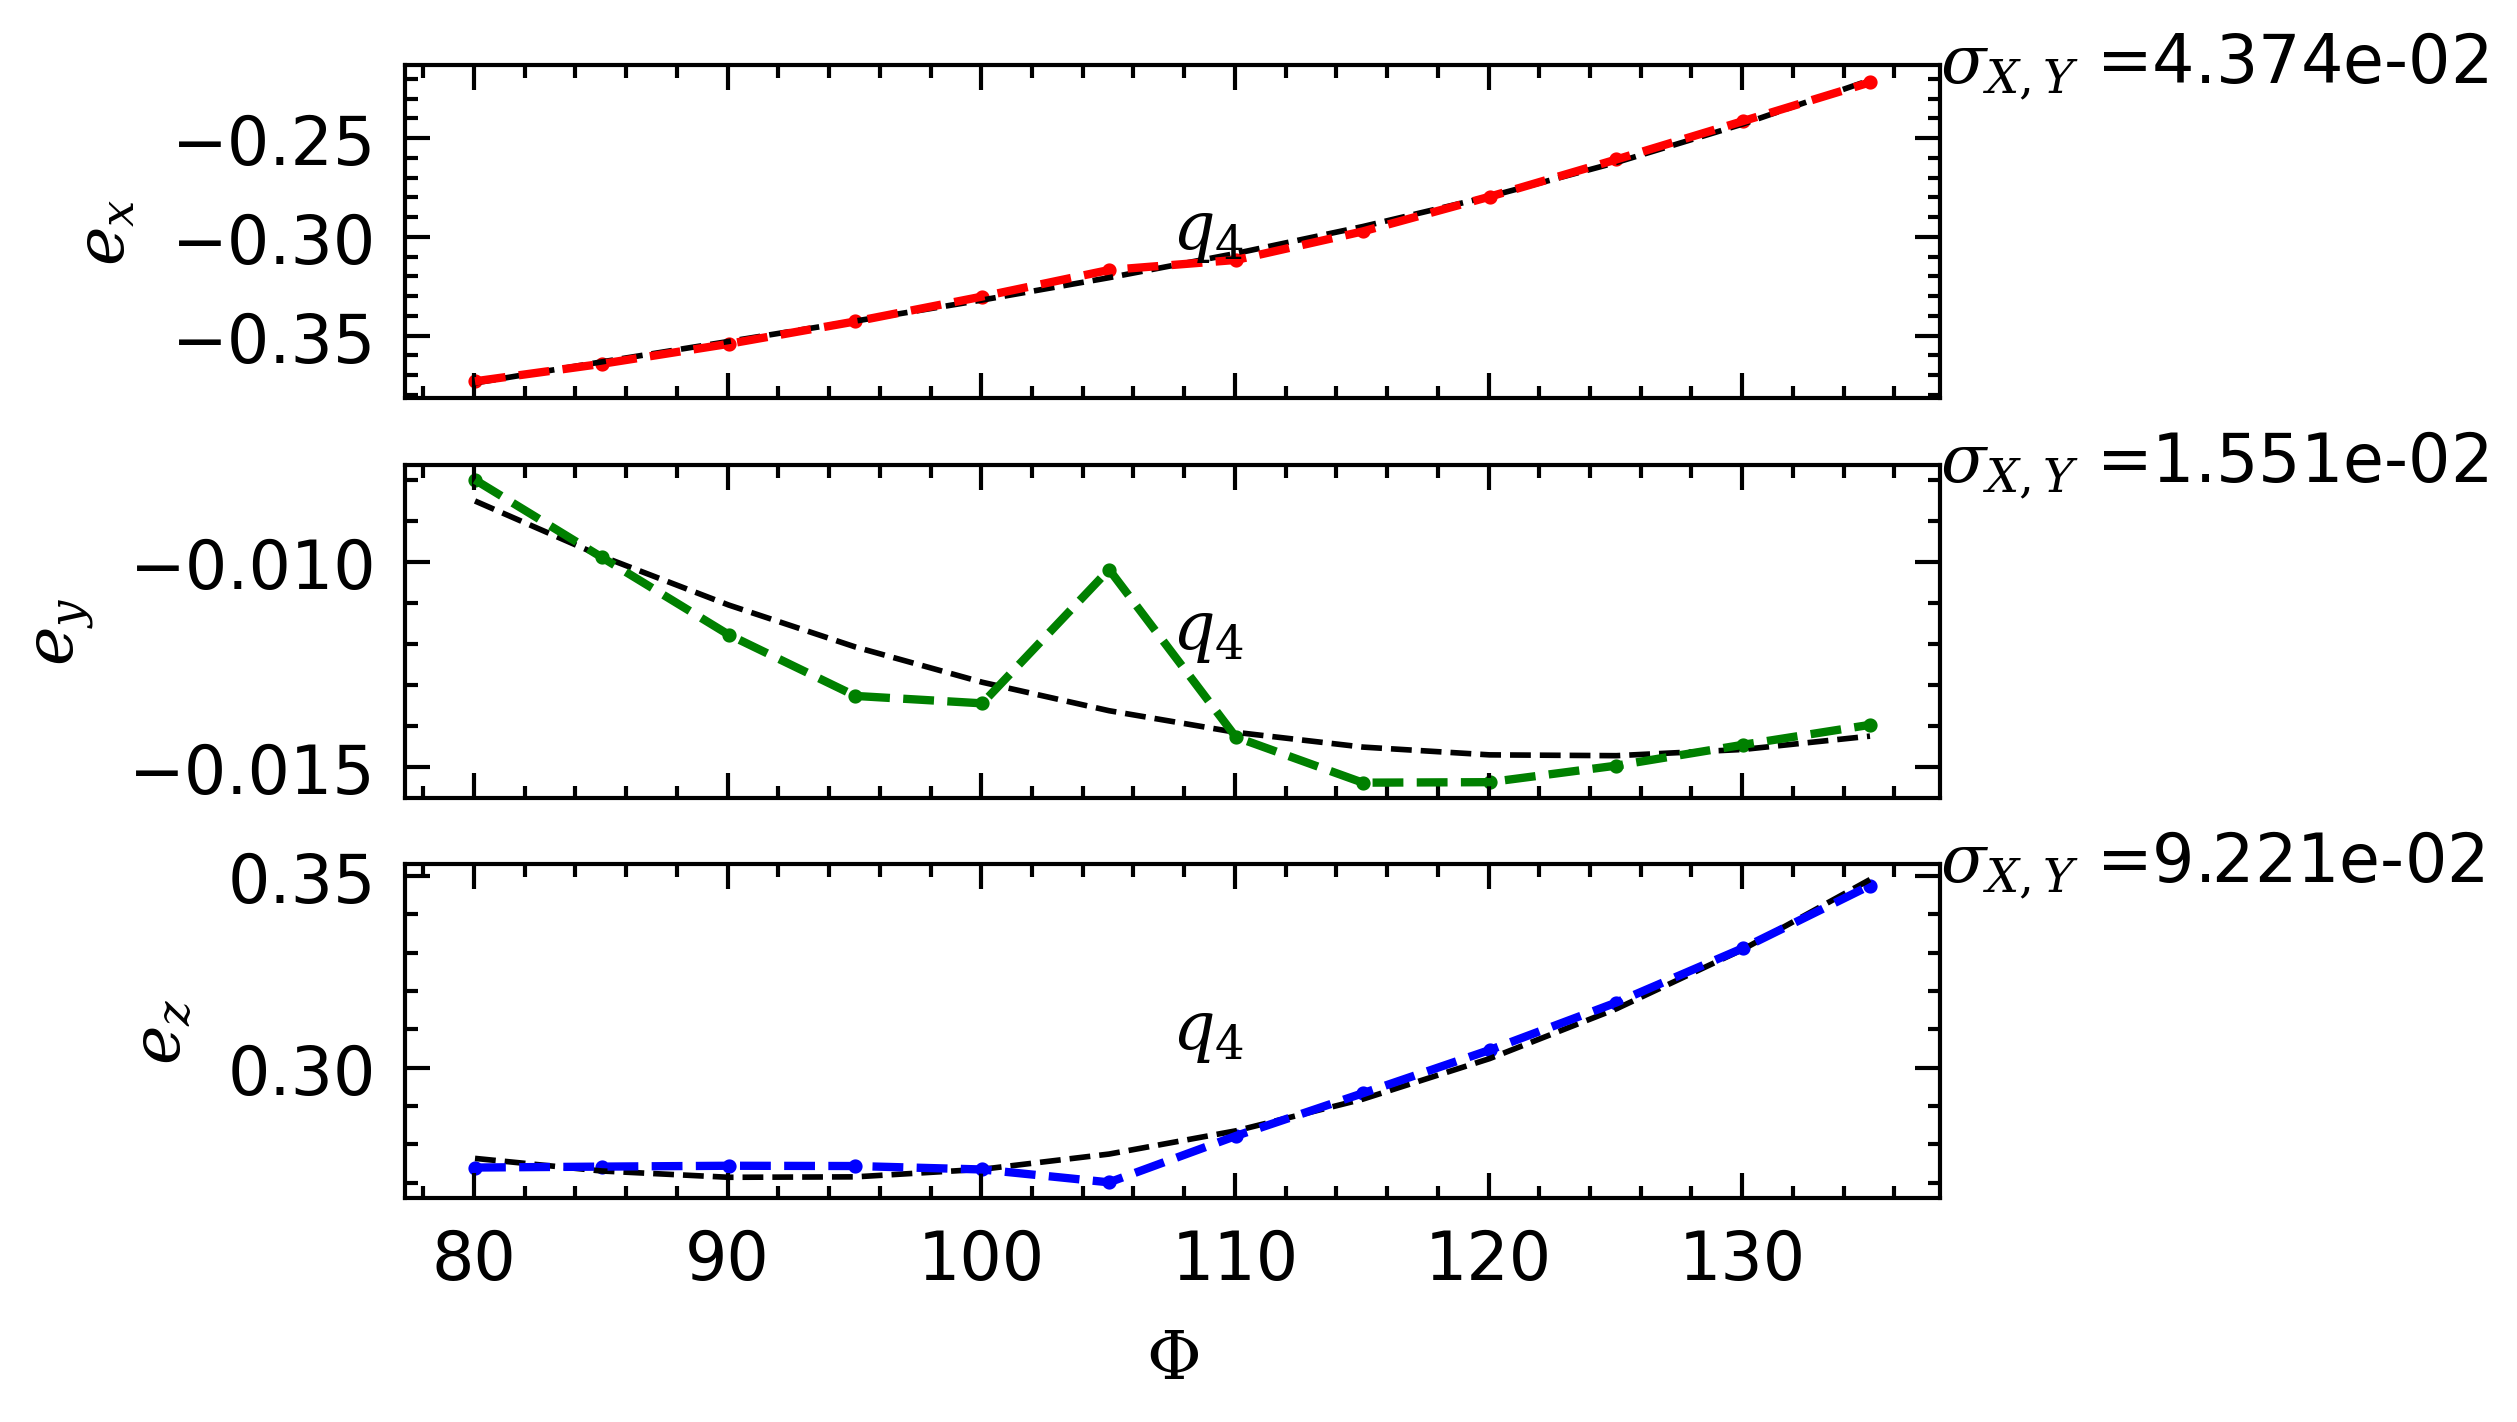

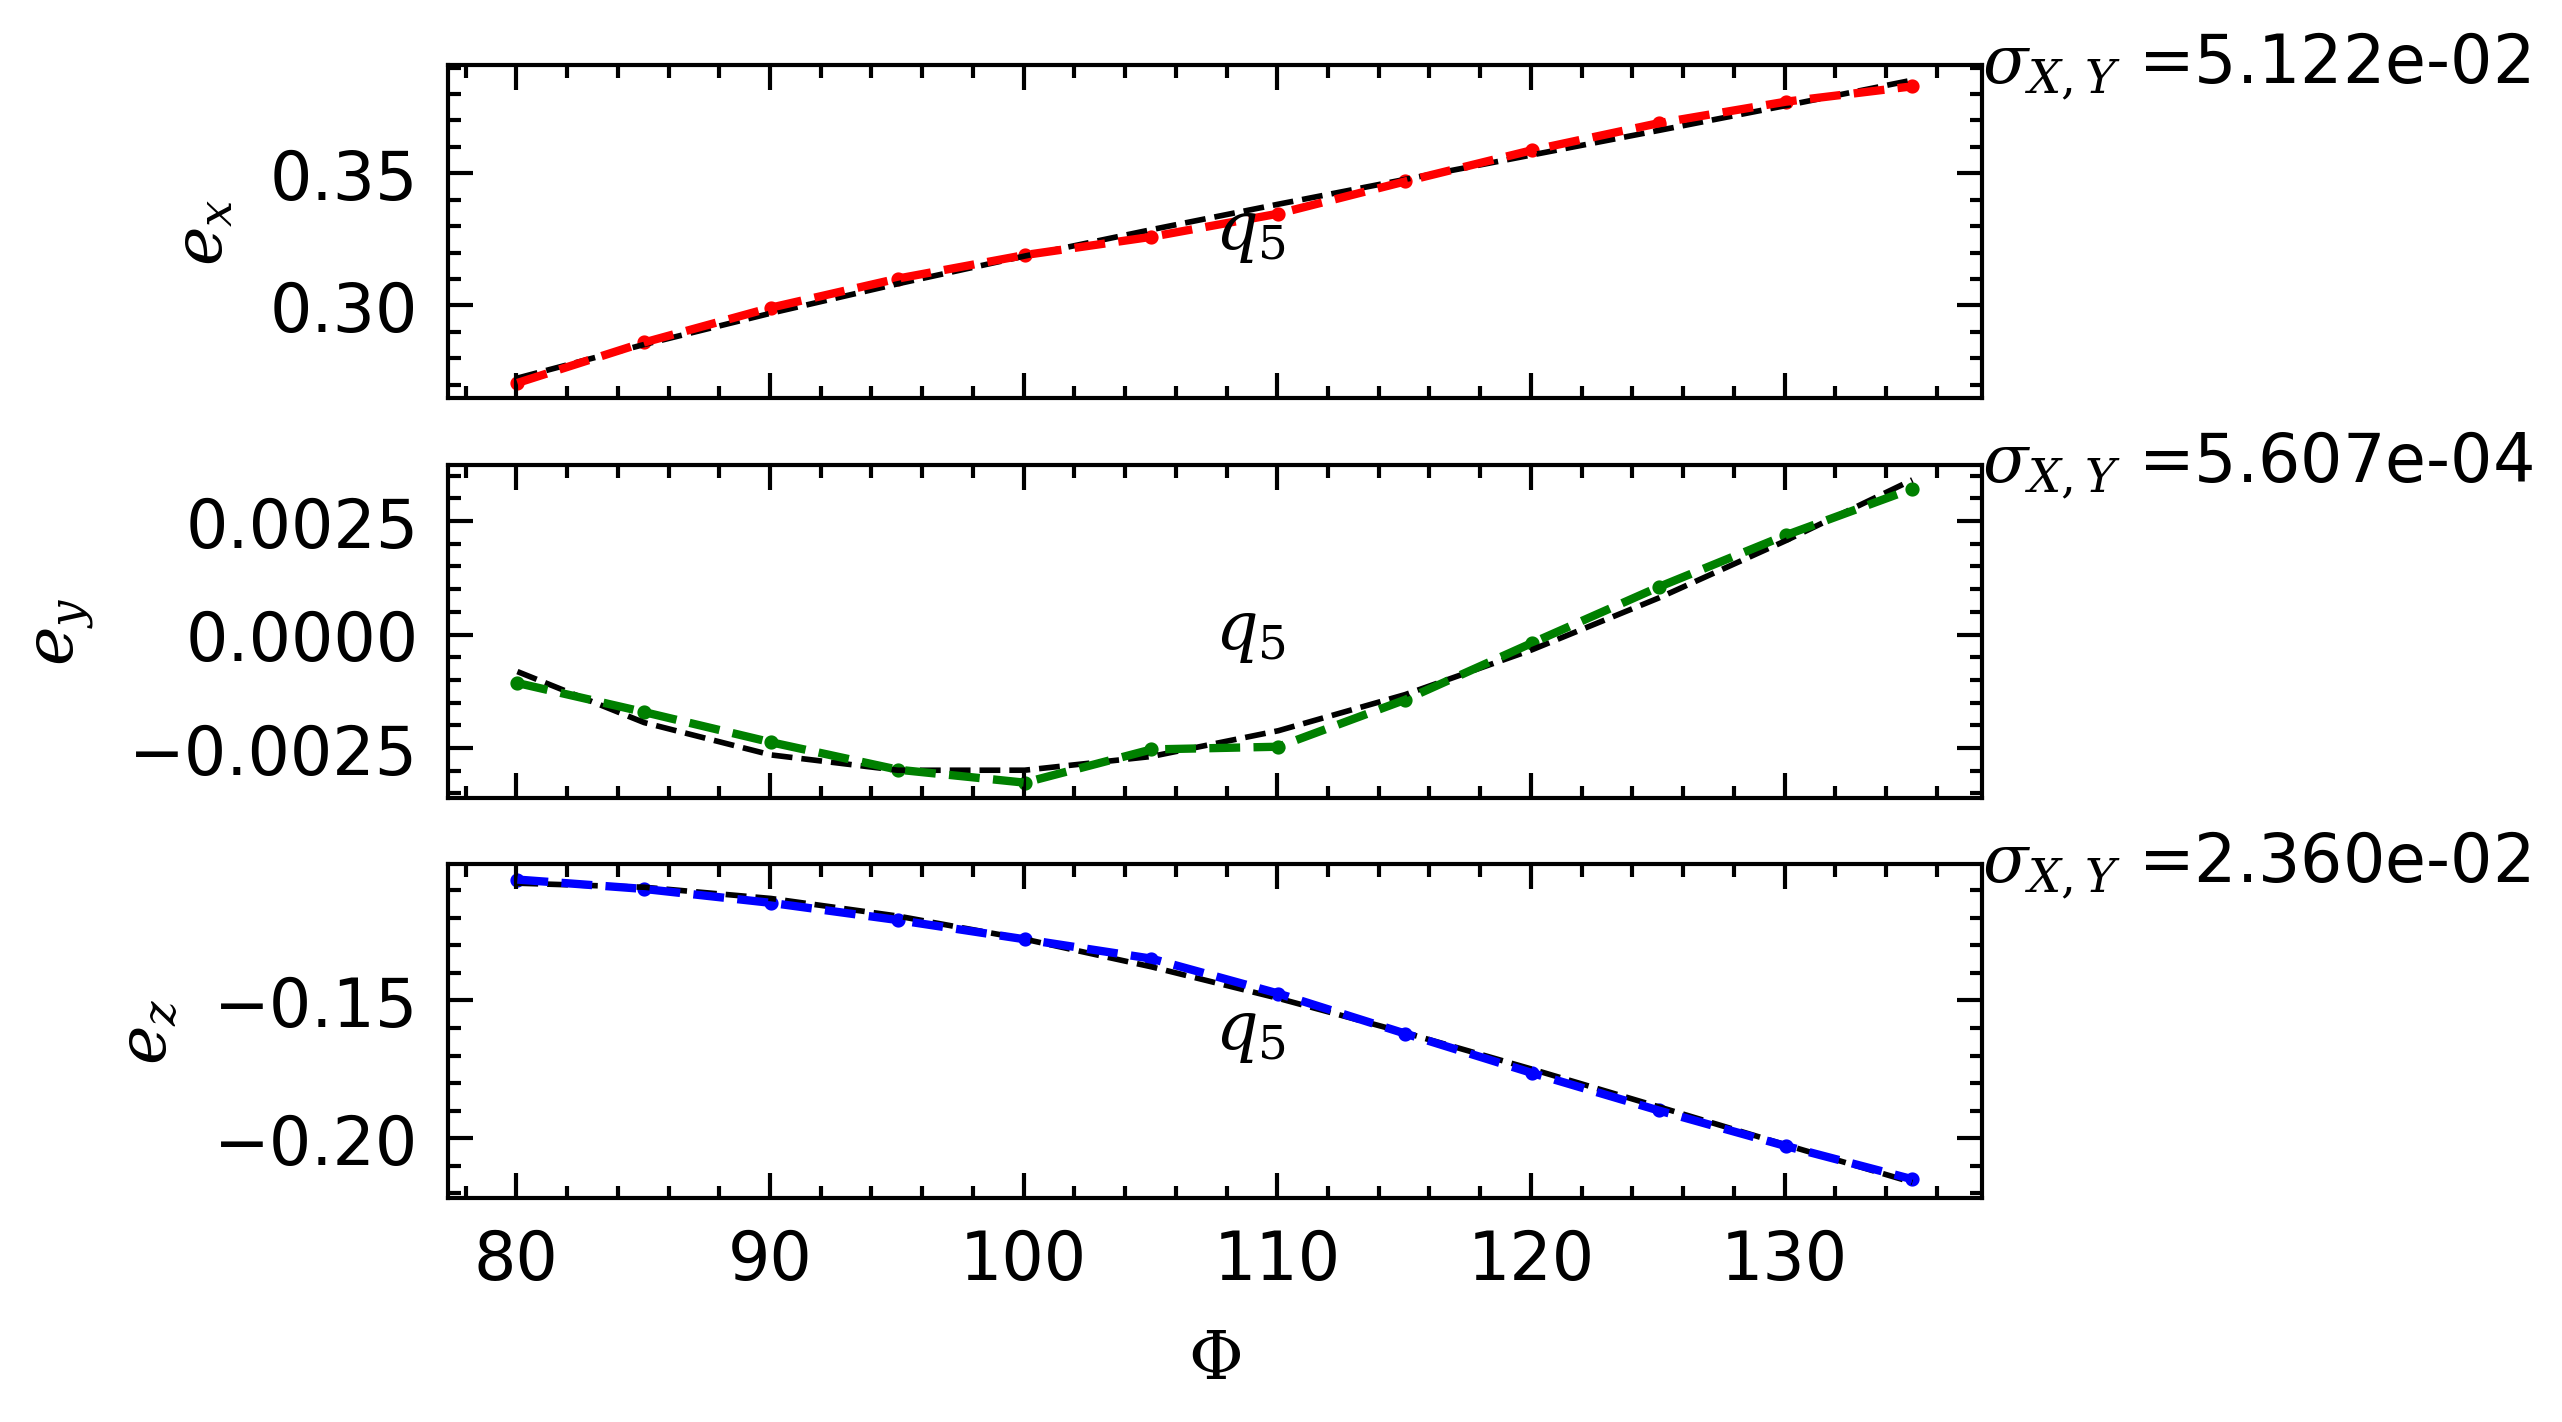

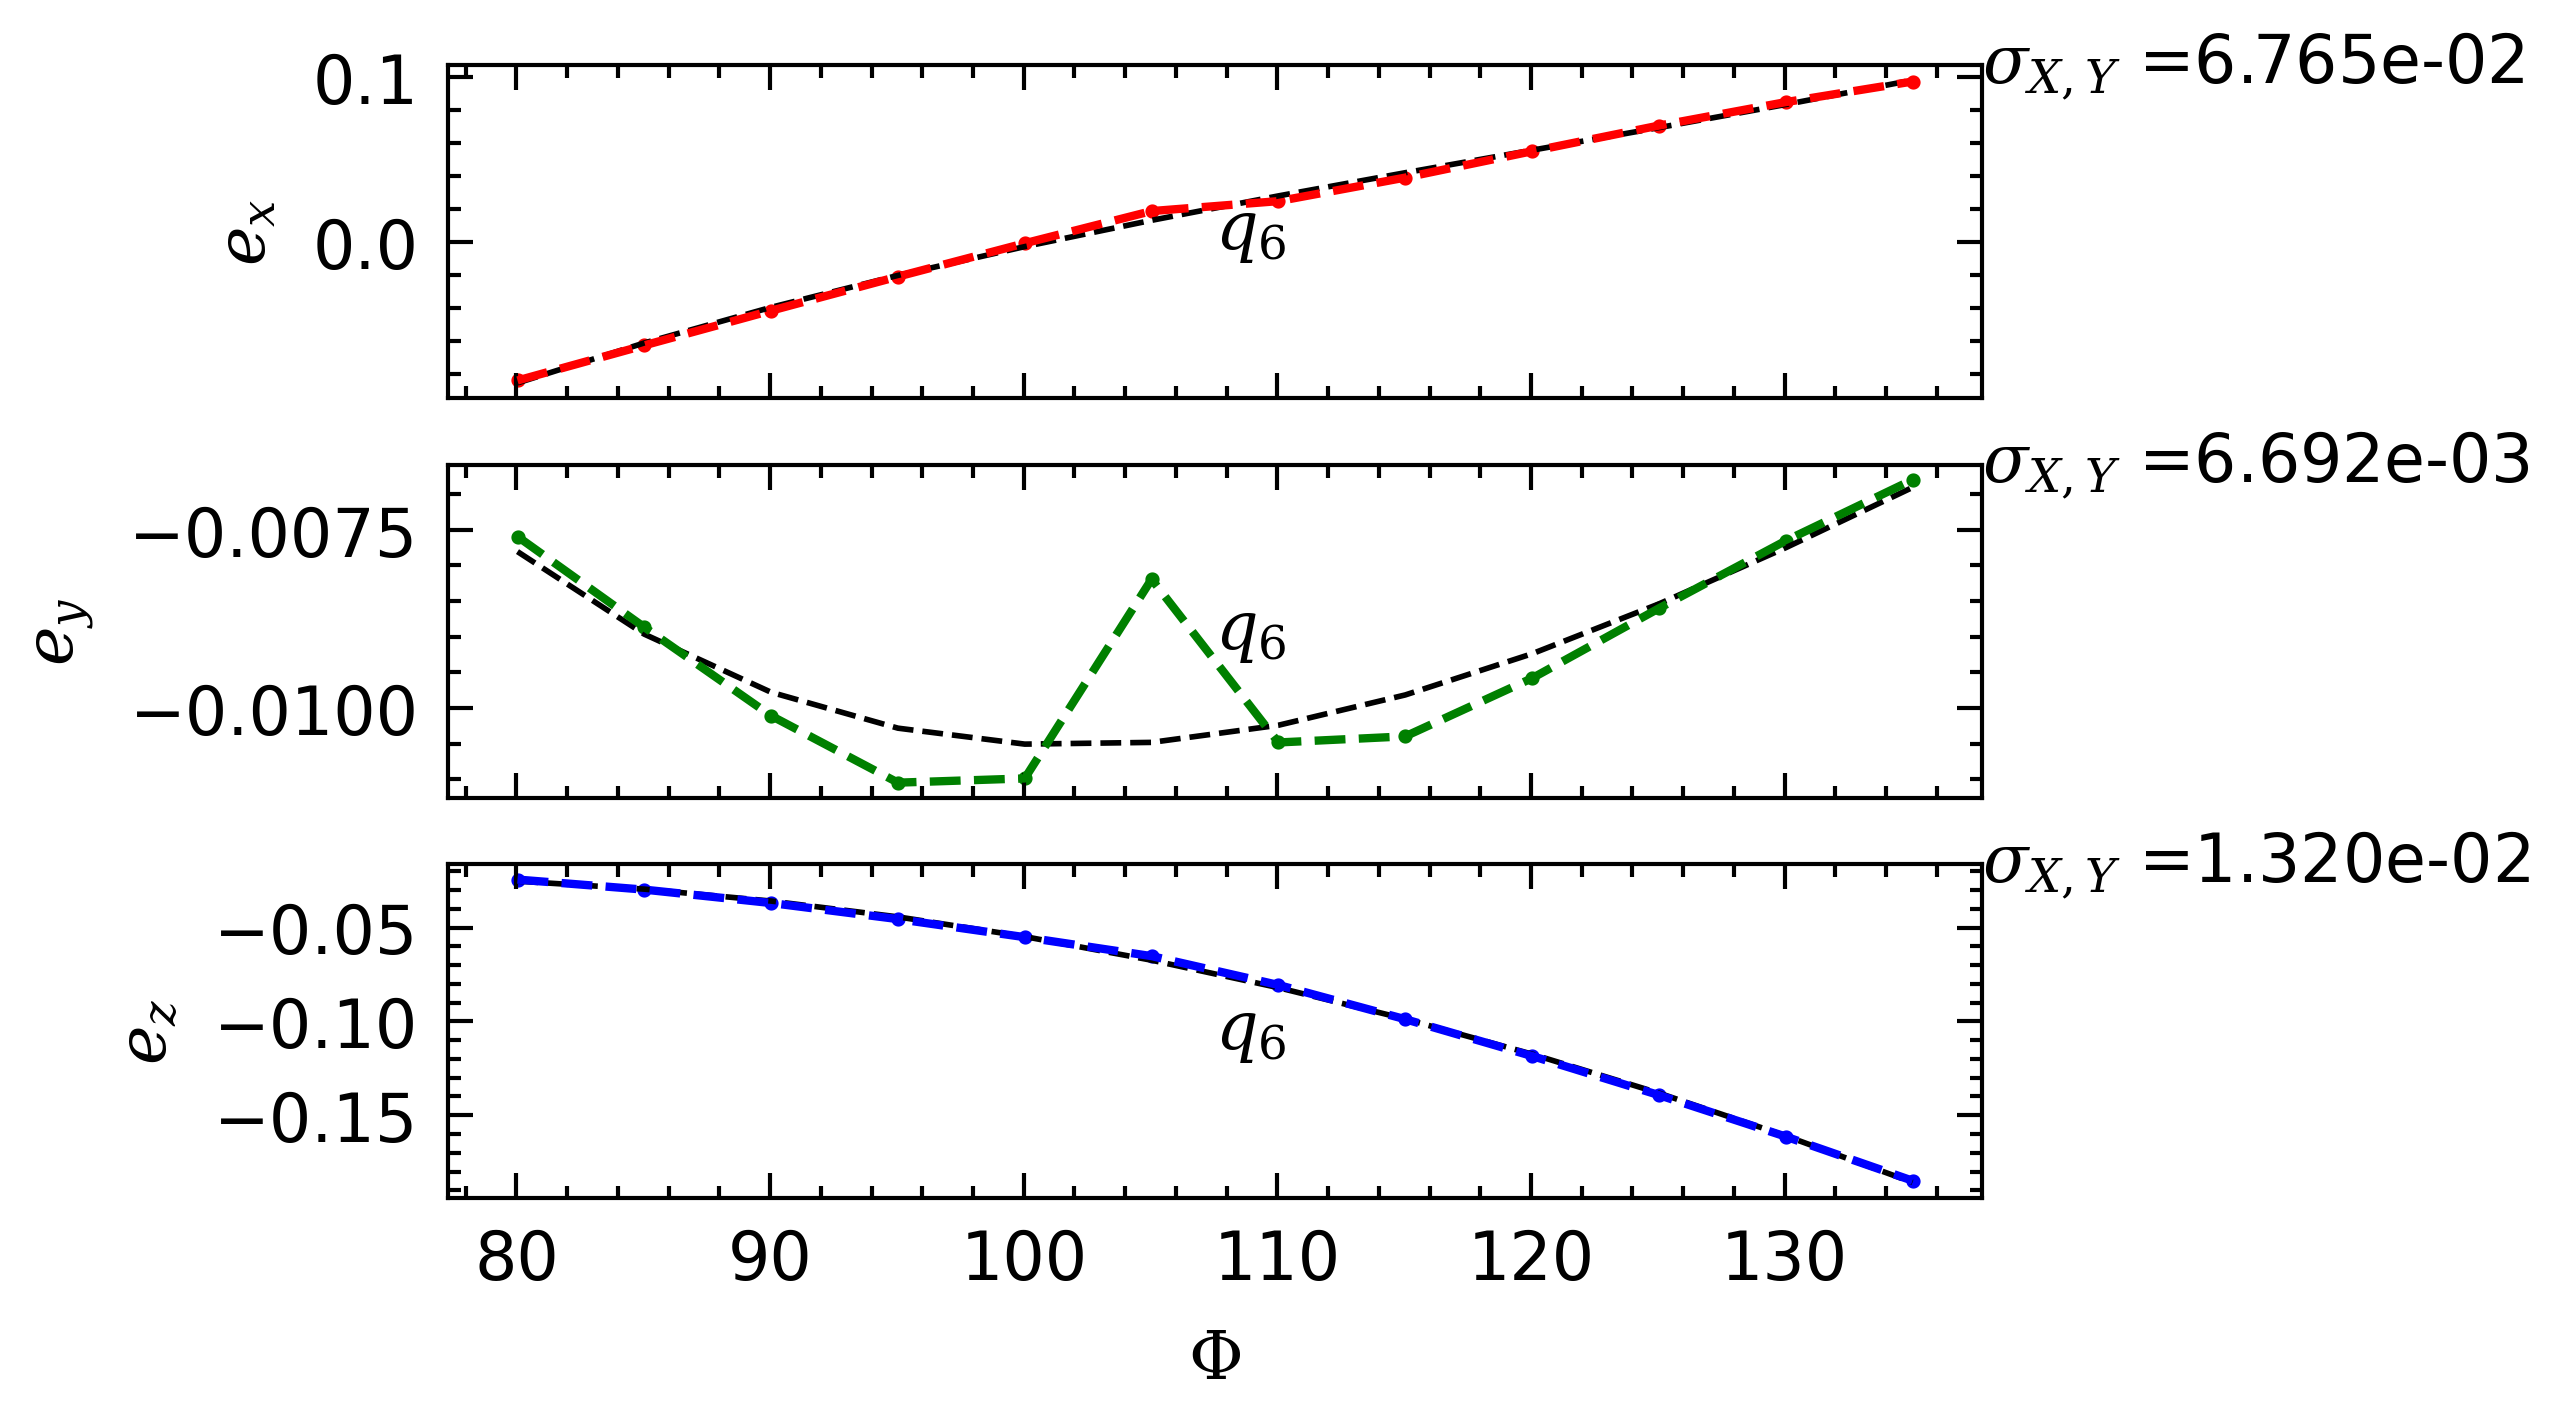

In [243]:
a3_values = np.arange(eq_a3 - 30, eq_a3 + 30, 5)


df_w_angle_1000 = get_FDCM_data("/home/boittier/FDCM/angle_1000", "water_angle1000.csv")
df_w_angle_1000["dihedral"] = [a3_values[int(x)] for x in list(df_w_angle_1000["dihedral"])]
df_w_angle_1000 = df_w_angle_1000.sort_values("dihedral")
df_w_angle_1000.plot("dihedral", "total")

fit_functions = []

for i in range(6):
    fit_functions.append(plot_charge(i, df_w_angle_1000, "hello"))

scan_point  dihedral  close_range  mid_range  far_range     total  \
5     angle_1     80.04     3.279286   1.699780   0.995325  2.309348   
4     angle_2     85.04     2.820835   1.430750   0.834613  1.974722   
3     angle_3     90.04     2.355506   1.153131   0.667192  1.632990   
2     angle_4     95.04     1.897190   0.877081   0.498280  1.295565   
1     angle_5    100.04     1.477248   0.620463   0.336390  0.985854   
0     angle_6    105.04     1.150726   0.422229   0.201205  0.747100   
6     angle_7    110.04     1.007961   0.365969   0.155758  0.652182   
7     angle_8    115.04     1.097697   0.474805   0.230813  0.734836   
8     angle_9    120.04     1.352084   0.649373   0.337628  0.928274   
9    angle_10    125.04     1.676412   0.831246   0.438817  1.160304   
10   angle_11    130.04     2.024172   1.002798   0.525522  1.399649   
11   angle_12    135.04     2.370263   1.159221   0.596305  1.631513   
12   angle_13    140.04     2.707664   1.299319   0.648899  1.851672   

      rmsd_atoms  rmsd_charges                                   path  \
5   0.000000e+00  0.000000e+00   /home/boittier/FDCM/angle_bi/angle_1   
4   0.000000e+00  0.000000e+00   /home/boittier/FDCM/angle_bi/angle_2   
3   0.000000e+00  0.000000e+00   /home/boittier/FDCM/angle_bi/angle_3   
2   2.107342e-08  4.214685e-08   /home/boittier/FDCM/angle_bi/angle_4   
1   0.000000e+00  5.960464e-08   /home/boittier/FDCM/angle_bi/angle_5   
0   0.000000e+00  0.000000e+00   /home/boittier/FDCM/angle_bi/angle_6   
6   0.000000e+00  4.214685e-08   /home/boittier/FDCM/angle_bi/angle_7   
7   0.000000e+00  0.000000e+00   /home/boittier/FDCM/angle_bi/angle_8   
8   2.107342e-08  5.960464e-08   /home/boittier/FDCM/angle_bi/angle_9   
9   2.107342e-08  0.000000e+00  /home/boittier/FDCM/angle_bi/angle_10   
10  2.107342e-08  0.000000e+00  /home/boittier/FDCM/angle_bi/angle_11   
11  0.000000e+00  0.000000e+00  /home/boittier/FDCM/angle_bi/angle_12   
12  0.000000e+00  0.000000e+00  /home/boittier/FDCM/angle_bi/angle_13   

        x_c0  ...      z_c2      z_c3     z_c4      z_c5      q_c0      q_c1  \
5   0.132738  ...  0.095379  0.260984 -0.14101 -0.074822 -0.282216 -0.311638   
4   0.132738  ...  0.095379  0.260984 -0.14101 -0.074822 -0.282216 -0.311638   
3   0.132738  ...  0.095379  0.260984 -0.14101 -0.074822 -0.282216 -0.311638   
2   0.132738  ...  0.095379  0.260984 -0.14101 -0.074822 -0.282216 -0.311638   
1   0.132738  ...  0.095379  0.260984 -0.14101 -0.074822 -0.282216 -0.311638   
0   0.132738  ...  0.095379  0.260984 -0.14101 -0.074822 -0.282216 -0.311638   
6   0.132738  ...  0.095379  0.260984 -0.14101 -0.074822 -0.282216 -0.311638   
7   0.132738  ...  0.095379  0.260984 -0.14101 -0.074822 -0.282216 -0.311638   
8   0.132738  ...  0.095379  0.260984 -0.14101 -0.074822 -0.282216 -0.311638   
9   0.132738  ...  0.095379  0.260984 -0.14101 -0.074822 -0.282216 -0.311638   
10  0.132738  ...  0.095379  0.260984 -0.14101 -0.074822 -0.282216 -0.311638   
11  0.132738  ...  0.095379  0.260984 -0.14101 -0.074822 -0.282216 -0.311638   
12  0.132738  ...  0.095379  0.260984 -0.14101 -0.074822 -0.282216 -0.311638   

       q_c2      q_c3      q_c4      q_c5  
5   0.19663  0.090174  0.064911  0.242139  
4   0.19663  0.090174  0.064911  0.242139  
3   0.19663  0.090174  0.064911  0.242139  
2   0.19663  0.090174  0.064911  0.242139  
1   0.19663  0.090174  0.064911  0.242139  
0   0.19663  0.090174  0.064911  0.242139  
6   0.19663  0.090174  0.064911  0.242139  
7   0.19663  0.090174  0.064911  0.242139  
8   0.19663  0.090174  0.064911  0.242139  
9   0.19663  0.090174  0.064911  0.242139  
10  0.19663  0.090174  0.064911  0.242139  
11  0.19663  0.090174  0.064911  0.242139  
12  0.19663  0.090174  0.064911  0.242139  

[13 rows x 33 columns]

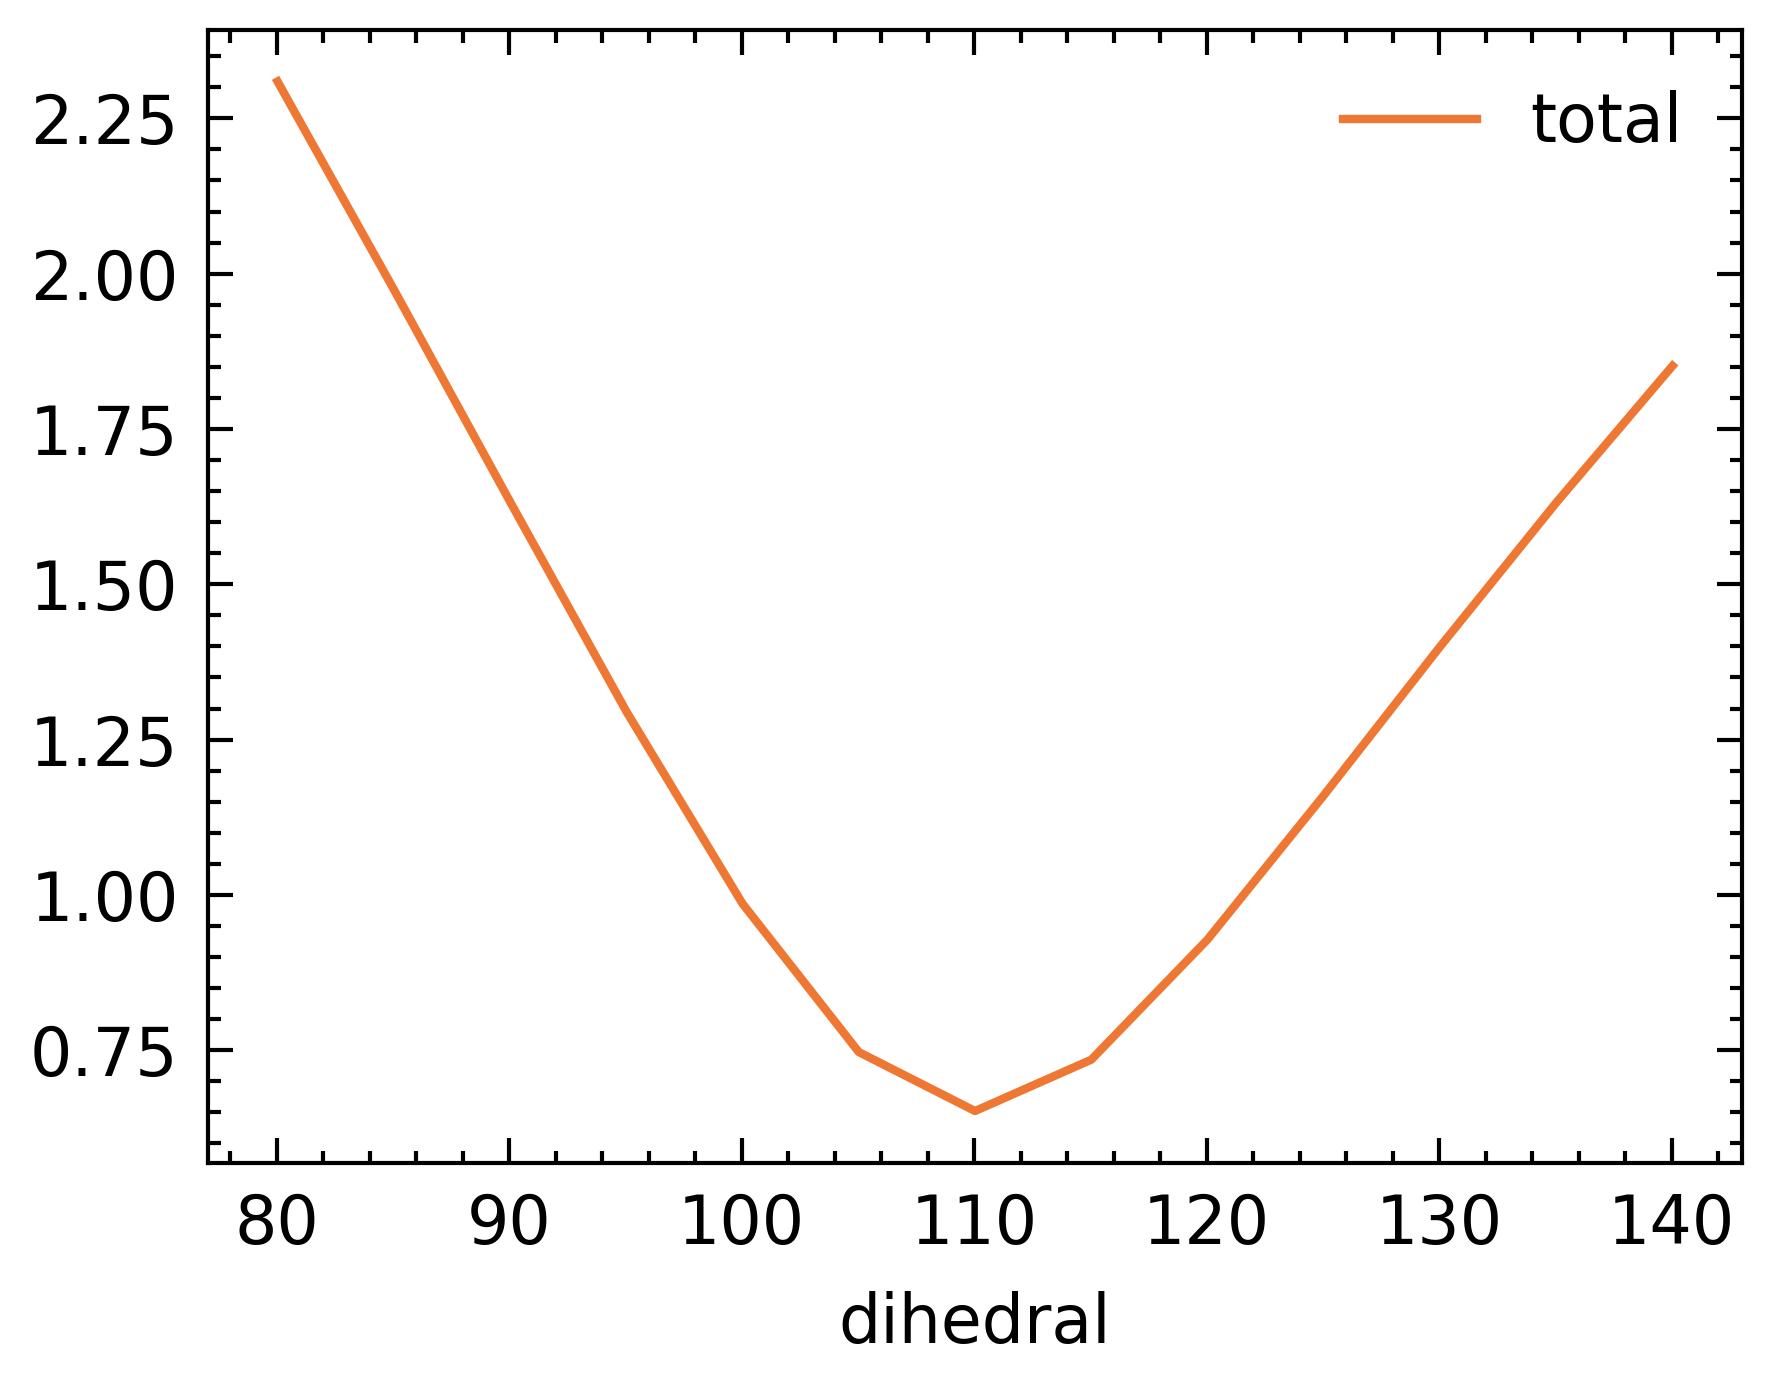

In [259]:
a3_values = np.arange(eq_a3 - 30, eq_a3 + 30, 5)
a3_values = np.append(a3_values, a3_values[-1]+5)

df_w_bi_angle_0 = get_FDCM_data("/home/boittier/FDCM/angle_bi", "water_bi_angle.csv")
df_w_bi_angle_0["dihedral"] = [a3_values[int(x)] for x in list(df_w_bi_angle_0["dihedral"])]
df_w_bi_angle_0 = df_w_bi_angle_0.sort_values("dihedral")
df_w_bi_angle_0.plot("dihedral", "total")

# fit_functions = []

# for i in range(6):
#     fit_functions.append(plot_charge(i, df_w_angle_1000, "hello"))
# df_w_bi_angle_0.plot("path", "total", kind="bar")
df_w_bi_angle_0

<AxesSubplot:xlabel='dihedral'>

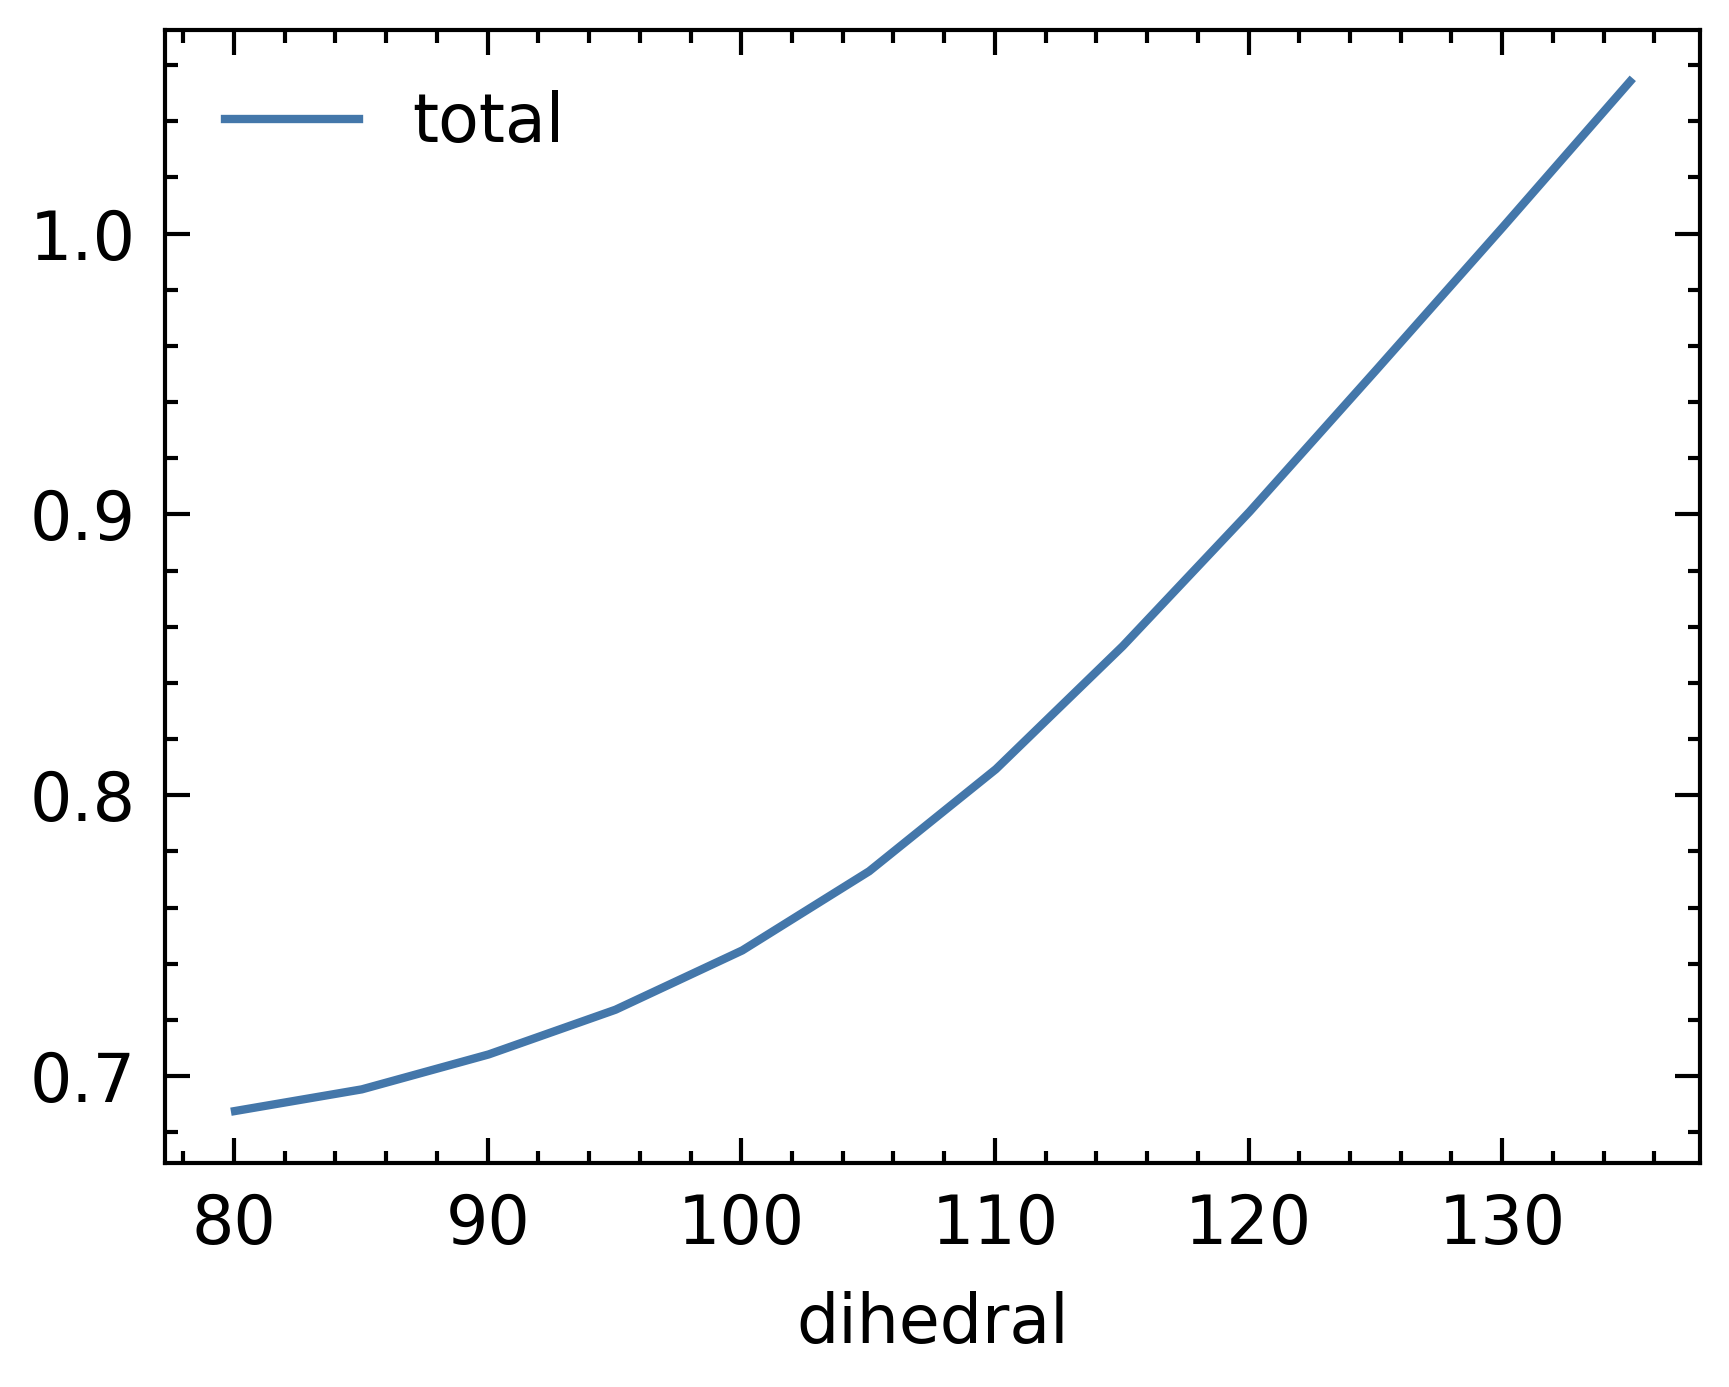

In [331]:
a3_values = np.arange(eq_a3 - 30, eq_a3 + 30, 5)
a3_values = np.append(a3_values, a3_values[-1]+5)

df_w_fit_33_angle_0 = get_FDCM_data("/home/boittier/FDCM/angle_fit_33", "water_fit_33_angle.csv")
df_w_fit_33_angle_0["dihedral"] = [a3_values[int(x)] for x in list(df_w_fit_33_angle_0["dihedral"])]
df_w_fit_33_angle_0 = df_w_fit_33_angle_0.sort_values("dihedral")
df_w_fit_33_angle_0.plot("dihedral", "total")


<AxesSubplot:xlabel='dihedral'>

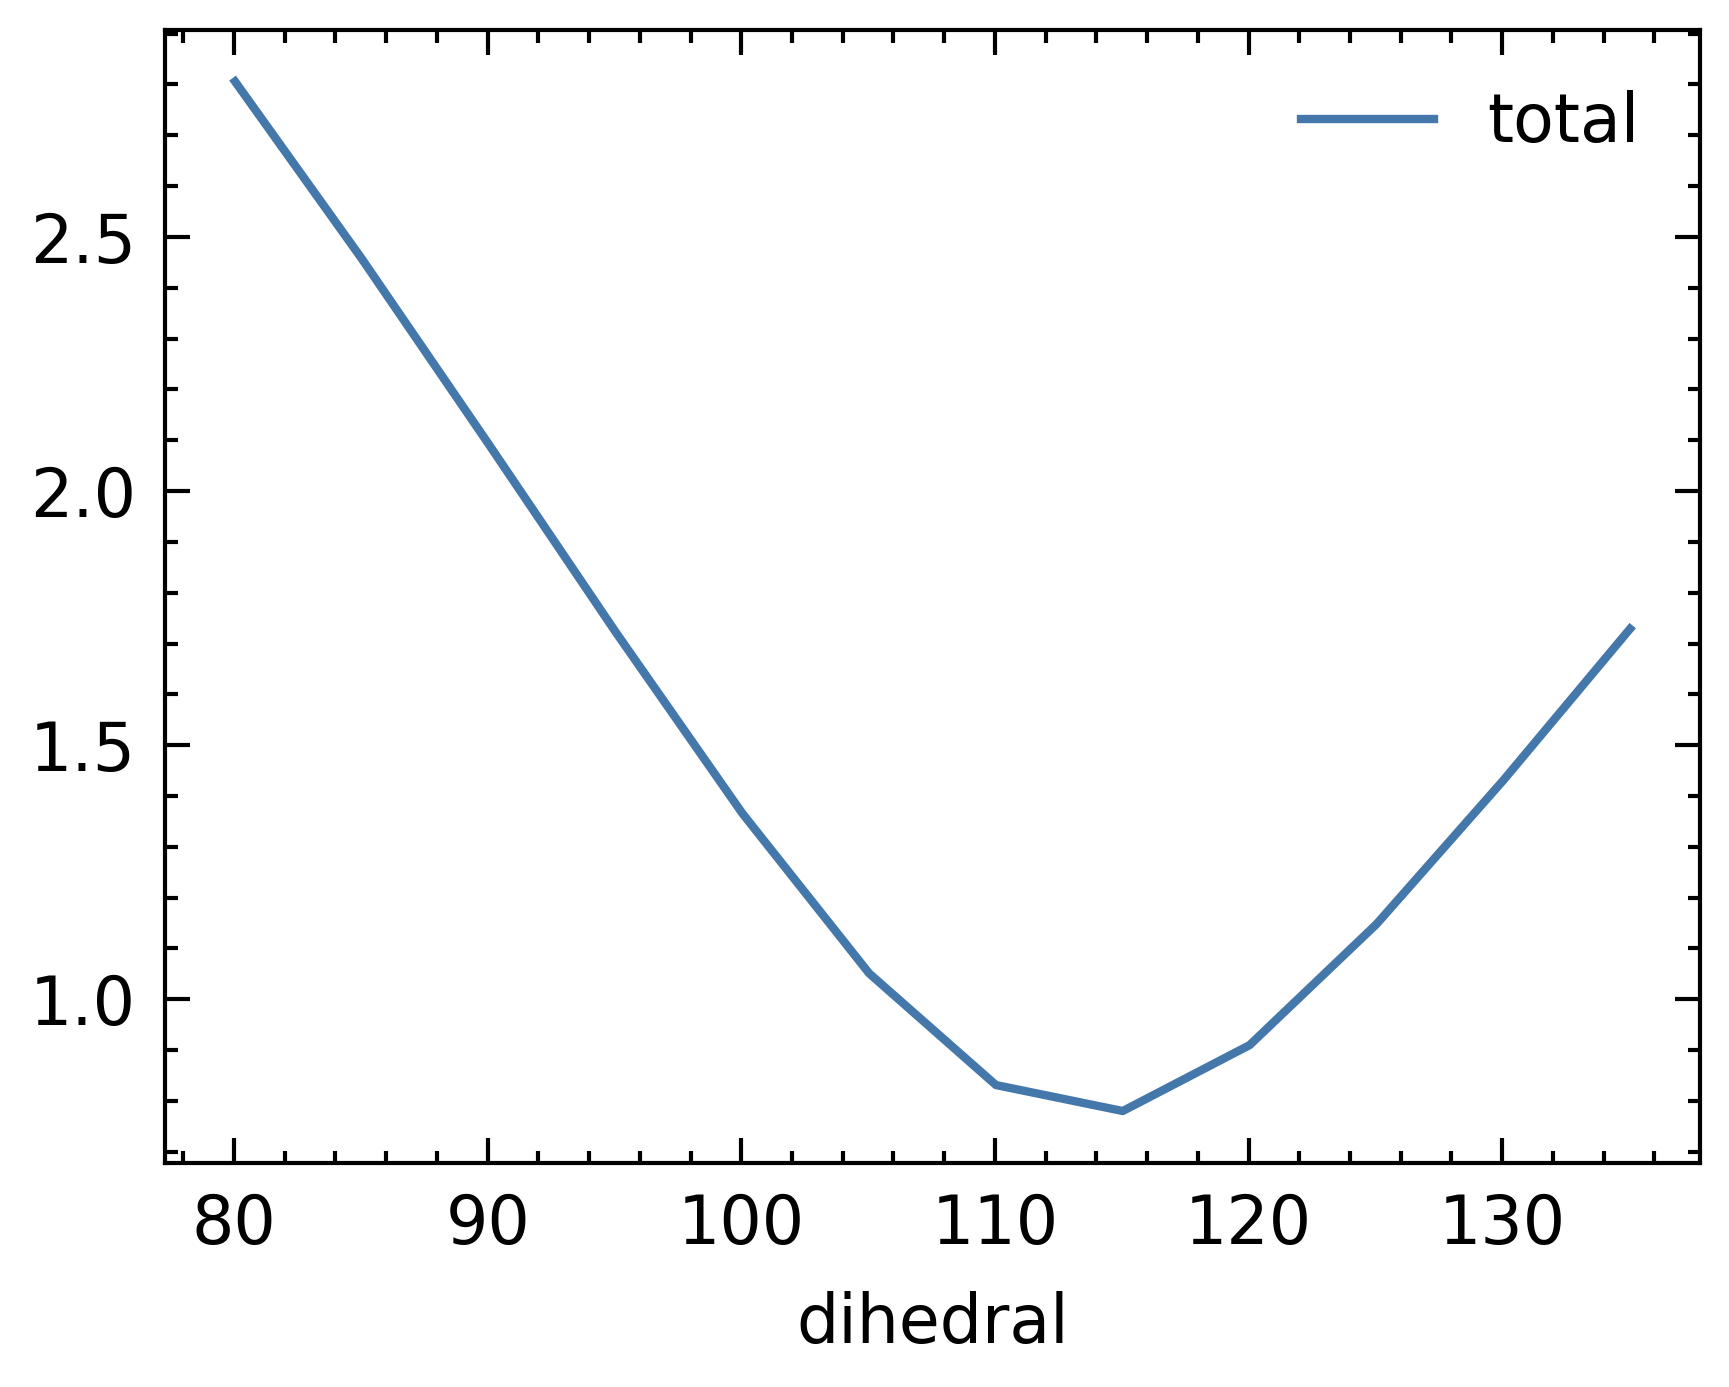

In [332]:
a3_values = np.arange(eq_a3 - 30, eq_a3 + 30, 5)
a3_values = np.append(a3_values, a3_values[-1]+5)

df_w_33_angle_0 = get_FDCM_data("/home/boittier/FDCM/angle_33", "water_33_angle.csv")
df_w_33_angle_0["dihedral"] = [a3_values[int(x)] for x in list(df_w_33_angle_0["dihedral"])]
df_w_33_angle_0 = df_w_33_angle_0.sort_values("dihedral")
df_w_33_angle_0.plot("dihedral", "total")

<AxesSubplot:xlabel='dihedral'>

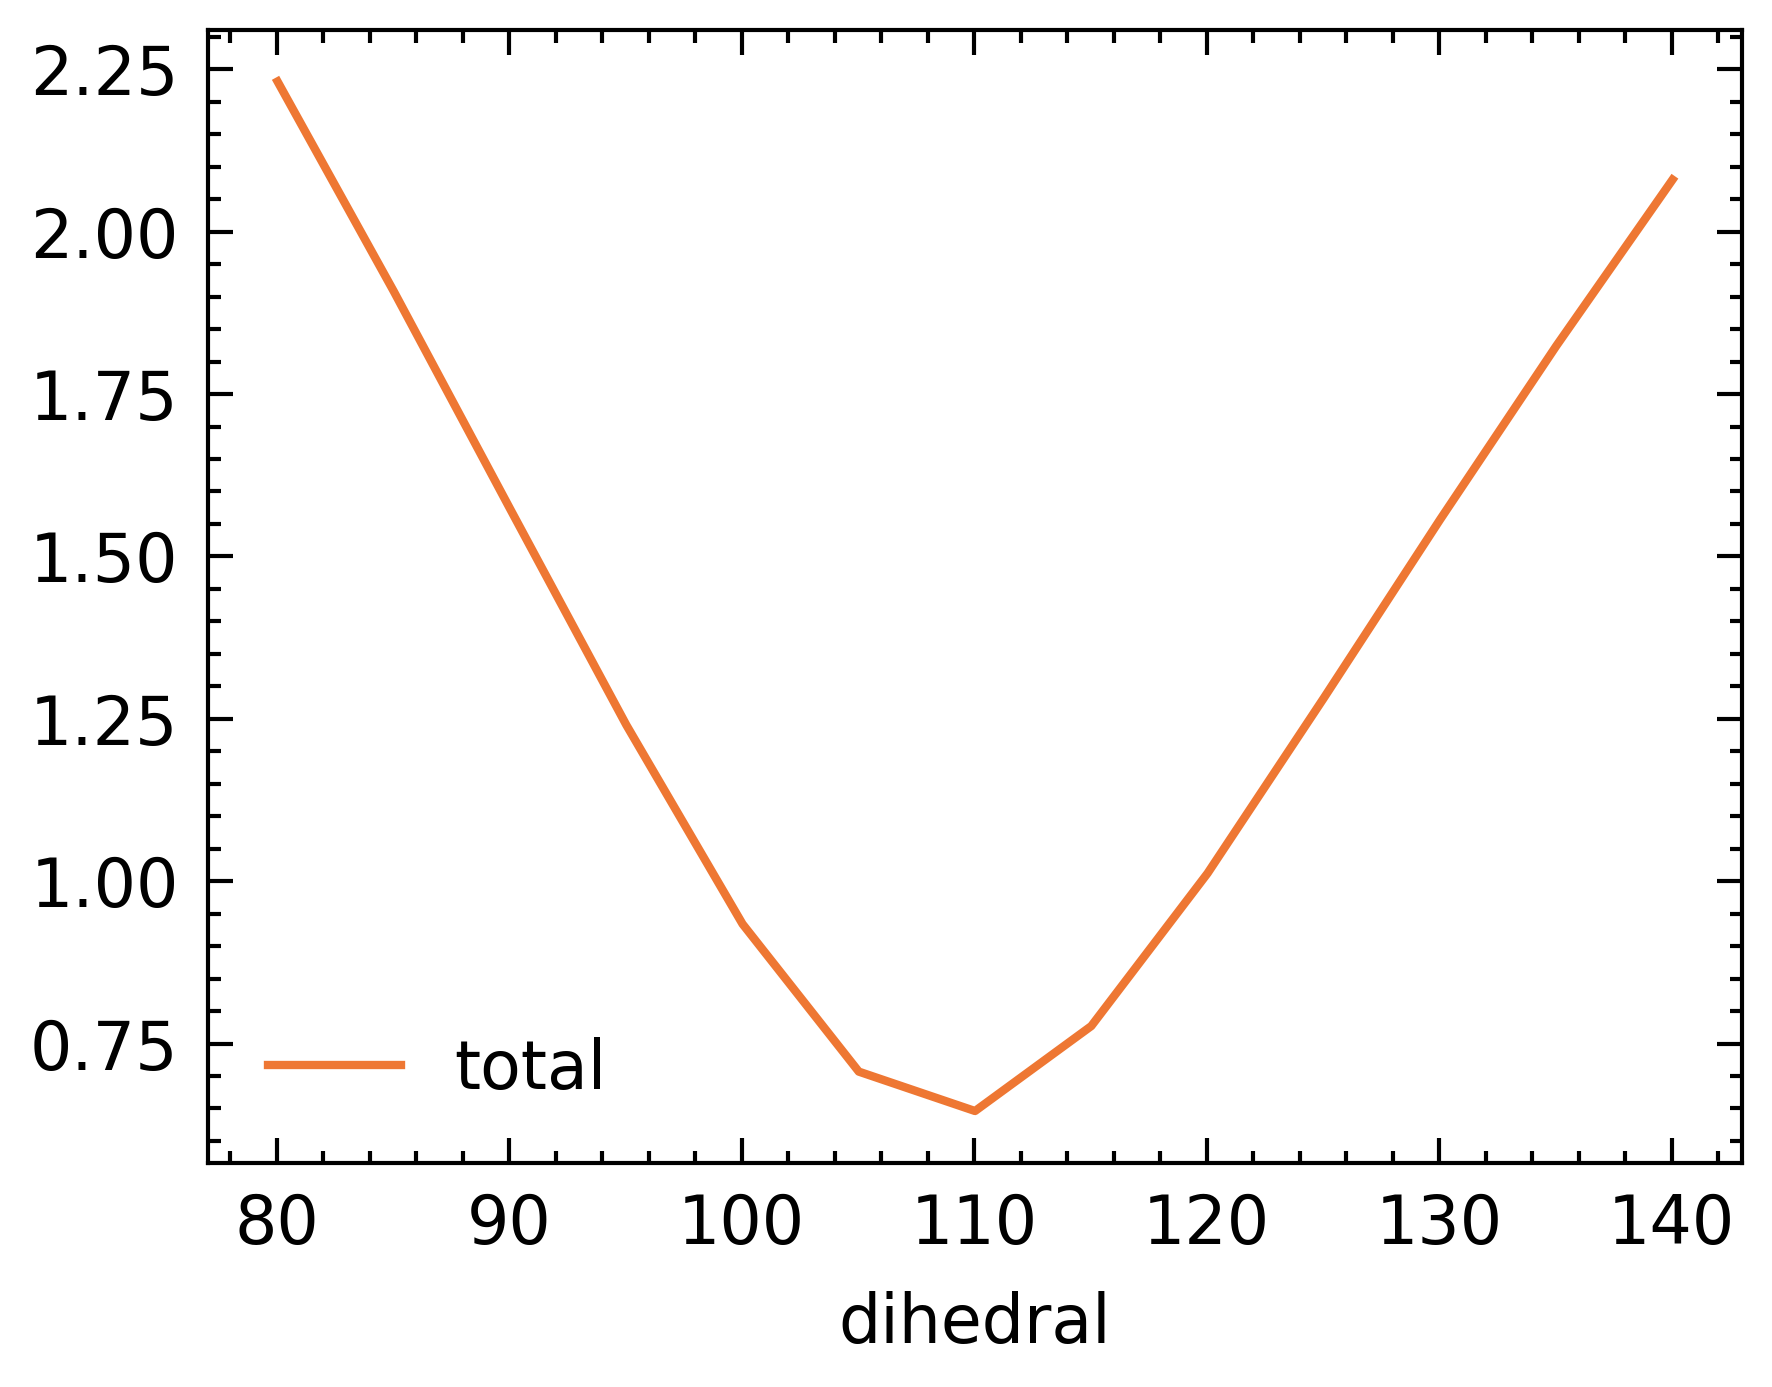

In [326]:
a3_values = np.arange(eq_a3 - 30, eq_a3 + 30, 5)
a3_values = np.append(a3_values, a3_values[-1]+5)

df_w_11_angle_0 = get_FDCM_data("/home/boittier/FDCM/angle_11", "water_11_angle.csv")
df_w_11_angle_0["dihedral"] = [a3_values[int(x)] for x in list(df_w_11_angle_0["dihedral"])]
df_w_11_angle_0 = df_w_11_angle_0.sort_values("dihedral")
df_w_11_angle_0.plot("dihedral", "total")

<AxesSubplot:xlabel='dihedral'>

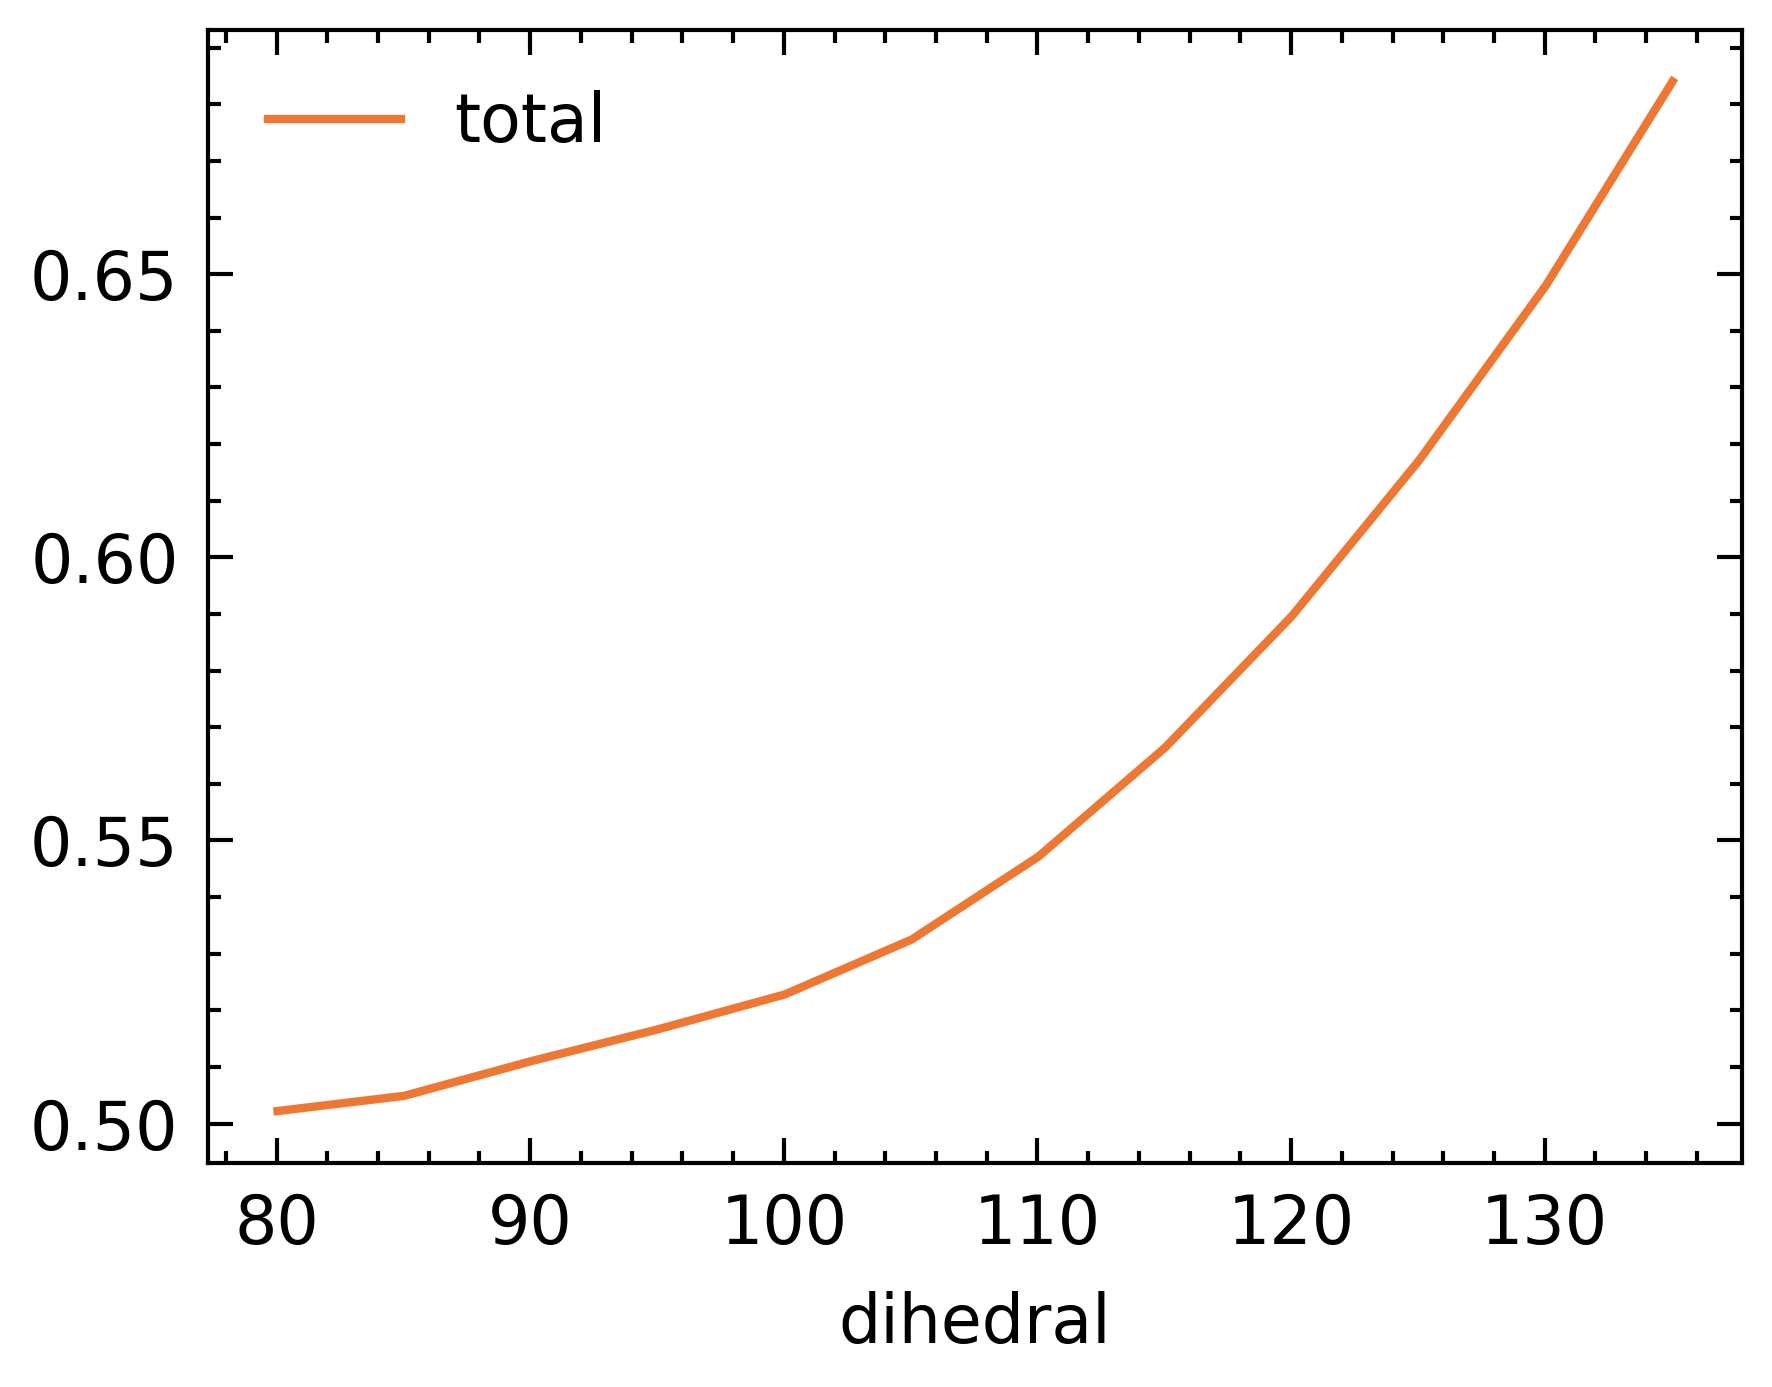

In [328]:
a3_values = np.arange(eq_a3 - 30, eq_a3 + 30, 5)
a3_values = np.append(a3_values, a3_values[-1]+5)

df_w_11_fit_angle_0 = get_FDCM_data("/home/boittier/FDCM/angle_fit_11", "water_fit_11_angle.csv")
df_w_11_fit_angle_0["dihedral"] = [a3_values[int(x)] for x in list(df_w_11_fit_angle_0["dihedral"])]
df_w_11_fit_angle_0 = df_w_11_fit_angle_0.sort_values("dihedral")
df_w_11_fit_angle_0.plot("dihedral", "total")

In [17]:
a3_values
df_w_angle_1000

scan_point  dihedral  close_range  mid_range  far_range     total  \
5     angle_1     80.04     0.817999   0.253142   0.097978  0.517331   
4     angle_2     85.04     0.804057   0.245928   0.095073  0.508076   
3     angle_3     90.04     0.806499   0.244685   0.093329  0.509240   
2     angle_4     95.04     0.820946   0.249485   0.093173  0.518424   
1     angle_5    100.04     0.848488   0.260934   0.095934  0.536357   
0     angle_6    105.04     0.892342   0.287719   0.108647  0.567300   
6     angle_7    110.04     0.889836   0.283438   0.105042  0.564485   
7     angle_8    115.04     0.921670   0.291374   0.107069  0.583791   
8     angle_9    120.04     0.959061   0.301896   0.111168  0.606564   
9    angle_10    125.04     1.000697   0.315467   0.117635  0.632540   
10   angle_11    130.04     1.051455   0.333304   0.126621  0.664713   
11   angle_12    135.04     1.114486   0.356810   0.138765  0.705007   

      rmsd_atoms  rmsd_charges                                     path  \
5   0.000000e+00  0.000000e+00   /home/boittier/FDCM/angle_1000/angle_1   
4   0.000000e+00  4.214685e-08   /home/boittier/FDCM/angle_1000/angle_2   
3   0.000000e+00  0.000000e+00   /home/boittier/FDCM/angle_1000/angle_3   
2   2.107342e-08  0.000000e+00   /home/boittier/FDCM/angle_1000/angle_4   
1   0.000000e+00  4.214685e-08   /home/boittier/FDCM/angle_1000/angle_5   
0   0.000000e+00  0.000000e+00   /home/boittier/FDCM/angle_1000/angle_6   
6   0.000000e+00  4.214685e-08   /home/boittier/FDCM/angle_1000/angle_7   
7   0.000000e+00  4.214685e-08   /home/boittier/FDCM/angle_1000/angle_8   
8   2.107342e-08  5.960464e-08   /home/boittier/FDCM/angle_1000/angle_9   
9   2.107342e-08  4.214685e-08  /home/boittier/FDCM/angle_1000/angle_10   
10  2.107342e-08  4.214685e-08  /home/boittier/FDCM/angle_1000/angle_11   
11  0.000000e+00  0.000000e+00  /home/boittier/FDCM/angle_1000/angle_12   

        x_c0  ...      z_c2      z_c3      z_c4      z_c5      q_c0      q_c1  \
5   0.029856  ...  0.012471  0.273952 -0.106159 -0.024439 -0.282216 -0.311638   
4   0.042144  ...  0.023612  0.274191 -0.109570 -0.029806 -0.282216 -0.311638   
3   0.055681  ...  0.037236  0.274415 -0.114617 -0.036945 -0.282216 -0.311638   
2   0.070159  ...  0.052744  0.274343 -0.120855 -0.045506 -0.282216 -0.311638   
1   0.084873  ...  0.069145  0.273444 -0.127821 -0.055128 -0.282216 -0.311638   
0   0.098144  ...  0.084491  0.270083 -0.134853 -0.065226 -0.282216 -0.311638   
6   0.113669  ...  0.098643  0.282194 -0.147508 -0.080596 -0.282216 -0.311638   
7   0.130711  ...  0.116881  0.293322 -0.162026 -0.098835 -0.282216 -0.311638   
8   0.147909  ...  0.135912  0.304598 -0.176320 -0.118443 -0.282216 -0.311638   
9   0.164390  ...  0.155049  0.316998 -0.189935 -0.139242 -0.282216 -0.311638   
10  0.179514  ...  0.174114  0.331202 -0.202803 -0.161345 -0.282216 -0.311638   
11  0.192671  ...  0.193308  0.347510 -0.214873 -0.184845 -0.282216 -0.311638   

       q_c2      q_c3      q_c4      q_c5  
5   0.19663  0.090174  0.064911  0.242139  
4   0.19663  0.090174  0.064911  0.242139  
3   0.19663  0.090174  0.064911  0.242139  
2   0.19663  0.090174  0.064911  0.242139  
1   0.19663  0.090174  0.064911  0.242139  
0   0.19663  0.090174  0.064911  0.242139  
6   0.19663  0.090174  0.064911  0.242139  
7   0.19663  0.090174  0.064911  0.242139  
8   0.19663  0.090174  0.064911  0.242139  
9   0.19663  0.090174  0.064911  0.242139  
10  0.19663  0.090174  0.064911  0.242139  
11  0.19663  0.090174  0.064911  0.242139  

[12 rows x 33 columns]

In [91]:
a3_values = np.array(df_w_angle_1000["dihedral"])
for i, a3 in enumerate(a3_values):
    local_charges = [[f(a3) for f in fs] for fs in fit_functions]
#     print(local_charges)
    
    
keys = ["dihedral"]
fit_df_dict = {"dihedral": a3_values}

for c in range(6):
    key = f"q_c{c}"
    fit_df_dict[key] = df_w_angle_1000[key][0]
    for i, axis in enumerate(["x", "y", "z"]):
        keys.append(f"{axis}_c{c}")
#         print(fit_functions[c][i](a3_values))
        fit_df_dict[f"{axis}_c{c}"] = fit_functions[c][i](a3_values)
        
# print(fit_df_dict)        
fit_df = pd.DataFrame(fit_df_dict)   
diff_df = fit_df - df_w_angle_1000[keys]

sqr_df = diff_df **2 
rmsd = np.sqrt(sqr_df.sum()/21)
rmsd.sum()
fit_df
n_charges = 6
header = "s                      x[A]                      y[A]                      z[A]                      q[e]\n"

cube_path_format = "/home/boittier/v1/angle_{}_new.com.chk.fchk.d.cube"
frame_file = "/home/boittier/v1/frames.txt" 

for i, row in enumerate(fit_df.iterrows()):
    path = "/home/boittier/FDCM/angle_fit/angle_{}/".format(i+1)
    new_path = path
    
    try:
        os.mkdir(new_path)
    except FileExistsError:
        pass
    
    fitted_local = []
    
    new_xyz_file = os.path.join(new_path, "fitted_local.xyz")
    nf = open(new_xyz_file, "w")
    nf.write(f"{n_charges}\n")
    nf.write(header)
    for c in range(n_charges):
        values = []
        for j, axis in enumerate(["x", "y", "z", "q"]):
            values.append(row[1][f"{axis}_c{c}"])
            
        if values[3] > 0:
            c_name = "N"
        else:
            c_name = "O"
        nf.write("{0:} {1:.16f} {2:.16f} {3:.16f} {4:.16f}\n".format(c_name, *values))
        
        fitted_local.append(values[:-1])
        
    nf.close()
    
    scan_point = i + 1
    
    pcube = cube_path_format.format(scan_point)
    old_global_xyz = os.path.join(f"/home/boittier/FDCM/angle_1000/angle_{scan_point}", "refined.xyz")
    ars_obj = ARS(old_global_xyz, pcube, frame_file, pcube_2=pcube)
    ars_obj.set_local_charge_positions(np.array(fitted_local)) 
    cp = ars_obj.local_to_global()
    ars_obj.set_charge_positions_plus(cp)
    ars_obj.save_charges_global(os.path.join(new_path, "fitted_global.xyz"))


home/boittier/FDCM/angle_fit/angle_1/global_fitted_global.xyz
home/boittier/FDCM/angle_fit/angle_2/global_fitted_global.xyz
home/boittier/FDCM/angle_fit/angle_3/global_fitted_global.xyz
home/boittier/FDCM/angle_fit/angle_4/global_fitted_global.xyz
home/boittier/FDCM/angle_fit/angle_5/global_fitted_global.xyz
home/boittier/FDCM/angle_fit/angle_6/global_fitted_global.xyz
home/boittier/FDCM/angle_fit/angle_7/global_fitted_global.xyz
home/boittier/FDCM/angle_fit/angle_8/global_fitted_global.xyz
home/boittier/FDCM/angle_fit/angle_9/global_fitted_global.xyz
home/boittier/FDCM/angle_fit/angle_10/global_fitted_global.xyz
home/boittier/FDCM/angle_fit/angle_11/global_fitted_global.xyz
home/boittier/FDCM/angle_fit/angle_12/global_fitted_global.xyz


In [74]:
a3_values = np.arange(eq_a3 - 30, eq_a3 + 30, 5)
for i, a3 in enumerate(a3_values):
    local_charges = [[f(a3) for f in fs] for fs in fit_functions]
#     print(local_charges)
    
    
keys = ["dihedral"]
fit_df_dict = {"dihedral": a3_values}

for c in range(6):
    key = f"q_c{c}"
    fit_df_dict[key] = df_w_angle_1000[key][0]
    for i, axis in enumerate(["x", "y", "z"]):
        keys.append(f"{axis}_c{c}")
#         print(fit_functions[c][i](a3_values))
        fit_df_dict[f"{axis}_c{c}"] = fit_functions[c][i](a3_values)
        
# print(fit_df_dict)        
fit_df = pd.DataFrame(fit_df_dict)   
diff_df = fit_df - df_w_angle_1000[keys]

sqr_df = diff_df **2 
rmsd = np.sqrt(sqr_df.sum()/21)
rmsd.sum()
fit_df
n_charges = 6
header = "s                      x[A]                      y[A]                      z[A]                      q[e]\n"

cube_path_format = "/home/boittier/v1/2_2_{}_new.com.chk.d.cube"
frame_file = "/home/boittier/v1/frames.txt" 

for i, row in enumerate(fit_df.iterrows()):
    path = "/home/boittier/FDCM/water_fit/2_2_{}/".format(i+1)
    new_path = path
    
    try:
        os.mkdir(new_path)
    except FileExistsError:
        pass
    
    fitted_local = []
    
    new_xyz_file = os.path.join(new_path, "fitted_local.xyz")
    nf = open(new_xyz_file, "w")
    nf.write(f"{n_charges}\n")
    nf.write(header)
    for c in range(n_charges):
        values = []
        for j, axis in enumerate(["x", "y", "z", "q"]):
            values.append(row[1][f"{axis}_c{c}"])
            
        if values[3] > 0:
            c_name = "N"
        else:
            c_name = "O"
        nf.write("{0:} {1:.16f} {2:.16f} {3:.16f} {4:.16f}\n".format(c_name, *values))
        
        fitted_local.append(values[:-1])
        
    nf.close()
    
    scan_point = i + 1
    
    pcube = cube_path_format.format(scan_point)
    
    old_global_xyz = os.path.join(f"/home/boittier/FDCM/water_0/water0_2_2_{scan_point}_new", "refined.xyz")
    
    ars_obj = ARS(old_global_xyz, pcube, frame_file, pcube_2=pcube)
    
    ars_obj.set_local_charge_positions(np.array(fitted_local)) 

    cp = ars_obj.local_to_global()
    ars_obj.set_charge_positions_plus(cp)
    ars_obj.save_charges_global(os.path.join(new_path, "fitted_global.xyz"))


home/boittier/FDCM/water_fit/2_2_1/global_fitted_global.xyz
home/boittier/FDCM/water_fit/2_2_2/global_fitted_global.xyz
home/boittier/FDCM/water_fit/2_2_3/global_fitted_global.xyz


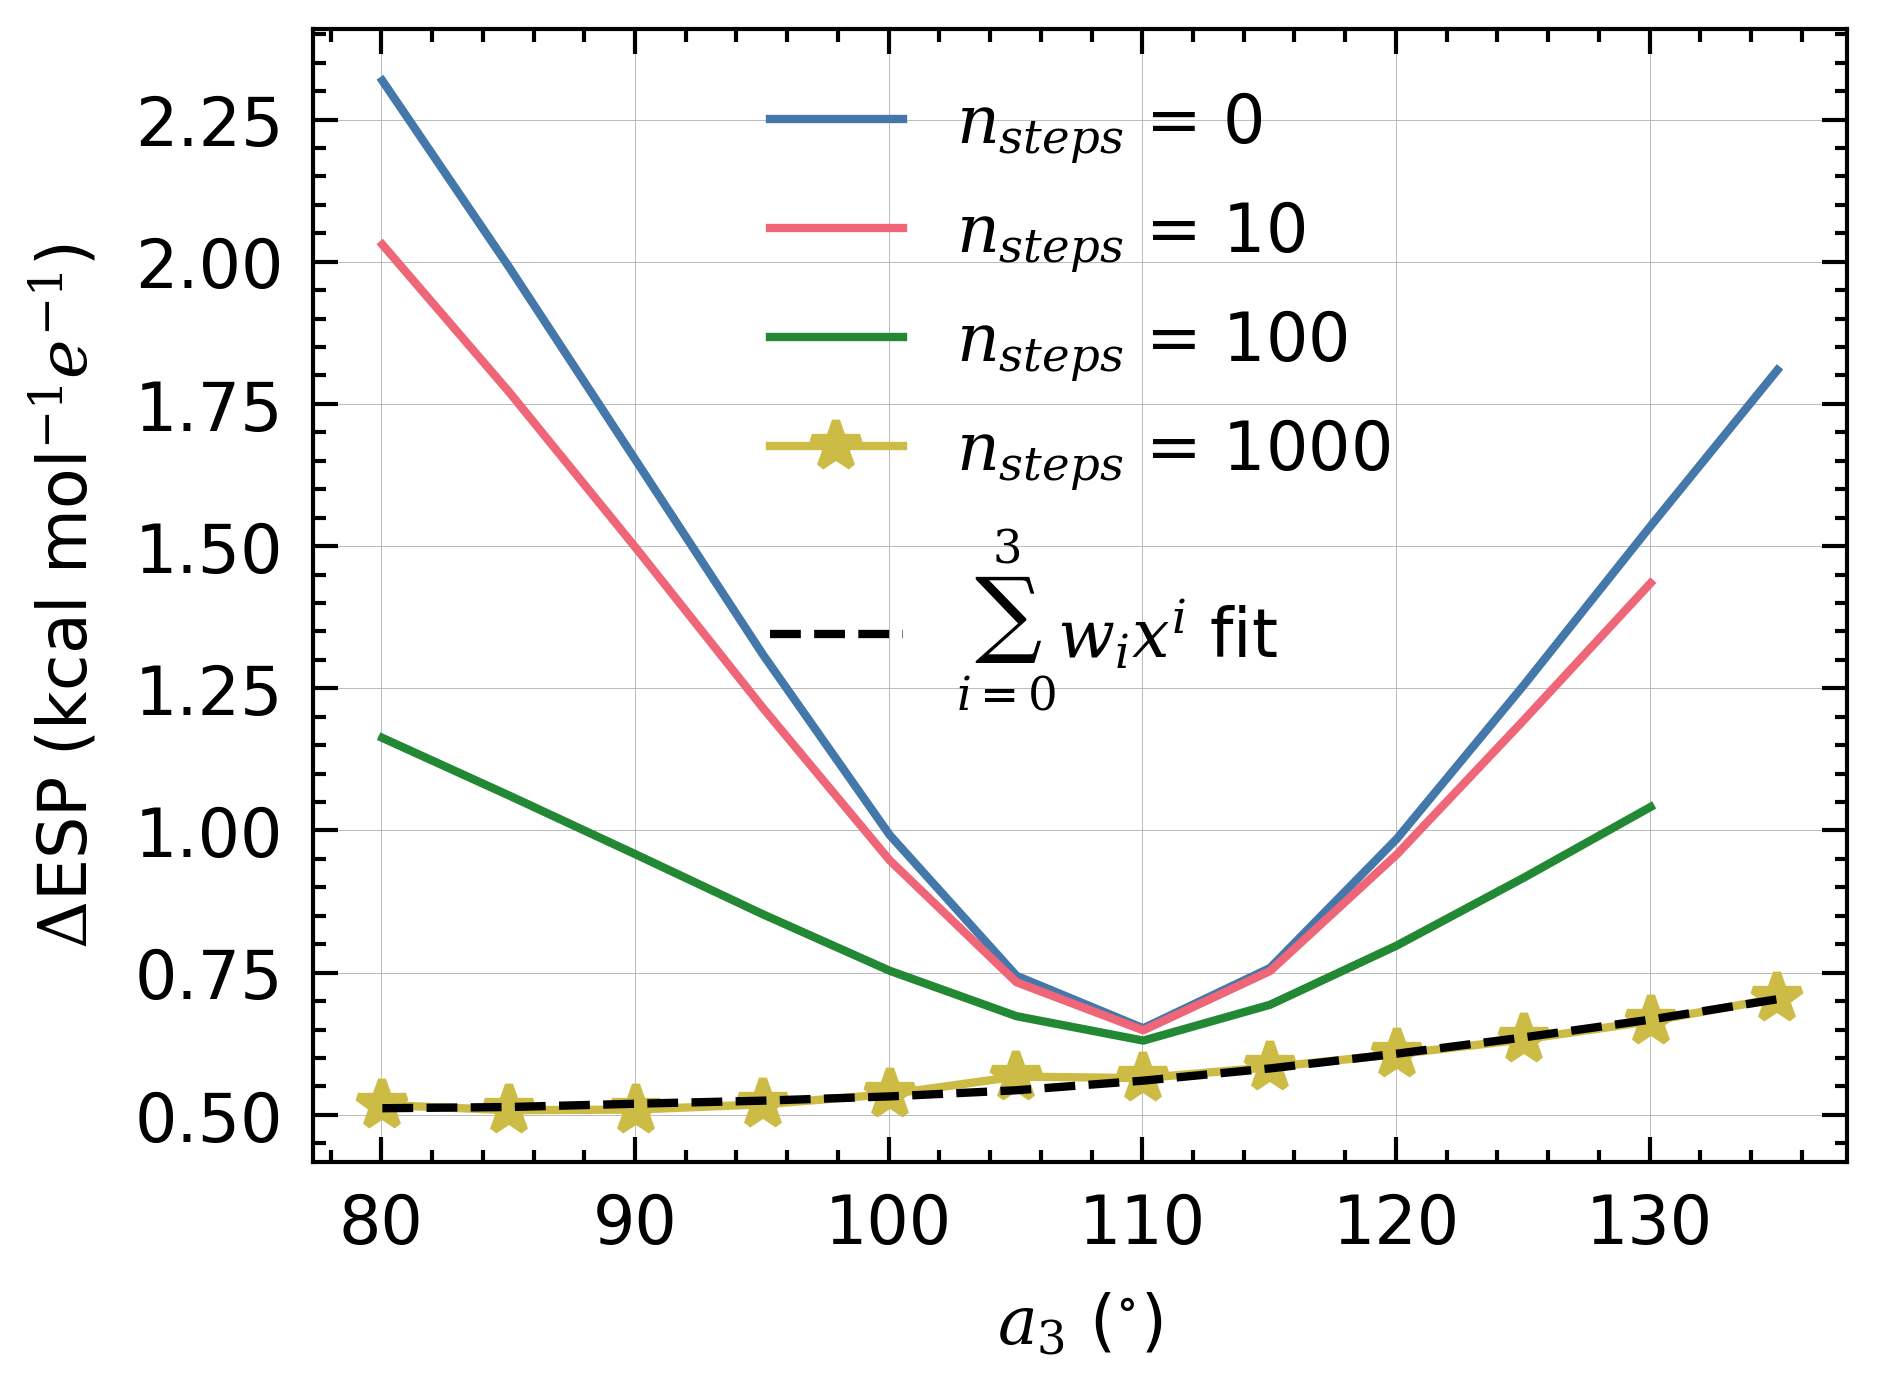

In [139]:
plt.style.use(['science','ieee', "no-latex", "bright"])

_a3 = (np.arange(eq_a3 - 30, eq_a3 + 30, 5))

def a3(x):
    return [_a3[int(i)] for i in x]

plt.plot((df_w_angle["dihedral"]), df_w_angle["total"], 
         "-", label="$n_{steps}$ = 0")  

plt.plot((df_w_angle_10["dihedral"]), df_w_angle_10["total"],
         "-", label="$n_{steps}$ = 10")  

plt.plot((df_w_angle_100["dihedral"]), df_w_angle_100["total"],
         "-", label="$n_{steps}$ = 100")  

plt.plot((df_w_angle_1000["dihedral"]), df_w_angle_1000["total"],
         "-*", label="$n_{steps}$ = 1000")  

plt.plot((df_w_angle_fit["dihedral"]), df_w_angle_fit["total"],
         "--", c="k", label="$\sum^{3}_{i=0} w_{i}x^i$ fit")  


plt.legend()
plt.ylabel("$\Delta$ESP (kcal mol$^{-1} e^{-1}$)")
plt.xlabel("$a_3$ ($^{\circ}$)")
plt.grid(linewidth=0.1)
plt.savefig("angle_fit_summary.pdf", bbox_inches="tight")

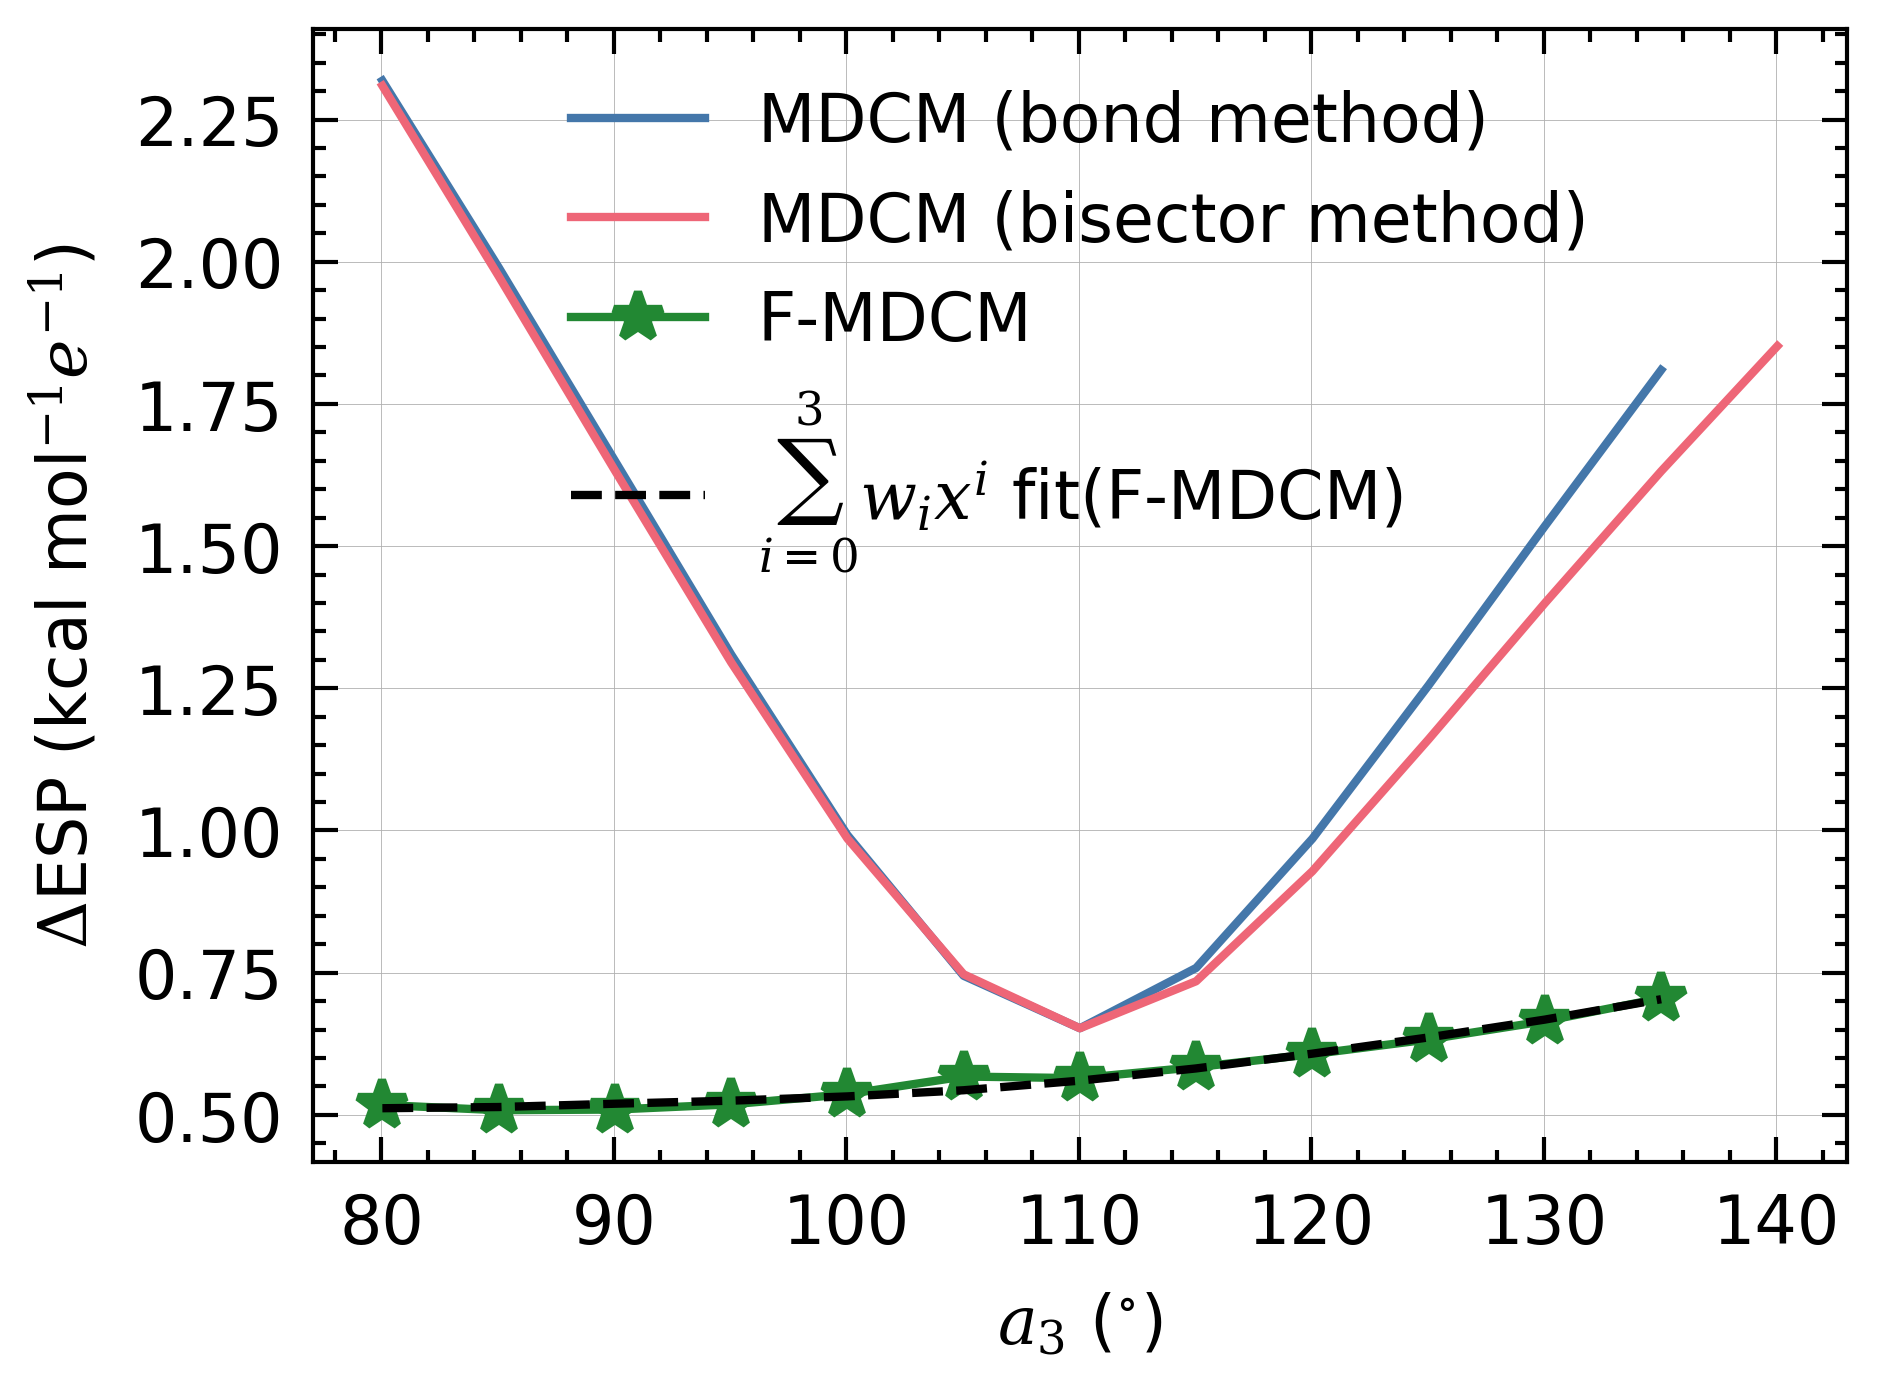

In [260]:
plt.style.use(['science','ieee', "no-latex", "bright"])

_a3 = (np.arange(eq_a3 - 30, eq_a3 + 30, 5))

def a3(x):
    return [_a3[int(i)] for i in x]

plt.plot((df_w_angle["dihedral"]), df_w_angle["total"], 
         "-", label="MDCM (bond method)")  

plt.plot((df_w_bi_angle_0["dihedral"]), df_w_bi_angle_0["total"],
         "-", label="MDCM (bisector method)")  

# plt.plot((df_w_angle_100["dihedral"]), df_w_angle_100["total"],
#          "-", label="$n_{steps}$ = 100")  

plt.plot((df_w_angle_1000["dihedral"]), df_w_angle_1000["total"],
         "-*", label="F-MDCM")  

plt.plot((df_w_angle_fit["dihedral"]), df_w_angle_fit["total"],
         "--", c="k", label="$\sum^{3}_{i=0} w_{i}x^i$ fit(F-MDCM)")  


plt.legend()
plt.ylabel("$\Delta$ESP (kcal mol$^{-1} e^{-1}$)")
plt.xlabel("$a_3$ ($^{\circ}$)")
plt.grid(linewidth=0.1)
plt.savefig("angle_fit_summary.pdf", bbox_inches="tight")

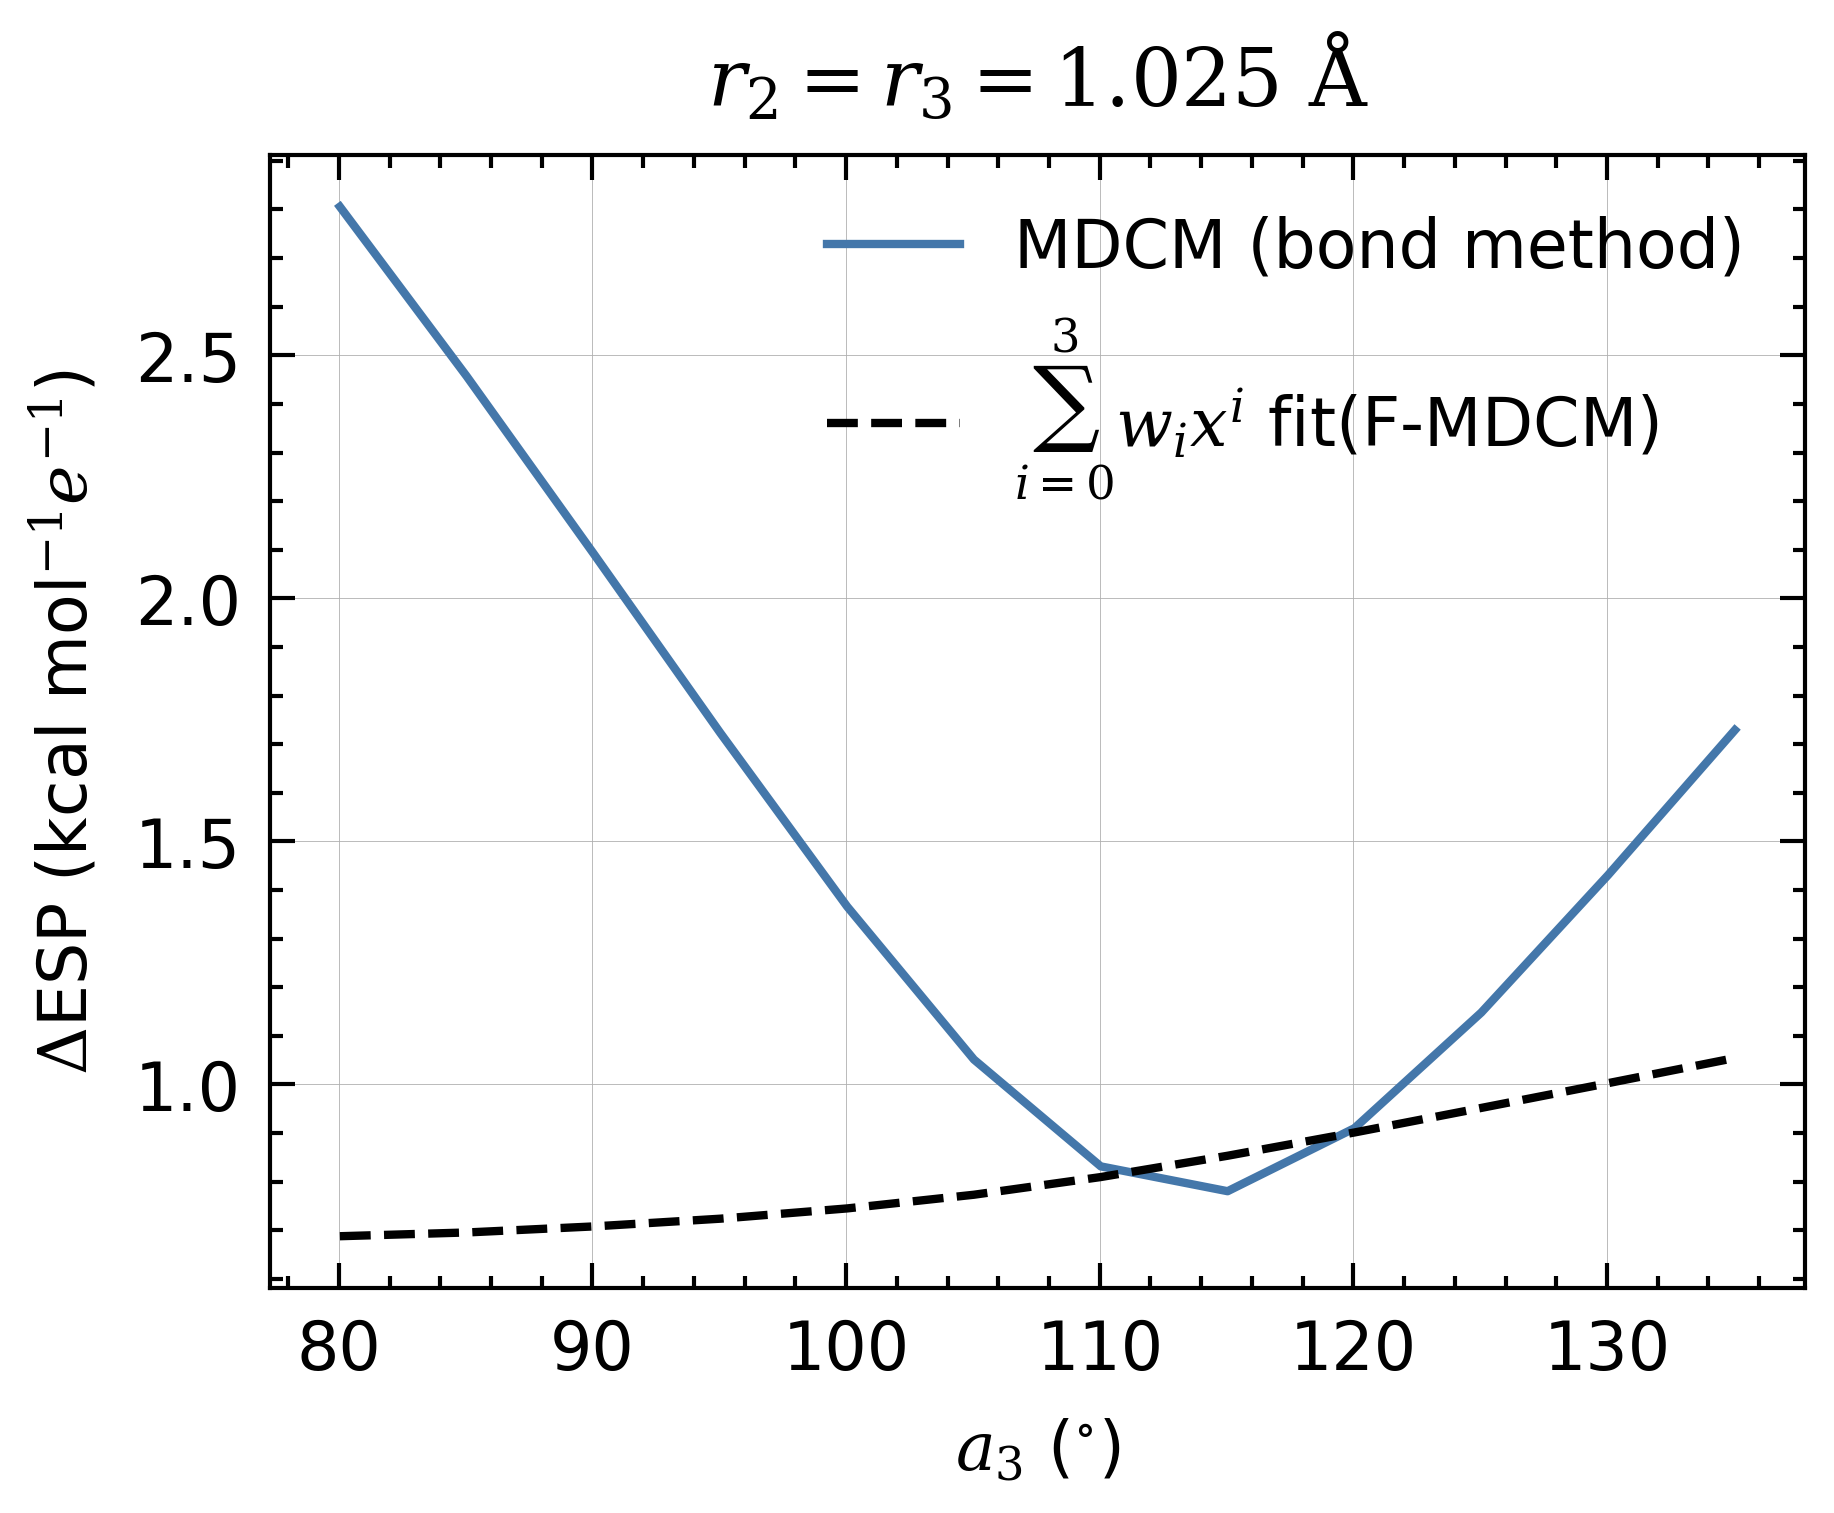

In [337]:
plt.style.use(['science','ieee', "no-latex", "bright"])

_a3 = (np.arange(eq_a3 - 30, eq_a3 + 30, 5))

def a3(x):
    return [_a3[int(i)] for i in x]

plt.plot((df_w_33_angle_0["dihedral"]), df_w_33_angle_0["total"], 
         "-", label="MDCM (bond method)")  

# plt.plot((df_w_bi_angle_0["dihedral"]), df_w_bi_angle_0["total"],
#          "-", label="MDCM (bisector method)")  

# plt.plot((df_w_angle_100["dihedral"]), df_w_angle_100["total"],
#          "-", label="$n_{steps}$ = 100")  

# plt.plot((df_w_angle_1000["dihedral"]), df_w_angle_1000["total"],
#          "-*", label="F-MDCM")  

plt.plot((df_w_fit_33_angle_0["dihedral"]), df_w_fit_33_angle_0["total"],
         "--", c="k", label="$\sum^{3}_{i=0} w_{i}x^i$ fit(F-MDCM)")  
# plt.fill_between(df_w_fit_33_angle_0["dihedral"][6:], df_w_fit_33_angle_0["total"][6:],
#                  df_w_33_angle_0["total"][6:-1], color="red", 
#                  interpolate=True, alpha=0.35, label="Error due to coupling")

plt.legend()
plt.ylabel("$\Delta$ESP (kcal mol$^{-1} e^{-1}$)")
plt.xlabel("$a_3$ ($^{\circ}$)")
plt.grid(linewidth=0.1)
plt.title("$r_2 = r_3 = 1.025~ \mathrm{\AA}$")
plt.savefig("angle_fit_33_summary.pdf", bbox_inches="tight")

['local_angle_1000-2-1.xyz']
['local_angle_1000-3-2.xyz']
['local_angle_1000-4-3.xyz']
['local_angle_1000-5-4.xyz']
['local_angle_1000-6-5.xyz']
['local_6_fit.xyz']
['local_angle_1000-6-7.xyz']
['local_angle_1000-7-8.xyz']
['local_angle_1000-8-9.xyz']
['local_angle_1000-9-10.xyz']
['local_angle_1000-10-11.xyz']
['local_angle_1000-11-12.xyz']


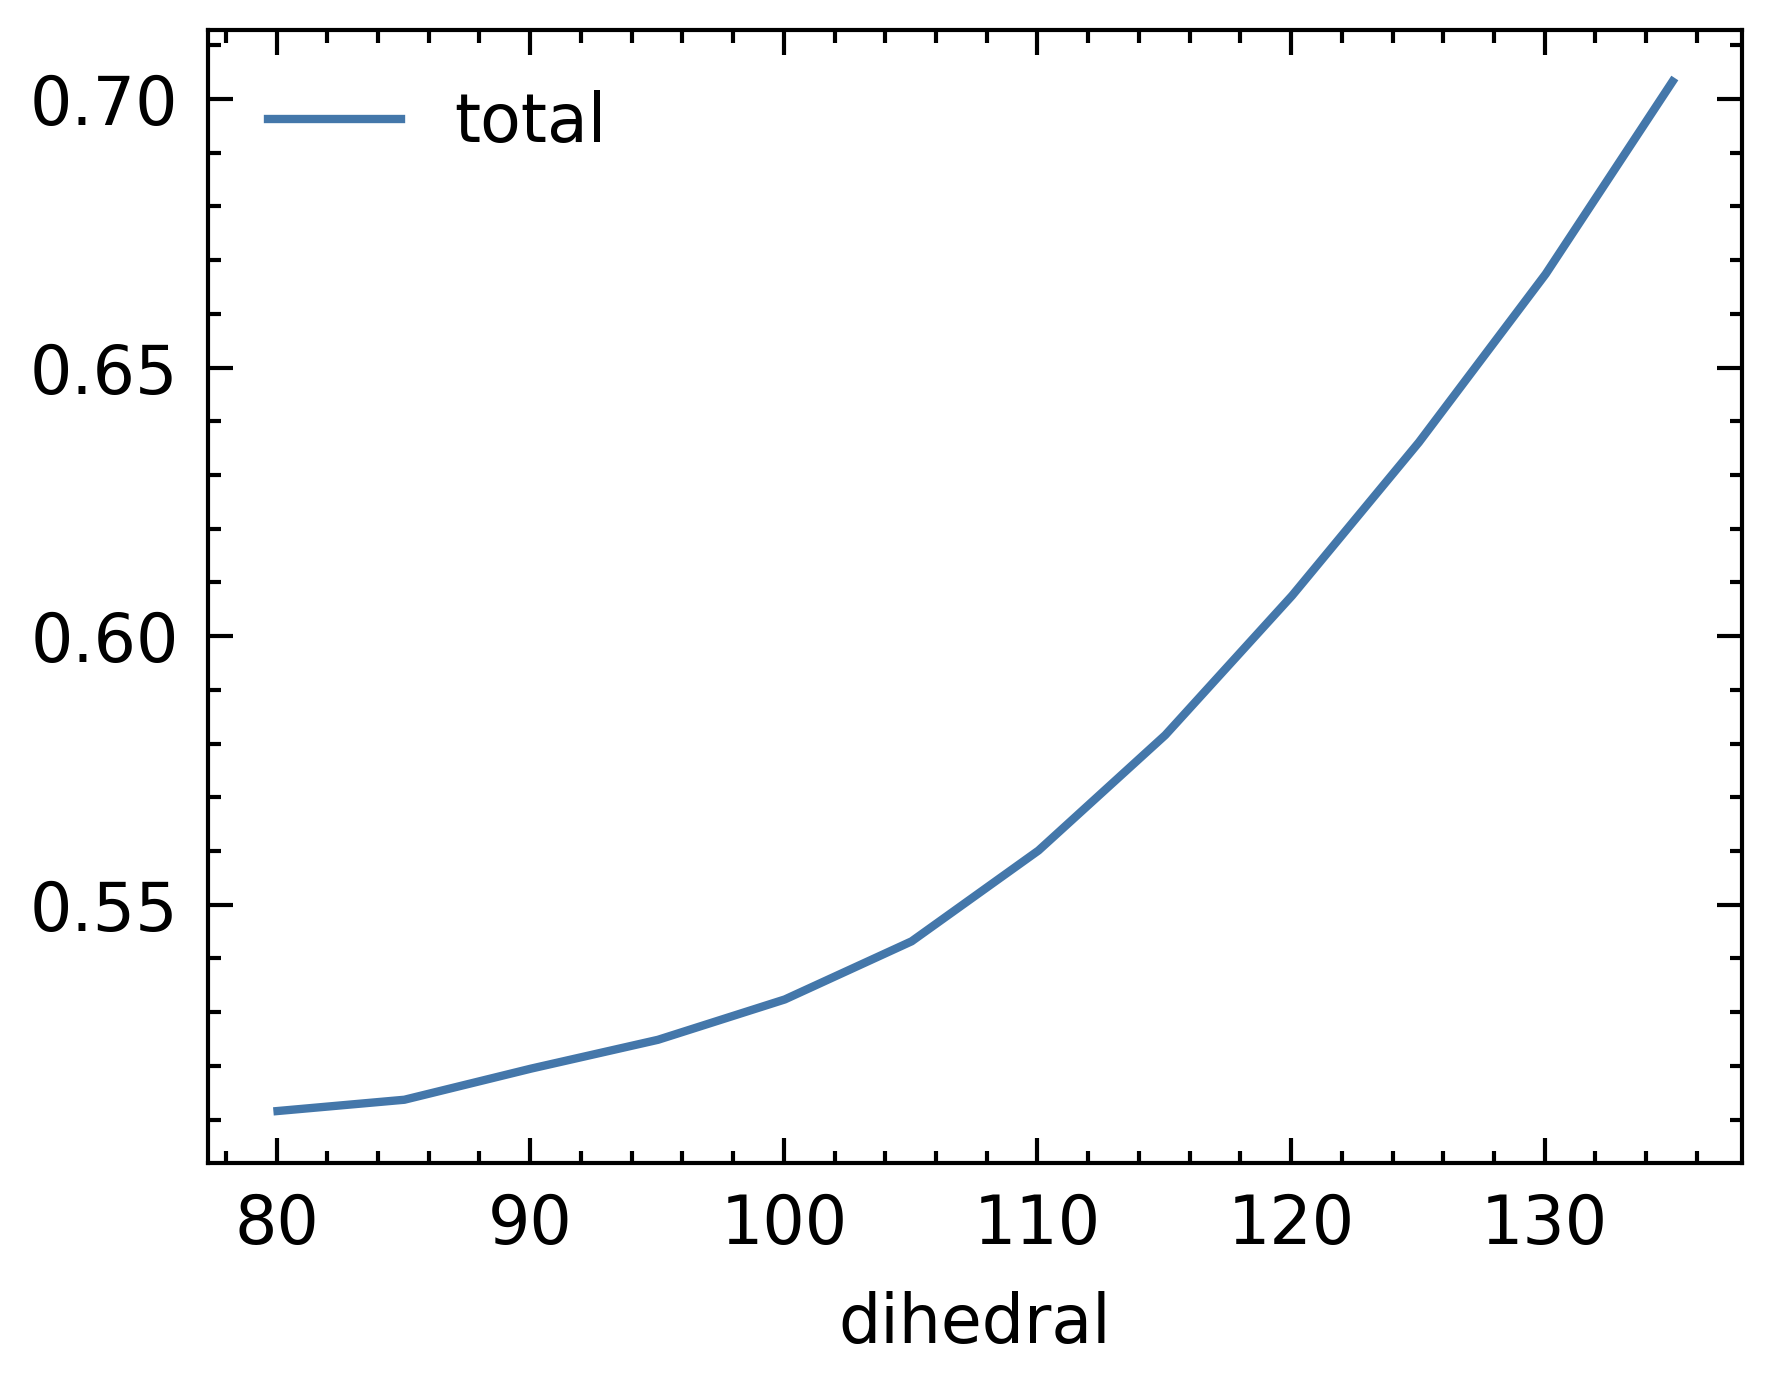

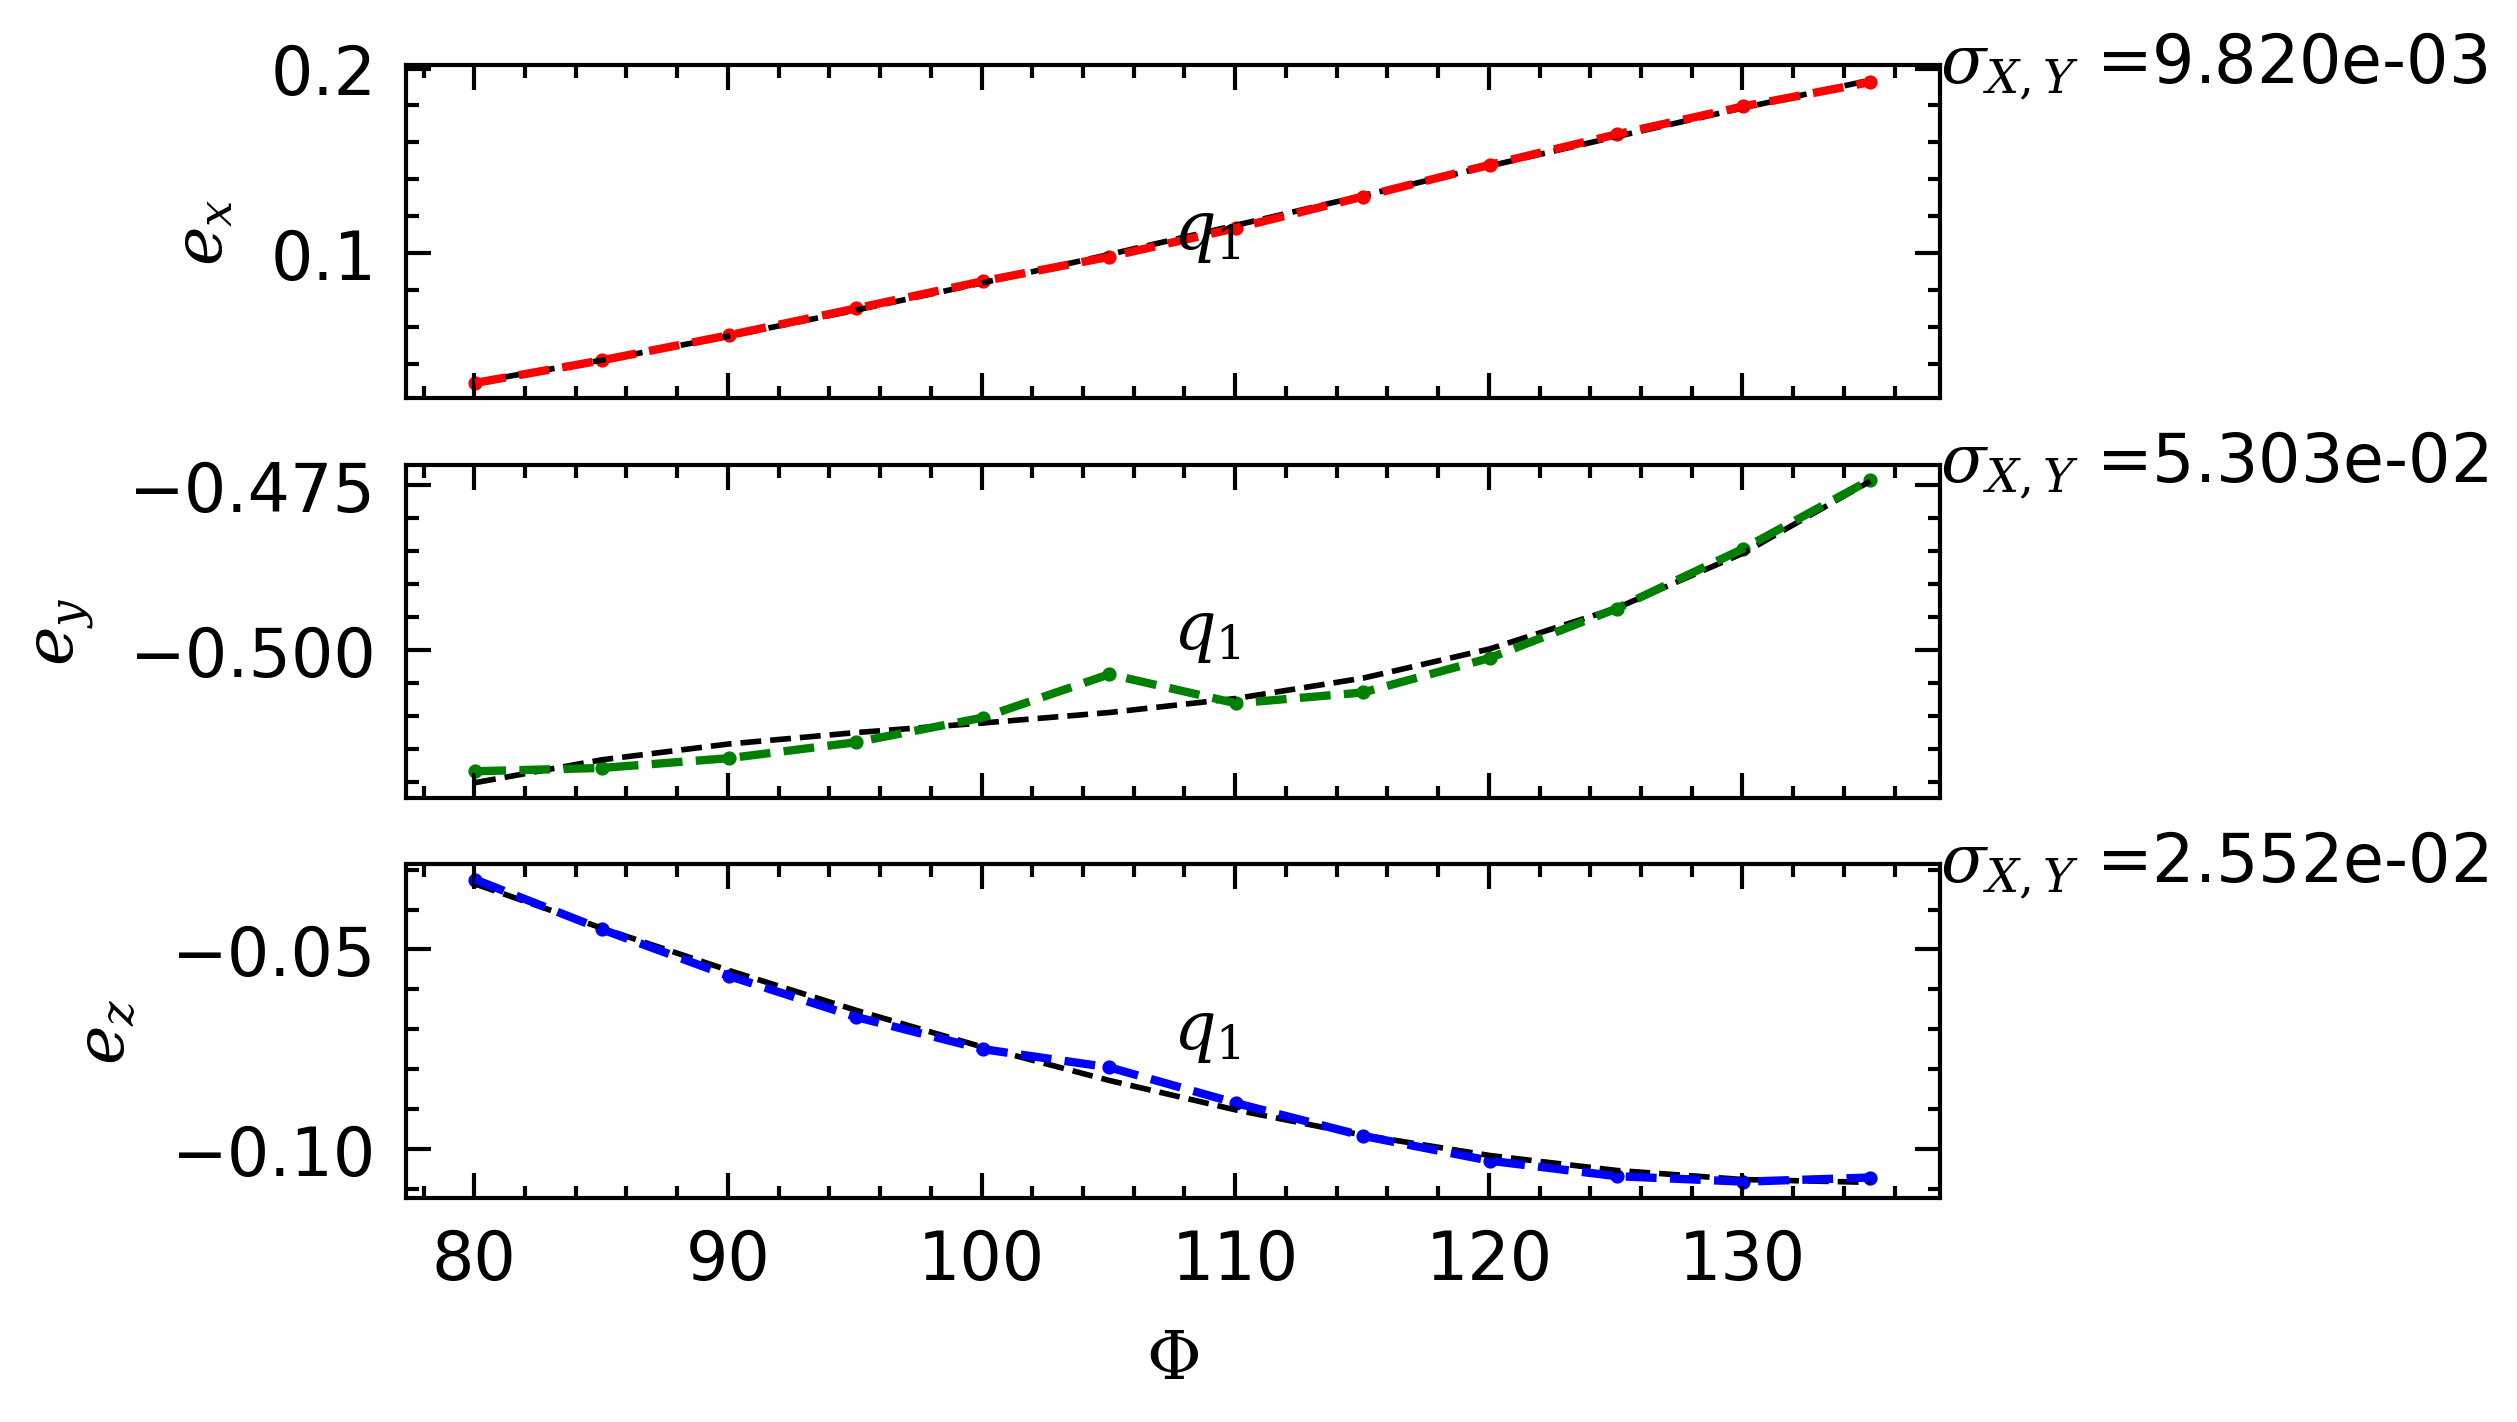

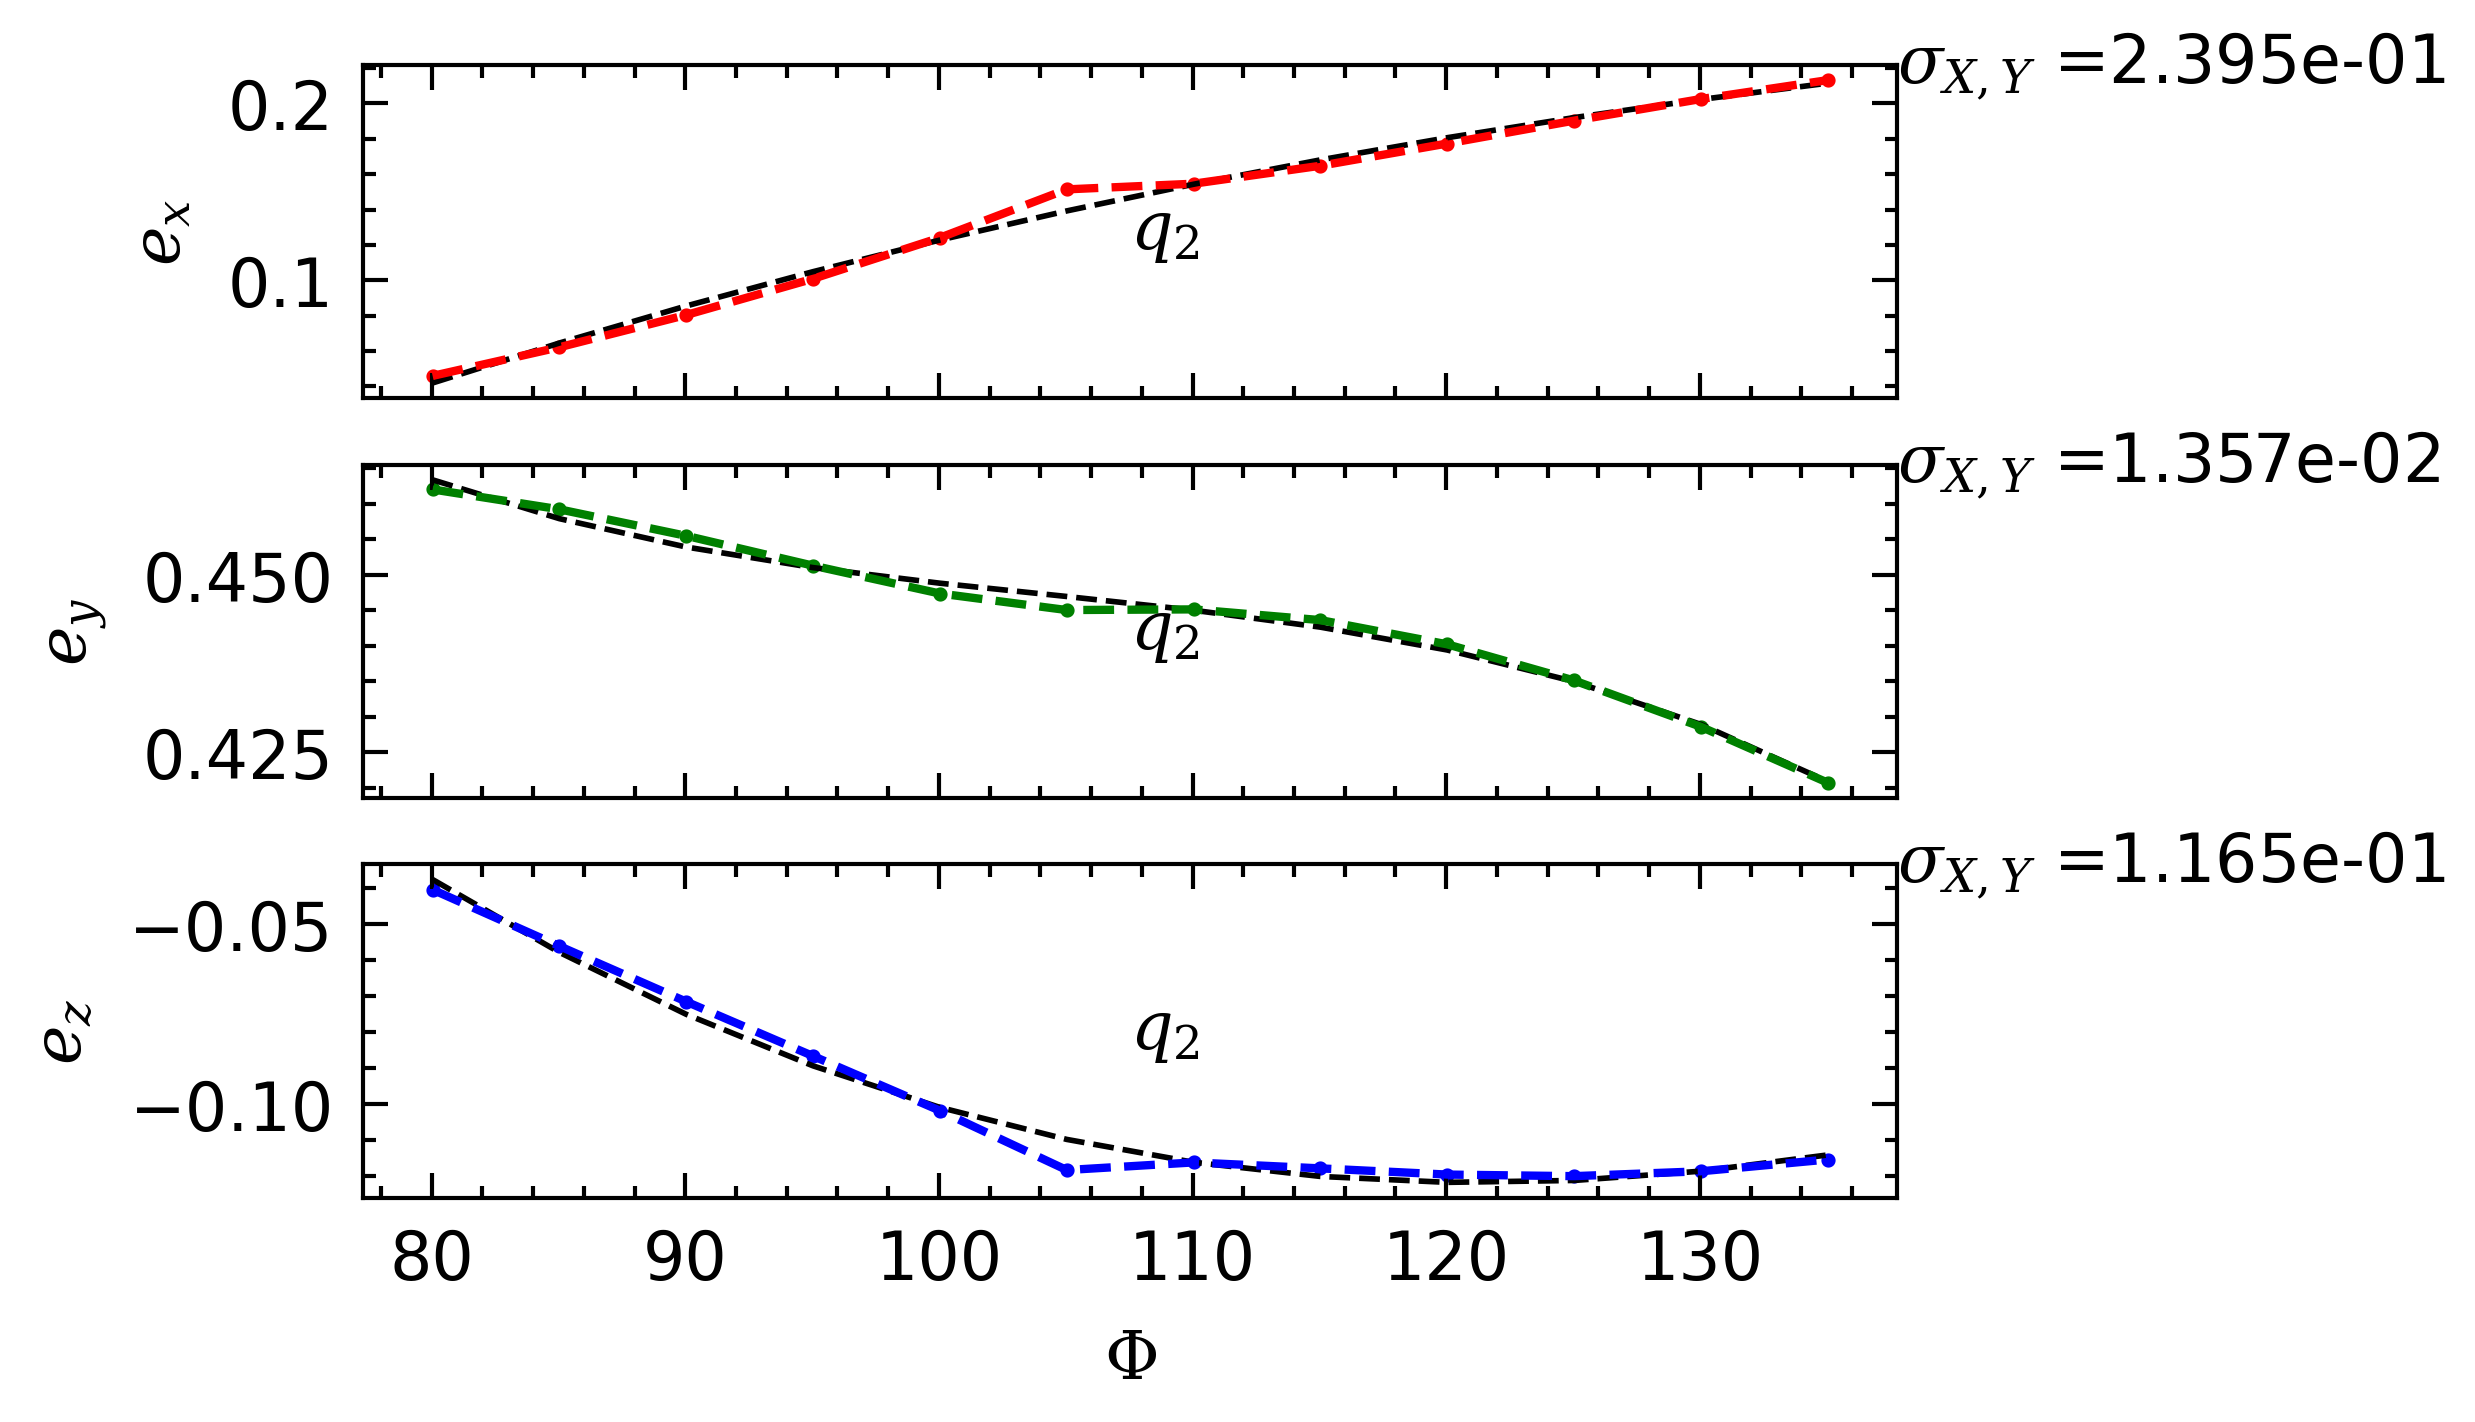

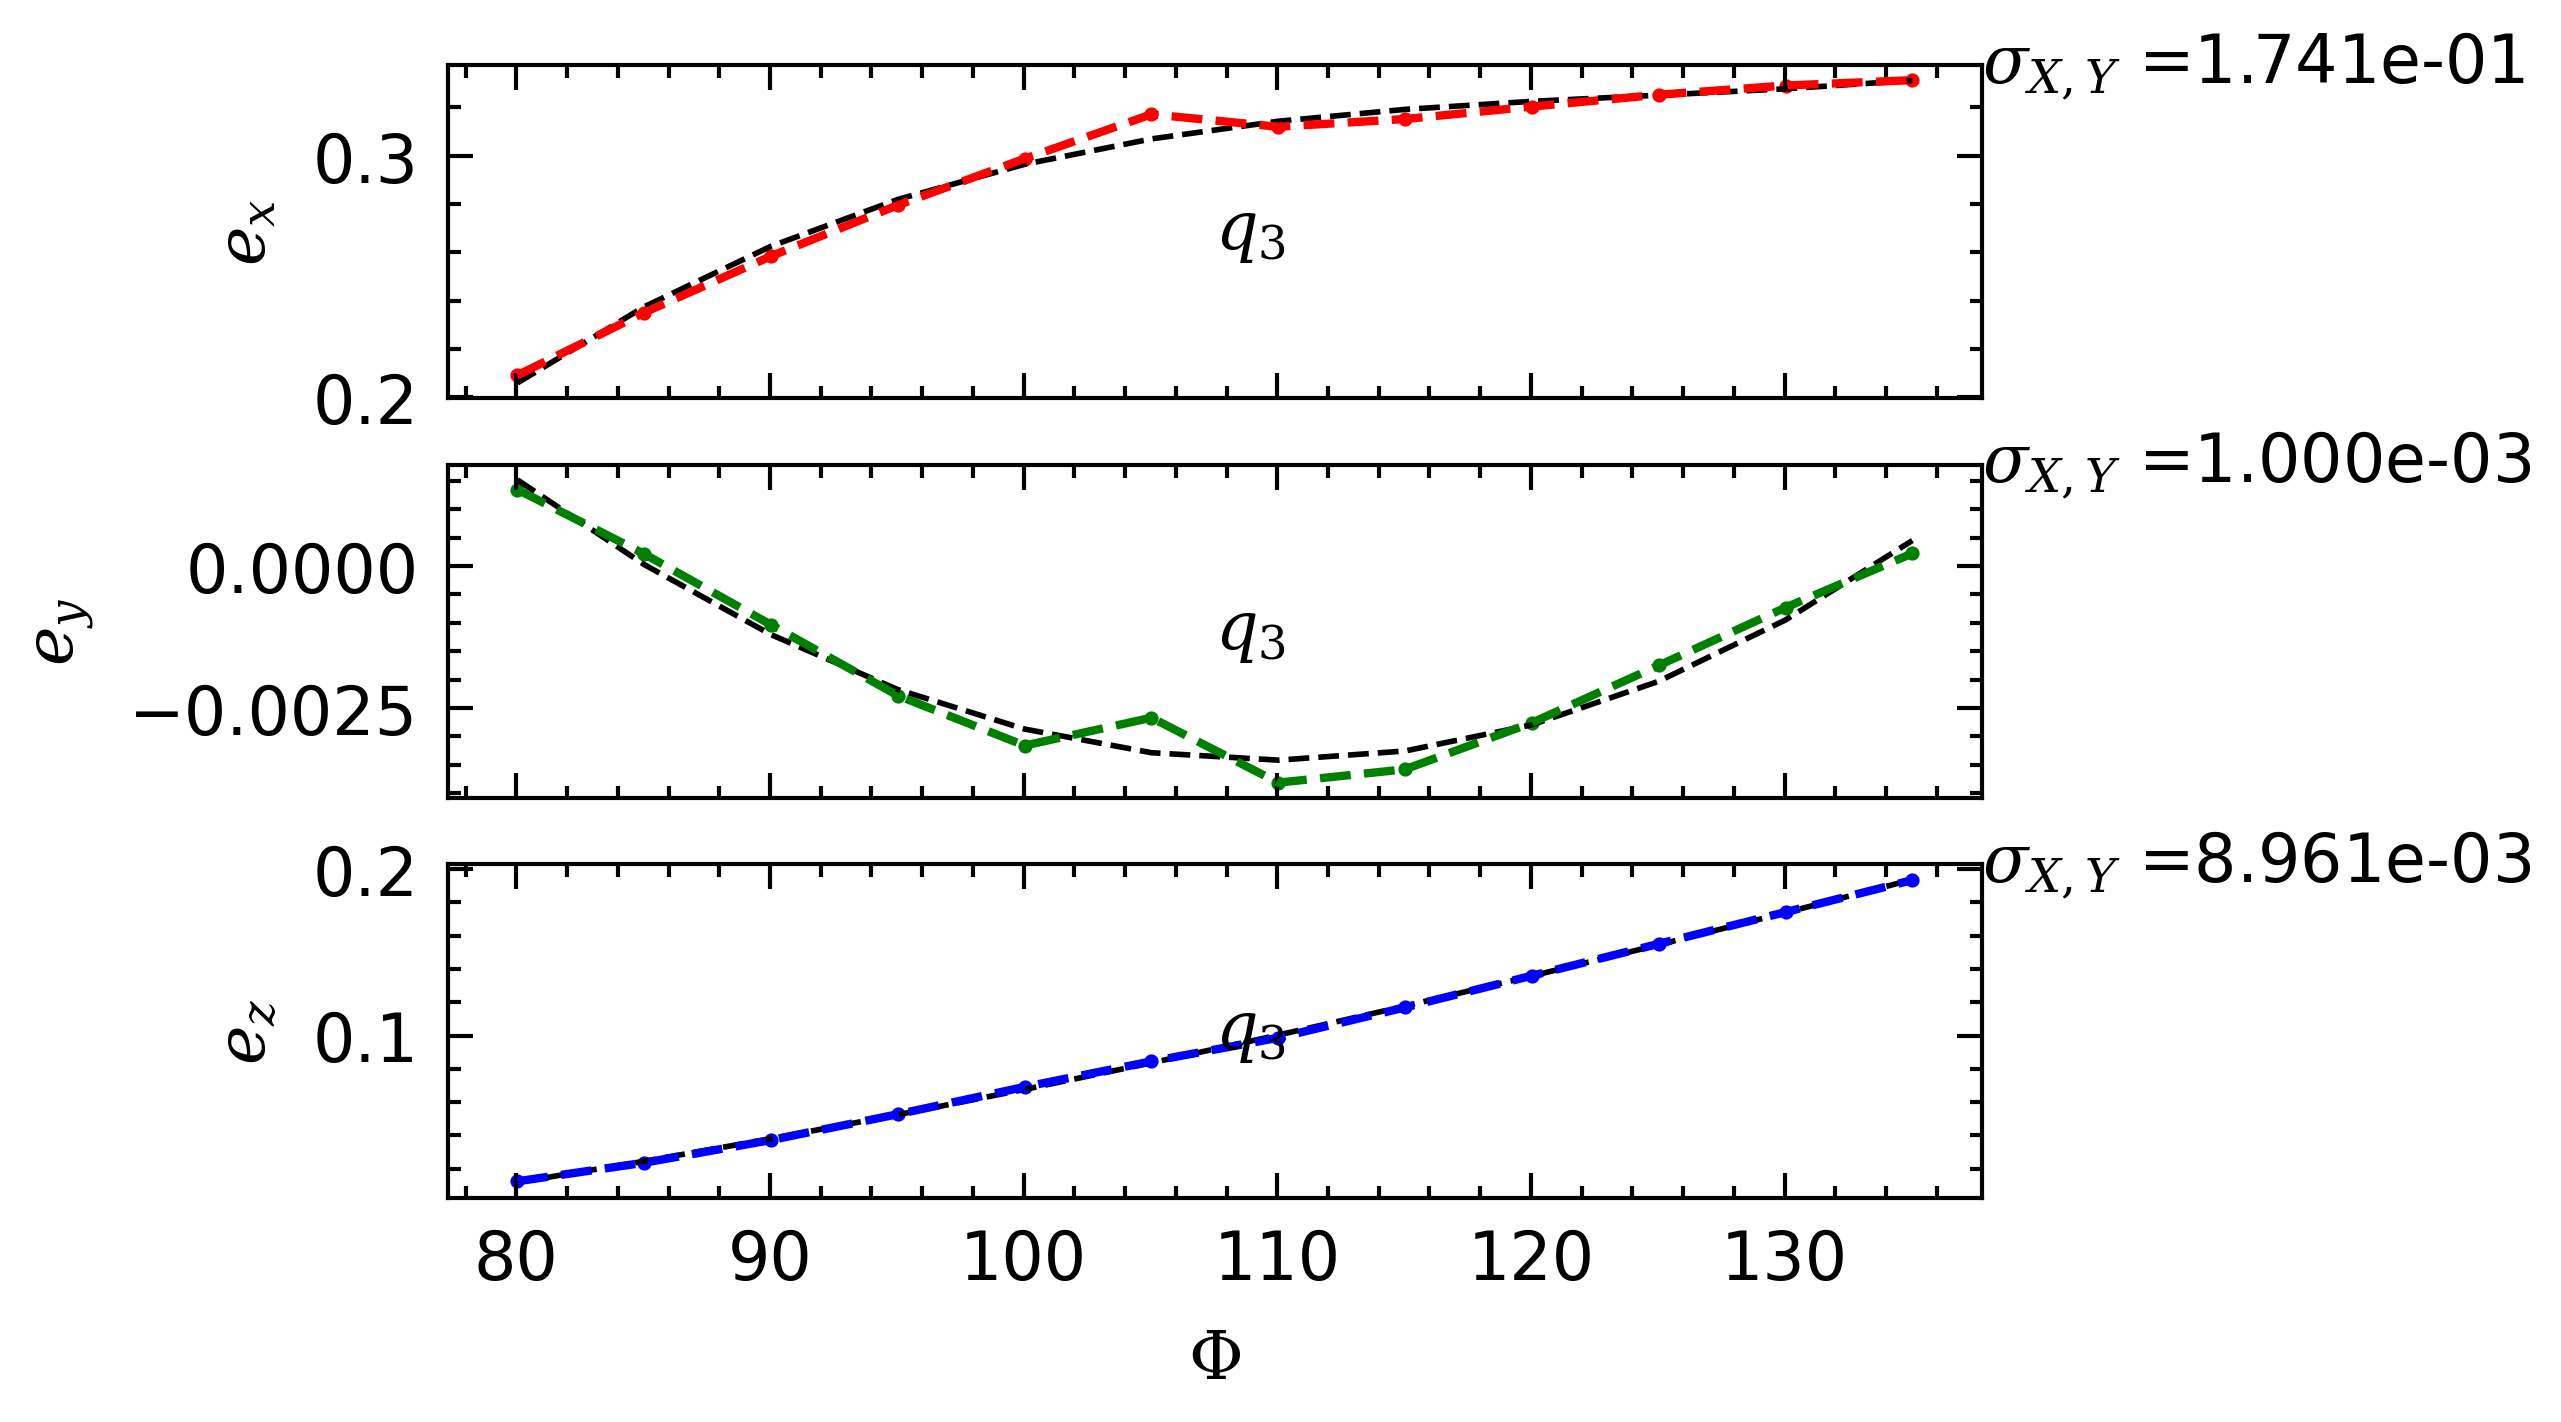

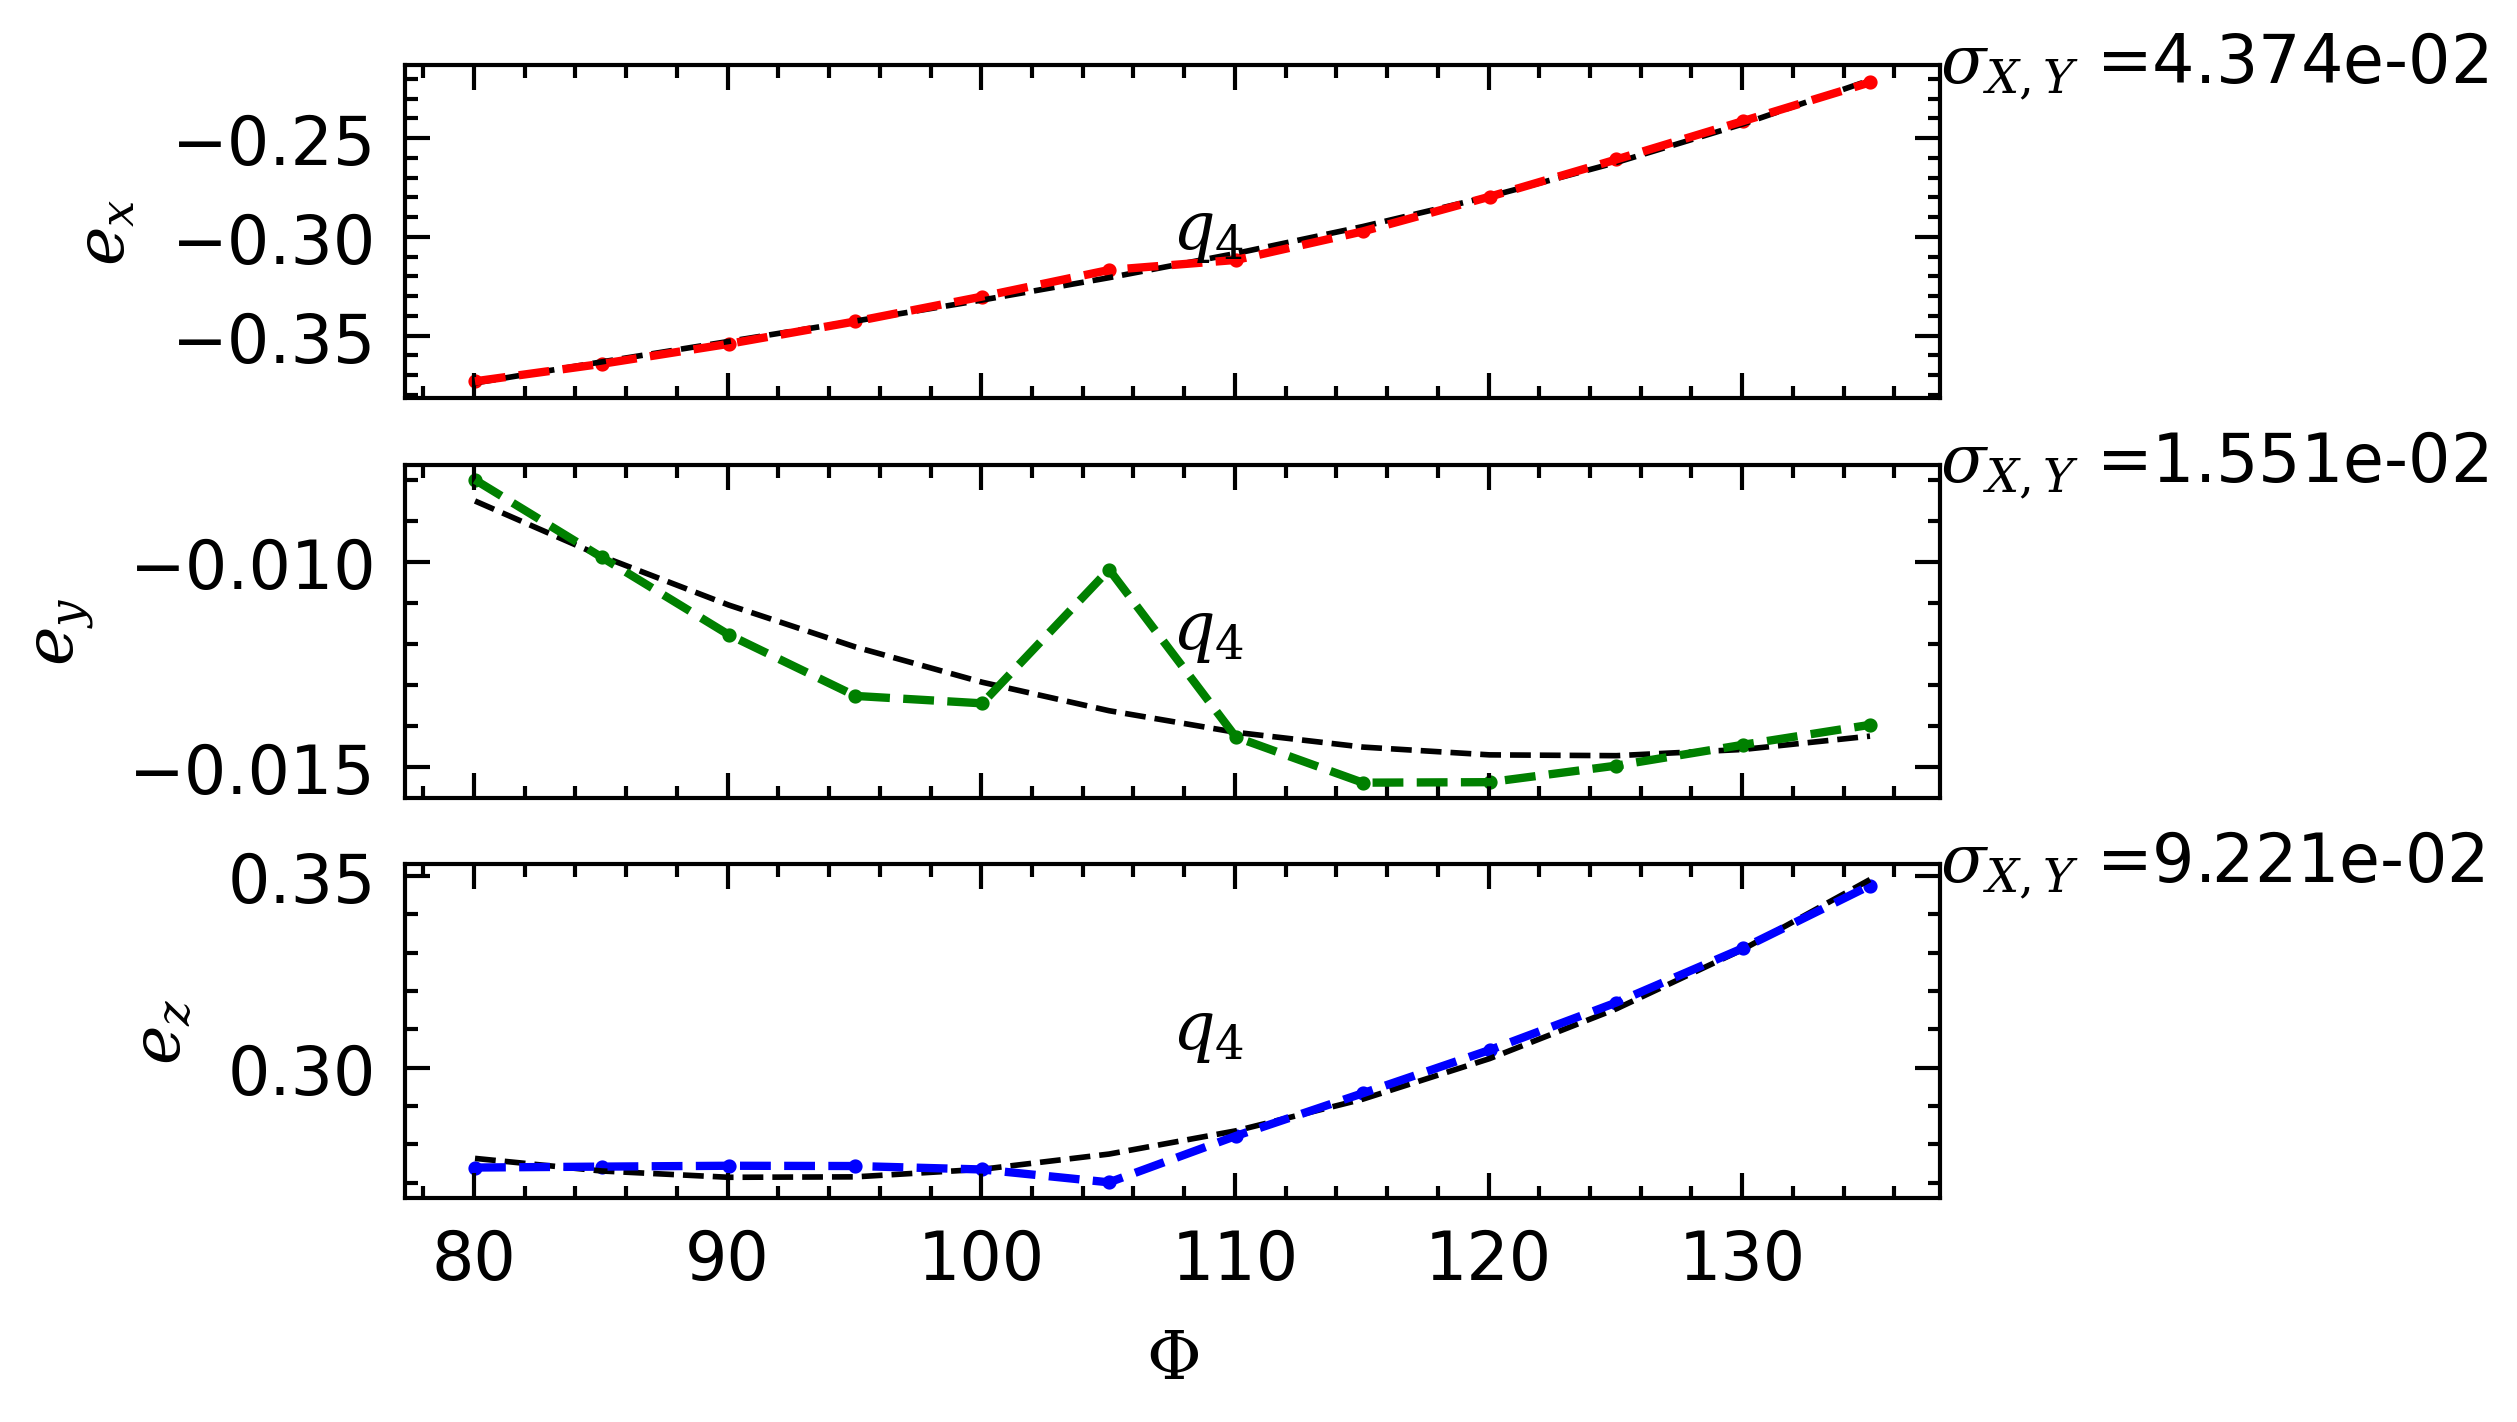

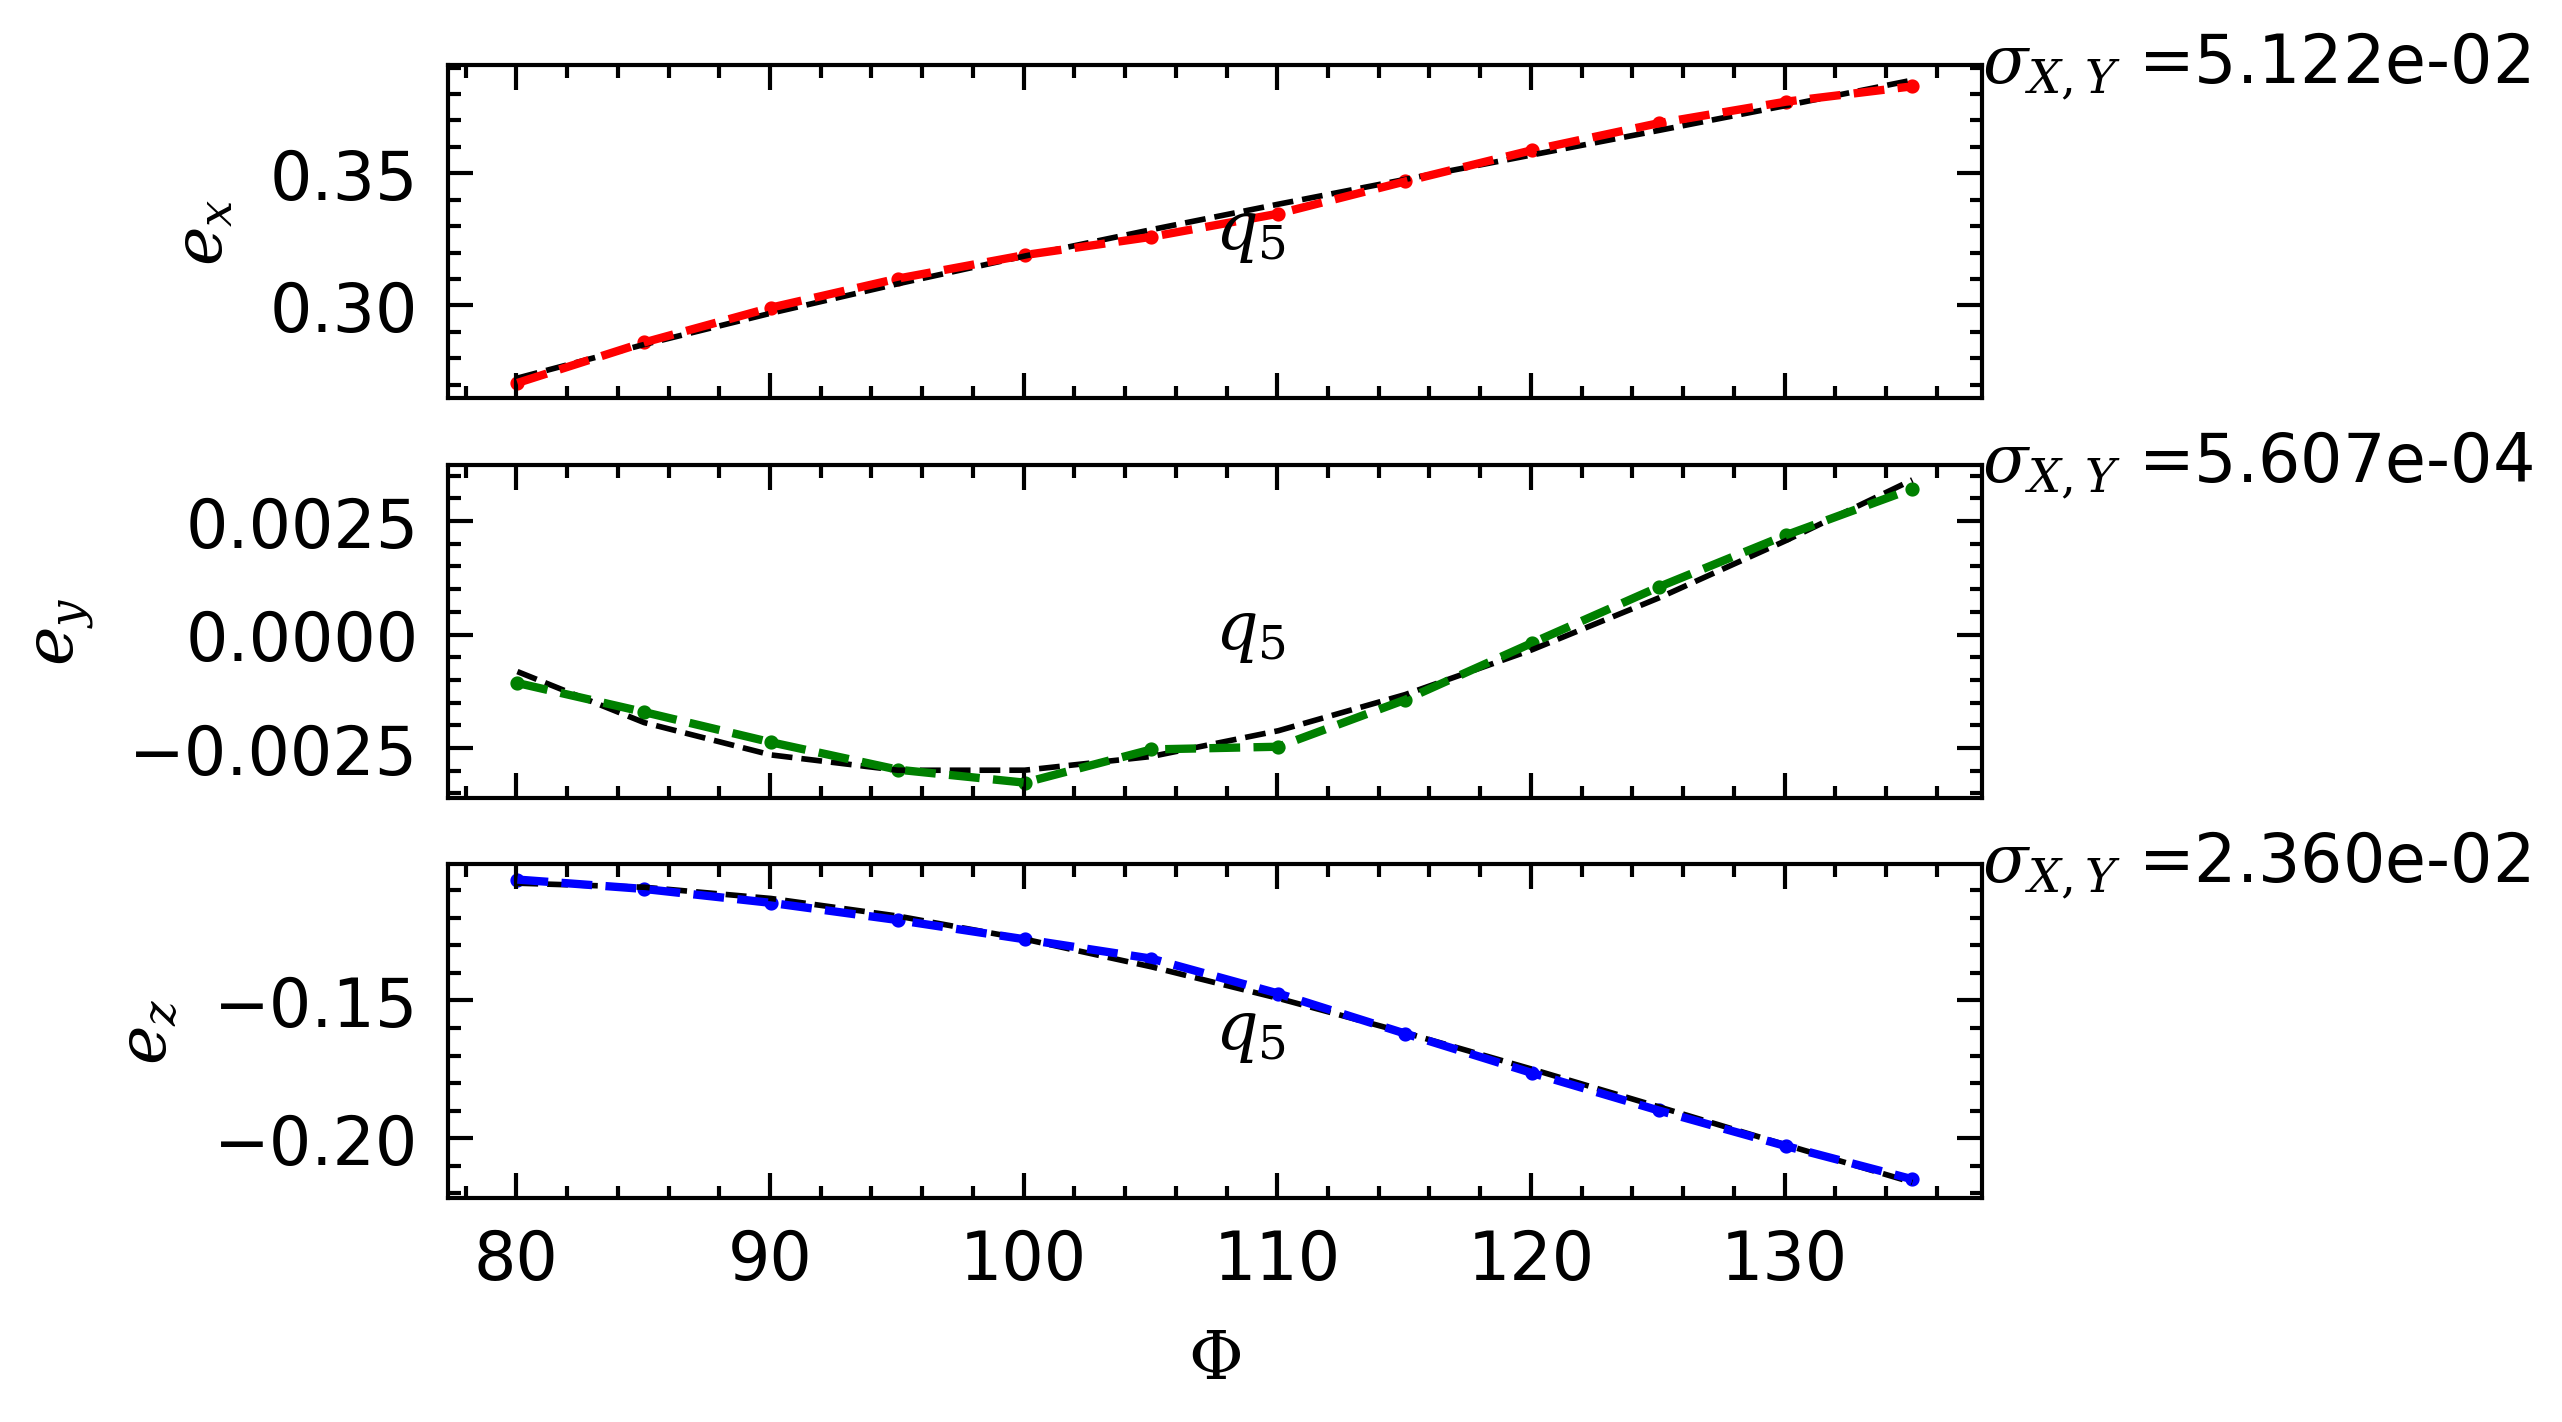

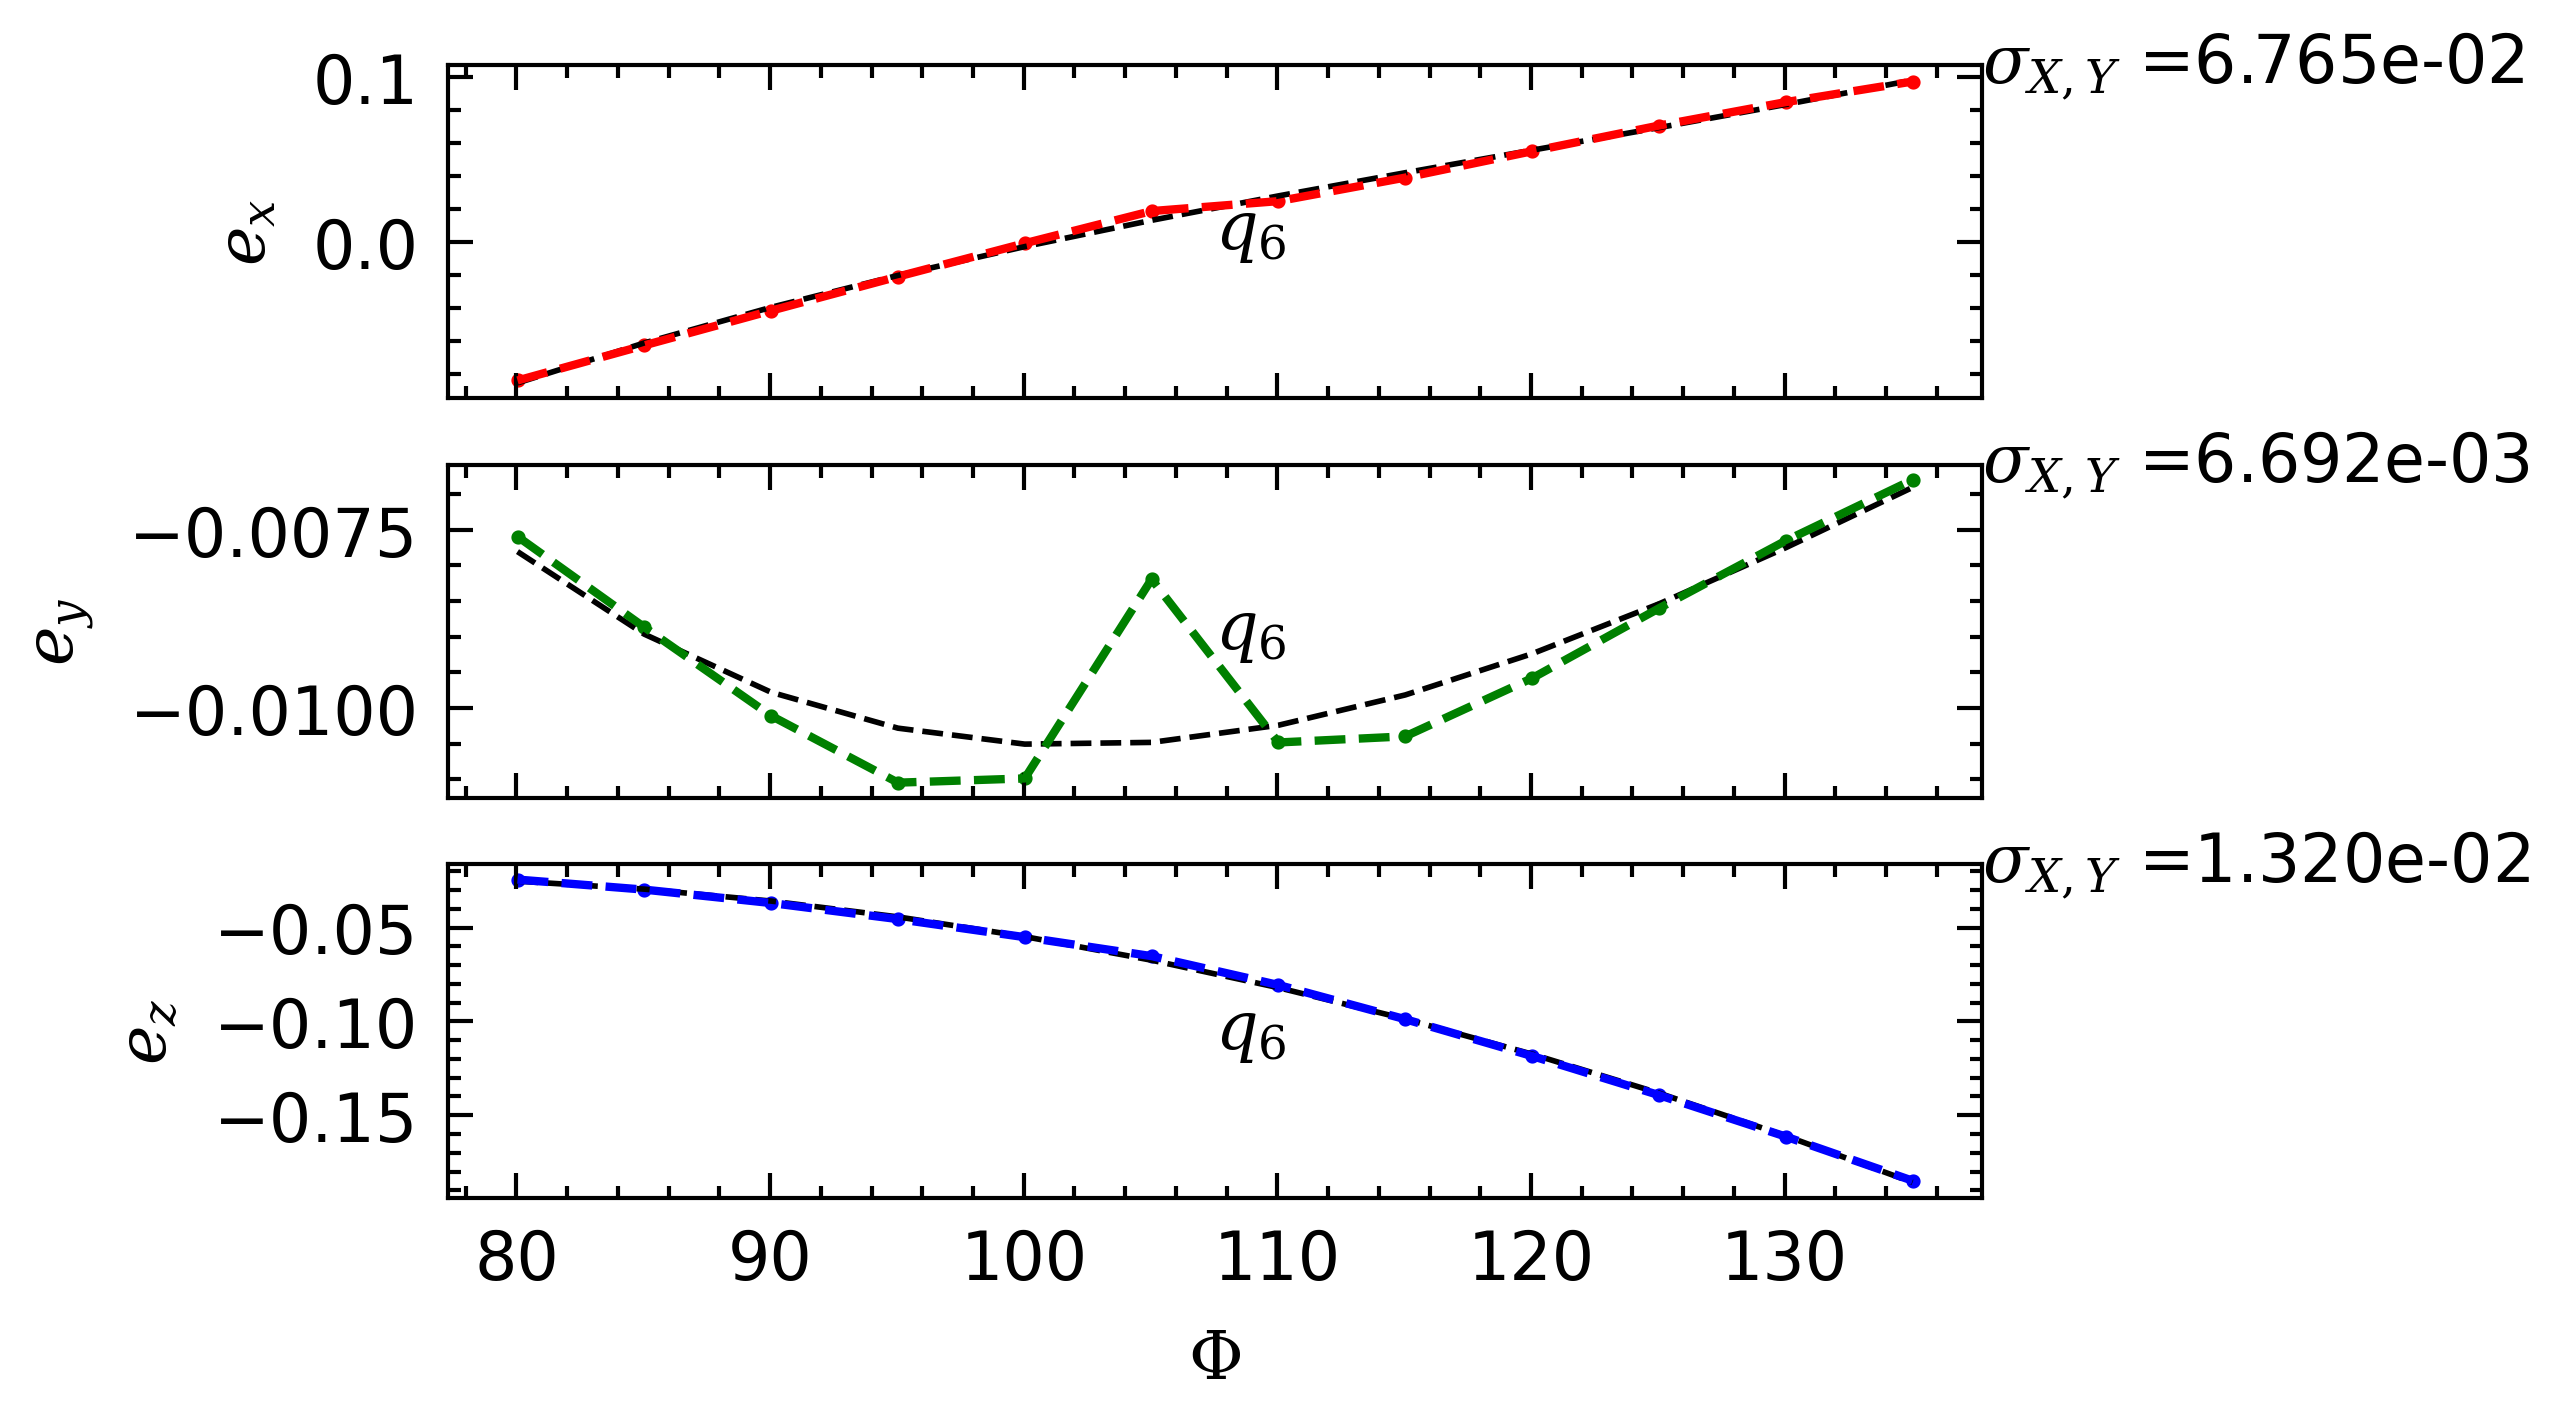

In [97]:
df_w_angle_fit = get_FDCM_data("/home/boittier/FDCM/angle_fit", "water_anglefit.csv")
df_w_angle_fit["dihedral"] = [a3_values[int(x)] for x in list(df_w_angle_fit["dihedral"])]
df_w_angle_fit = df_w_angle_fit.sort_values("dihedral")
df_w_angle_fit.plot("dihedral", "total")

for i in range(6):
    fit_functions.append(plot_charge(i, df_w_angle_fit, "hello"))

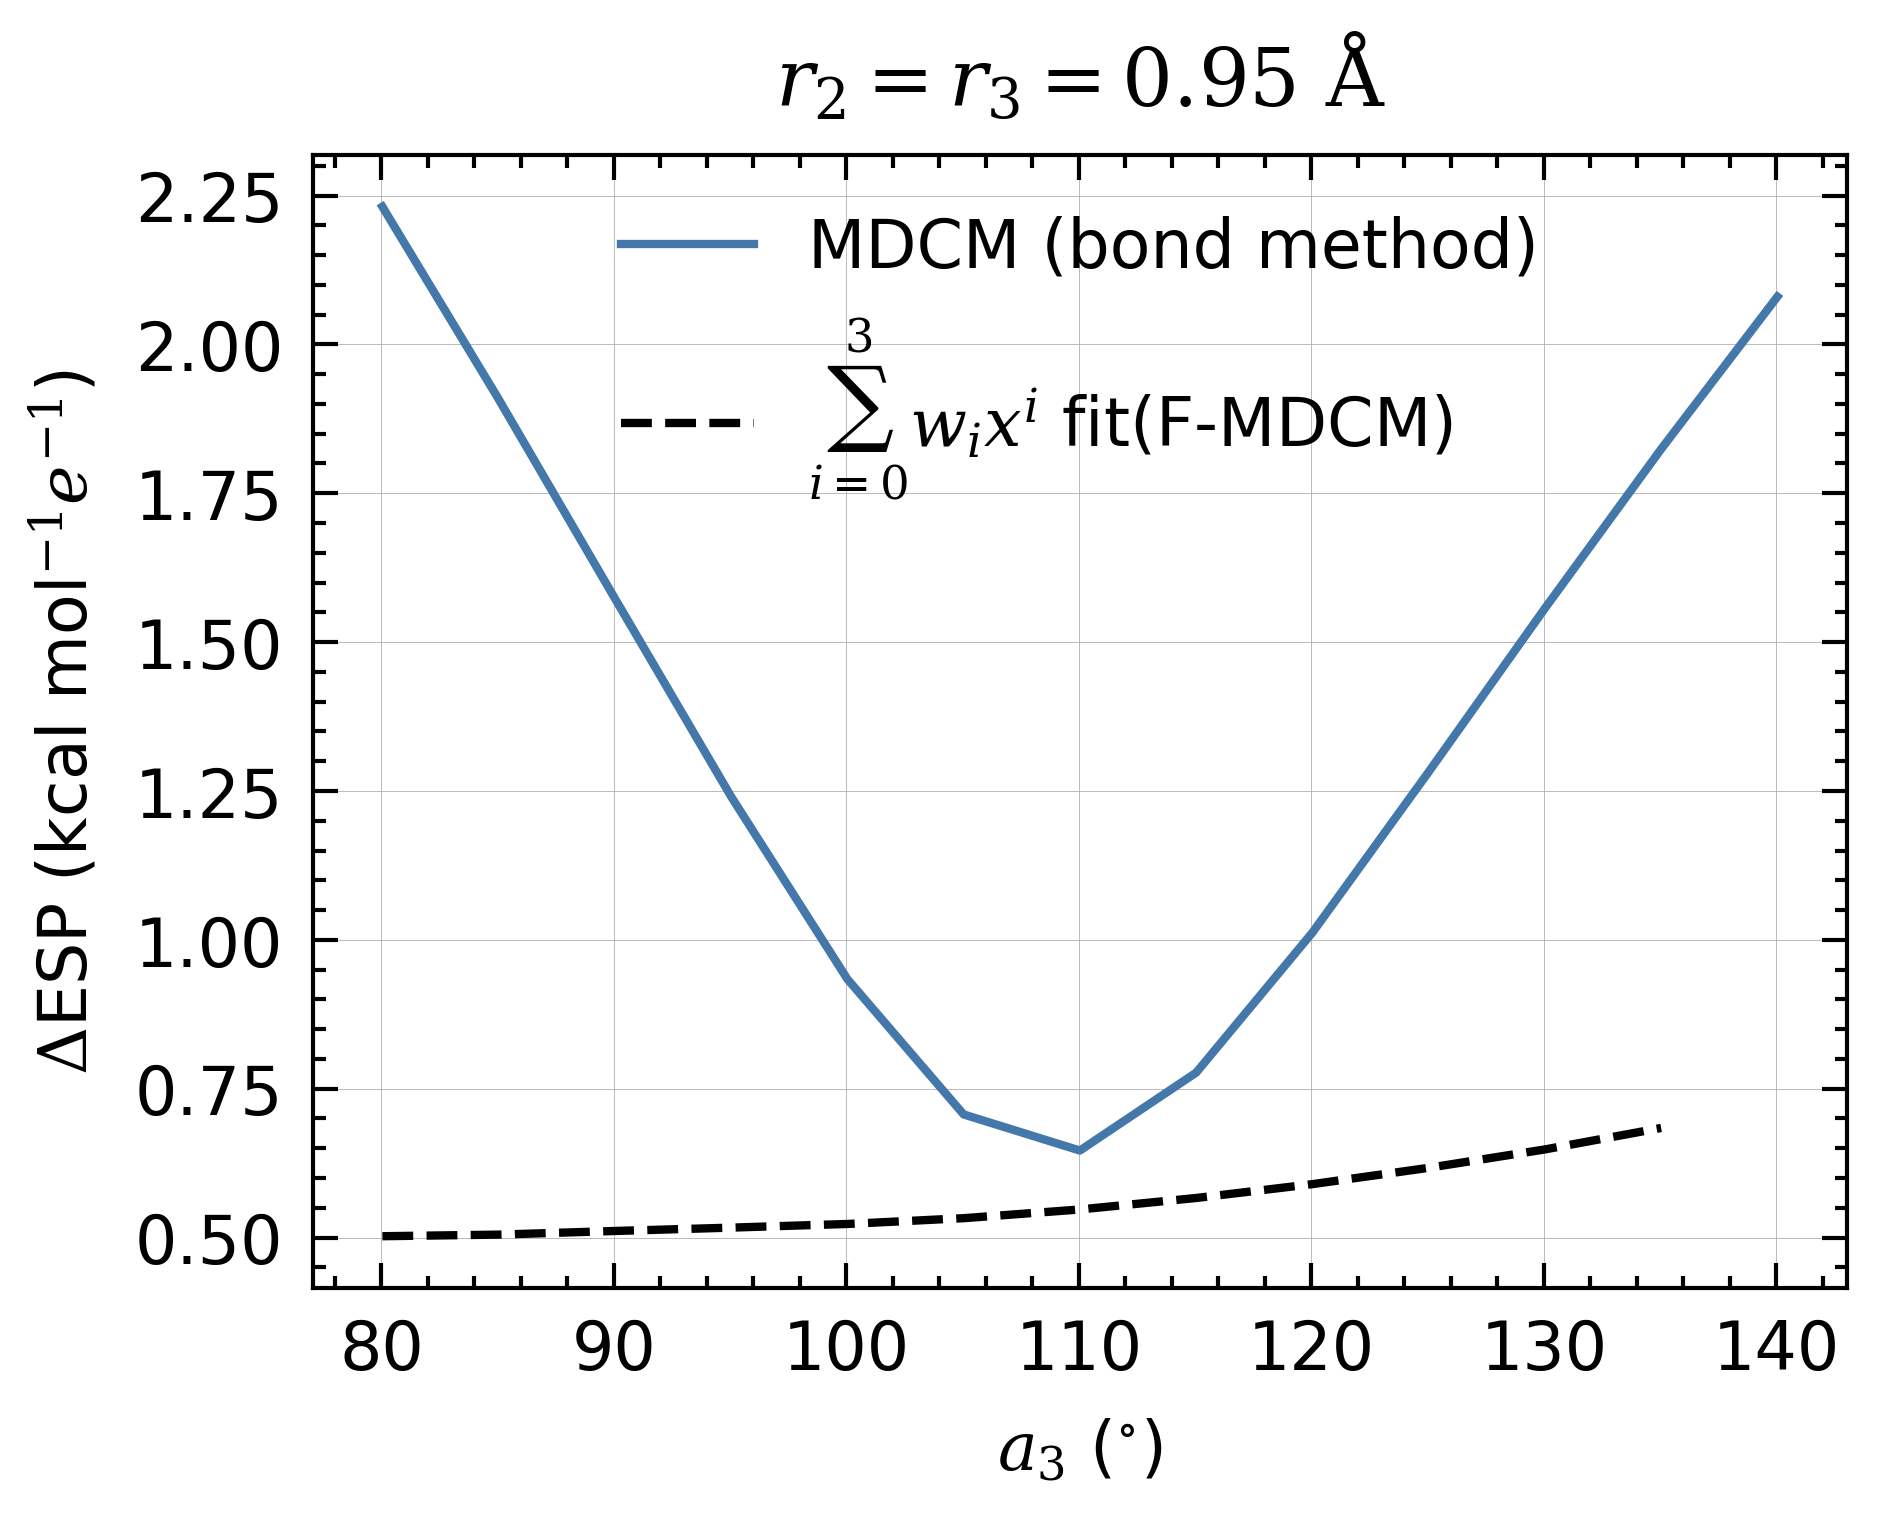

In [336]:
plt.style.use(['science','ieee', "no-latex", "bright"])

_a3 = (np.arange(eq_a3 - 30, eq_a3 + 30, 5))

def a3(x):
    return [_a3[int(i)] for i in x]

plt.plot((df_w_11_angle_0["dihedral"]), df_w_11_angle_0["total"], 
         "-", label="MDCM (bond method)")  

# plt.plot((df_w_bi_angle_0["dihedral"]), df_w_bi_angle_0["total"],
#          "-", label="MDCM (bisector method)")  

# plt.plot((df_w_angle_100["dihedral"]), df_w_angle_100["total"],
#          "-", label="$n_{steps}$ = 100")  

# plt.plot((df_w_angle_1000["dihedral"]), df_w_angle_1000["total"],
#          "-*", label="F-MDCM")  

plt.plot((df_w_11_fit_angle_0["dihedral"]), df_w_11_fit_angle_0["total"],
         "--", c="k", label="$\sum^{3}_{i=0} w_{i}x^i$ fit(F-MDCM)")  


plt.legend()
plt.ylabel("$\Delta$ESP (kcal mol$^{-1} e^{-1}$)")
plt.xlabel("$a_3$ ($^{\circ}$)")
plt.grid(linewidth=0.1)
plt.title("$r_2 = r_3 = 0.95~ \mathrm{\AA}$")
plt.savefig("angle_fit_11_summary.pdf", bbox_inches="tight")